In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(compositions)
library(ggsci)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    muta

ERROR: Error in library(compositions): there is no package called ‘compositions’


In [ ]:
colors = c('#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F')

# Reading the file

In [2]:
# Read the CSV file into a data frame
myeloid_df <- read.csv('/home/jupyter/Myeloid_cells/files/Parquet_files/AIFI_Reference_processed.csv')


In [3]:
#remove UPI from the cohort
myeloid_df <- myeloid_df %>% filter(cohort.cohortGuid != 'UP1')

In [ ]:
colnames(myeloid_df)

In [4]:
rownames(myeloid_df)<-myeloid_df$cell_uuid

In [ ]:
#length(unique(myeloid_df$subject.subjectGuid))

In [ ]:
#unique(myeloid_df$AIFI_L1)

In [ ]:
#head(myeloid_df)

# CLR Transform


In [5]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

# Comparsion within toal PBMCs (Percentage and Percentage CLR)

In [6]:
## Percentage of total

result <- myeloid_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result)
#sum(result$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3 subject.subjectGuid count percentage percentage_clr
1 ASDC    BR1001              6     0.03236770 -2.232976     
2 ASDC    BR1002              5     0.02637409 -2.242500     
3 ASDC    BR1003              4     0.02094680 -2.763896     
4 ASDC    BR1004              3     0.01710571 -2.626914     
5 ASDC    BR1005              5     0.02809620 -1.943233     
6 ASDC    BR1006              4     0.02300966 -2.337902

In [7]:
sum(result$percentage)

[1] 9200

In [ ]:
result %>% filter(subject.subjectGuid == "BR1001")

In [8]:
result %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [9]:
result<-left_join(result,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [10]:
head(result)


AIFI_L3 subject.subjectGuid count percentage percentage_clr cohort.cohortGuid
1 ASDC    BR1001              6     0.03236770 -2.232976      BR1              
2 ASDC    BR1002              5     0.02637409 -2.242500      BR1              
3 ASDC    BR1003              4     0.02094680 -2.763896      BR1              
4 ASDC    BR1004              3     0.01710571 -2.626914      BR1              
5 ASDC    BR1005              5     0.02809620 -1.943233      BR1              
6 ASDC    BR1006              4     0.02300966 -2.337902      BR1              
  subject.biologicalSex CMV.IgG.Serology.Result.Interpretation
1 Female                Negative                              
2 Male                  Negative                              
3 Female                Negative                              
4 Male                  Negative                              
5 Female                Negative                              
6 Male                  Negative

In [ ]:
#####Global plot#############

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


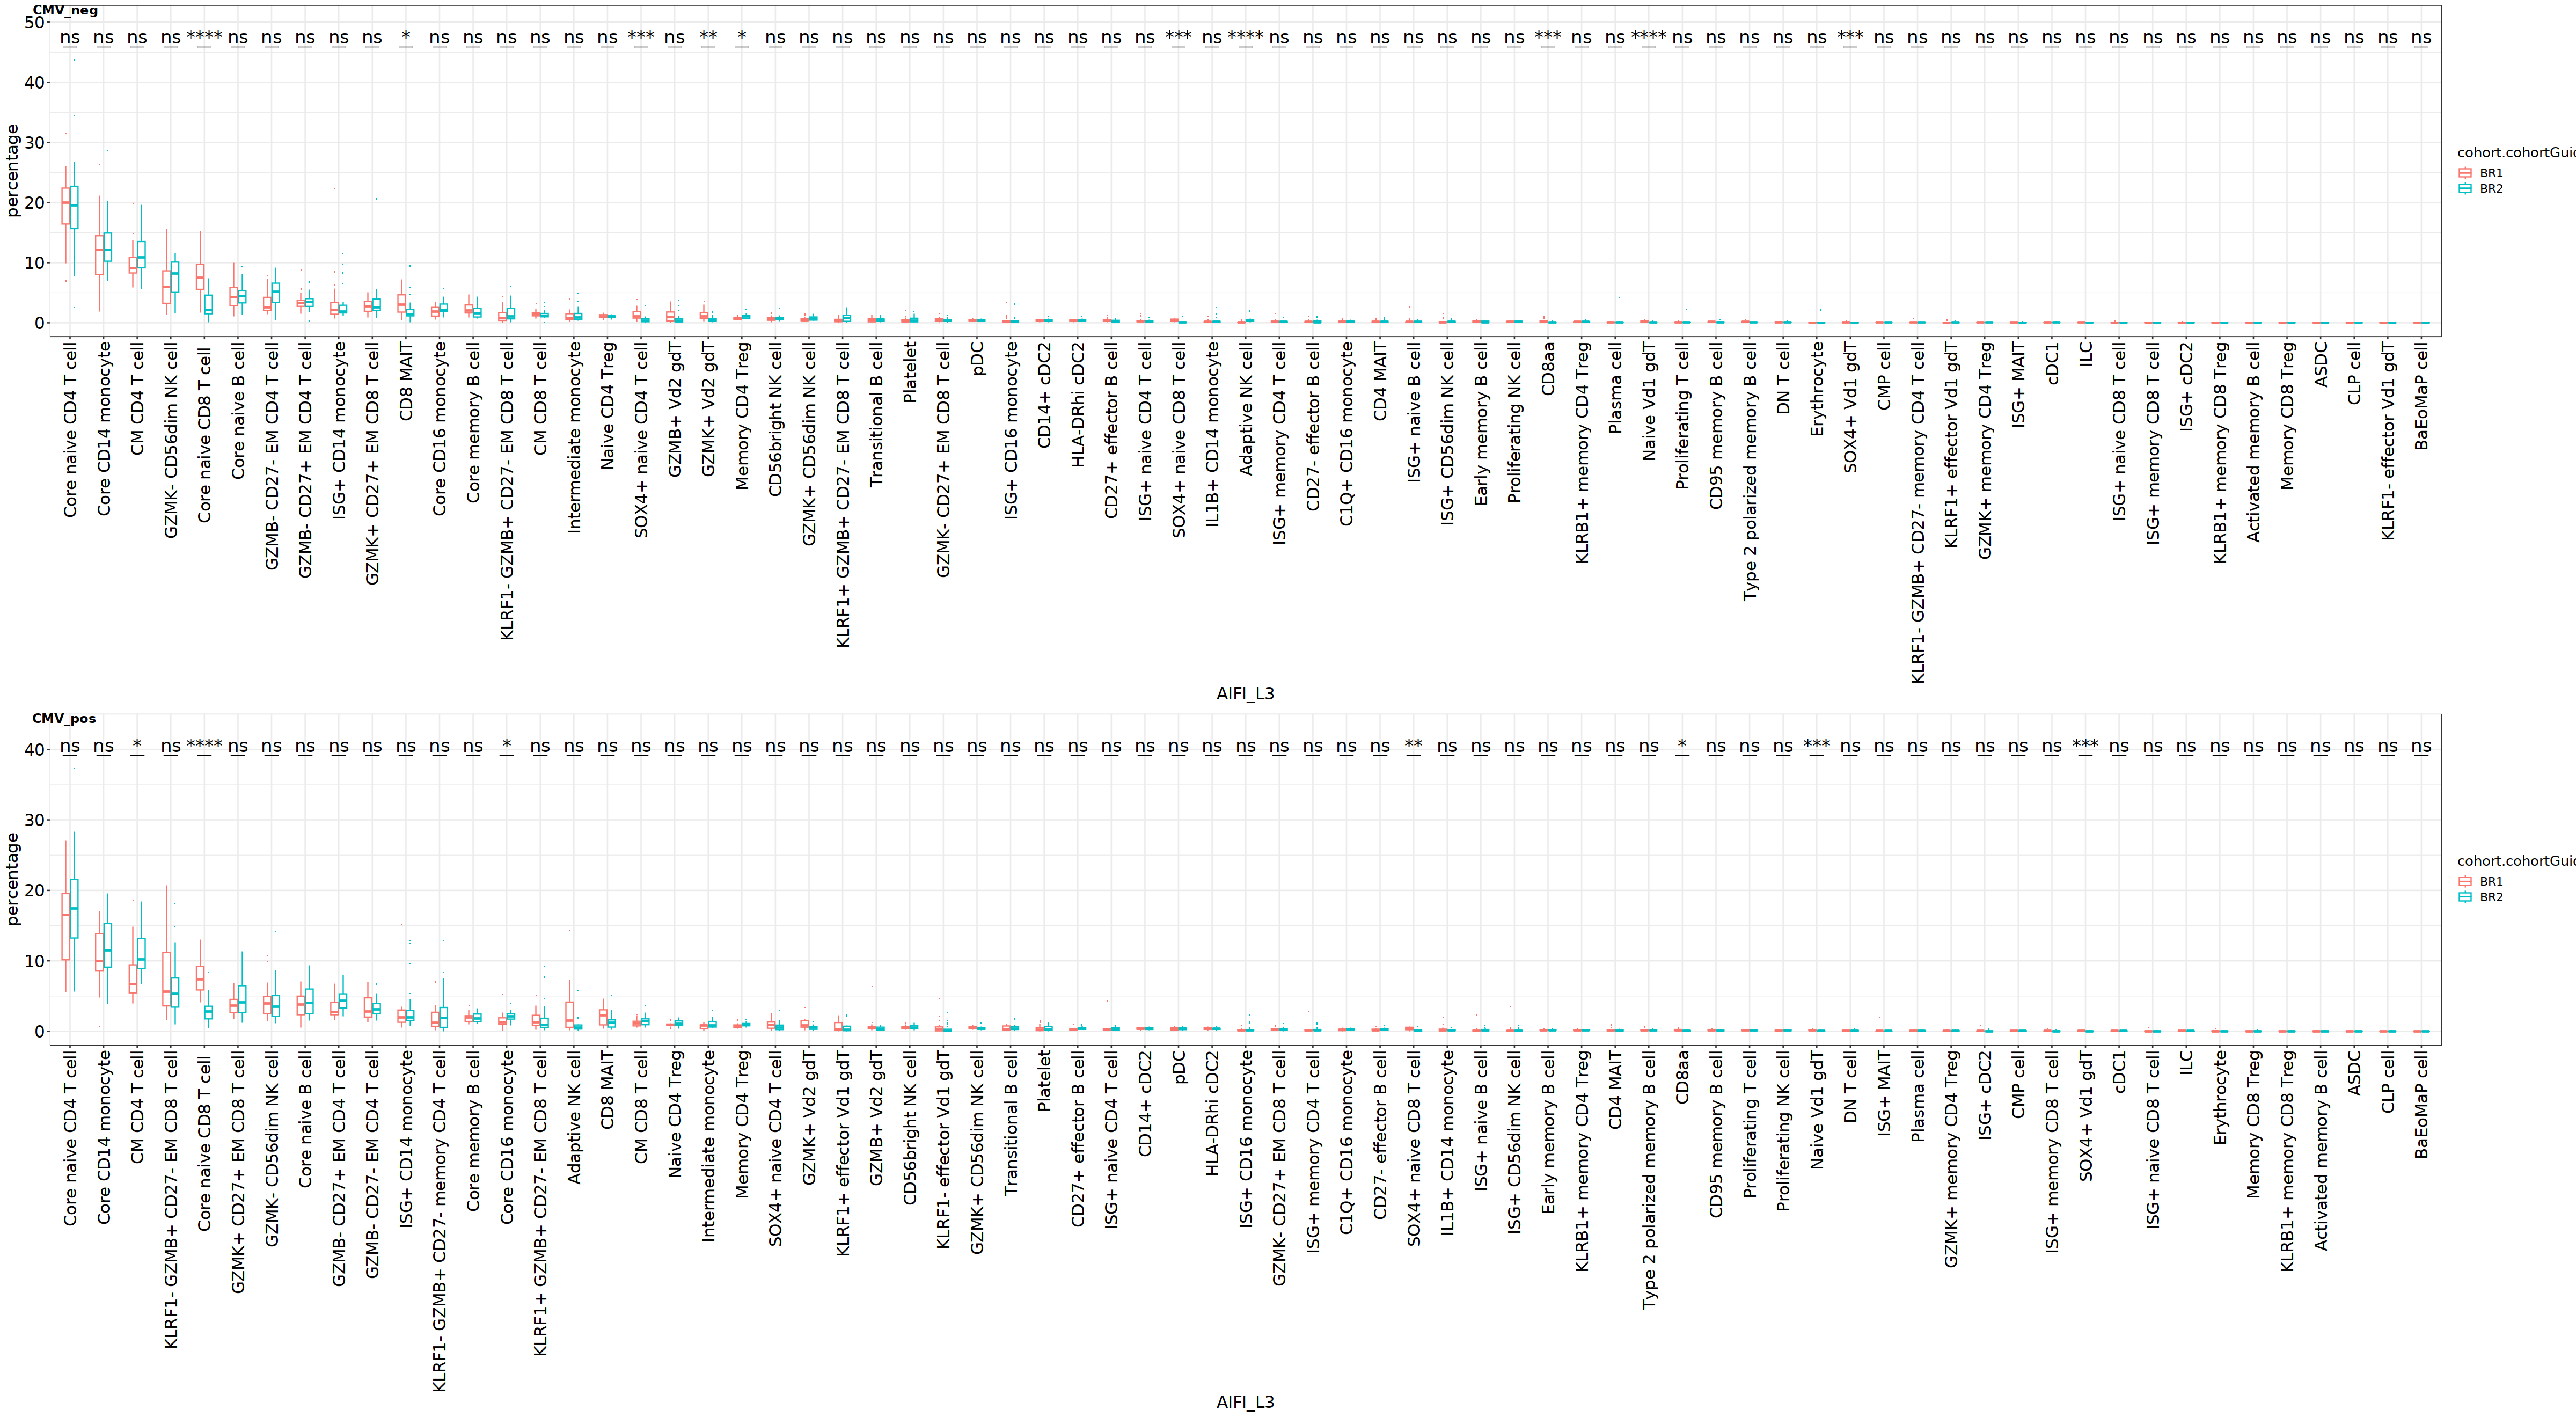

In [64]:
# Percentage comparing Age across CMV

####################. Negative CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p1)


####################. Positive CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p2)

library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 22)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot



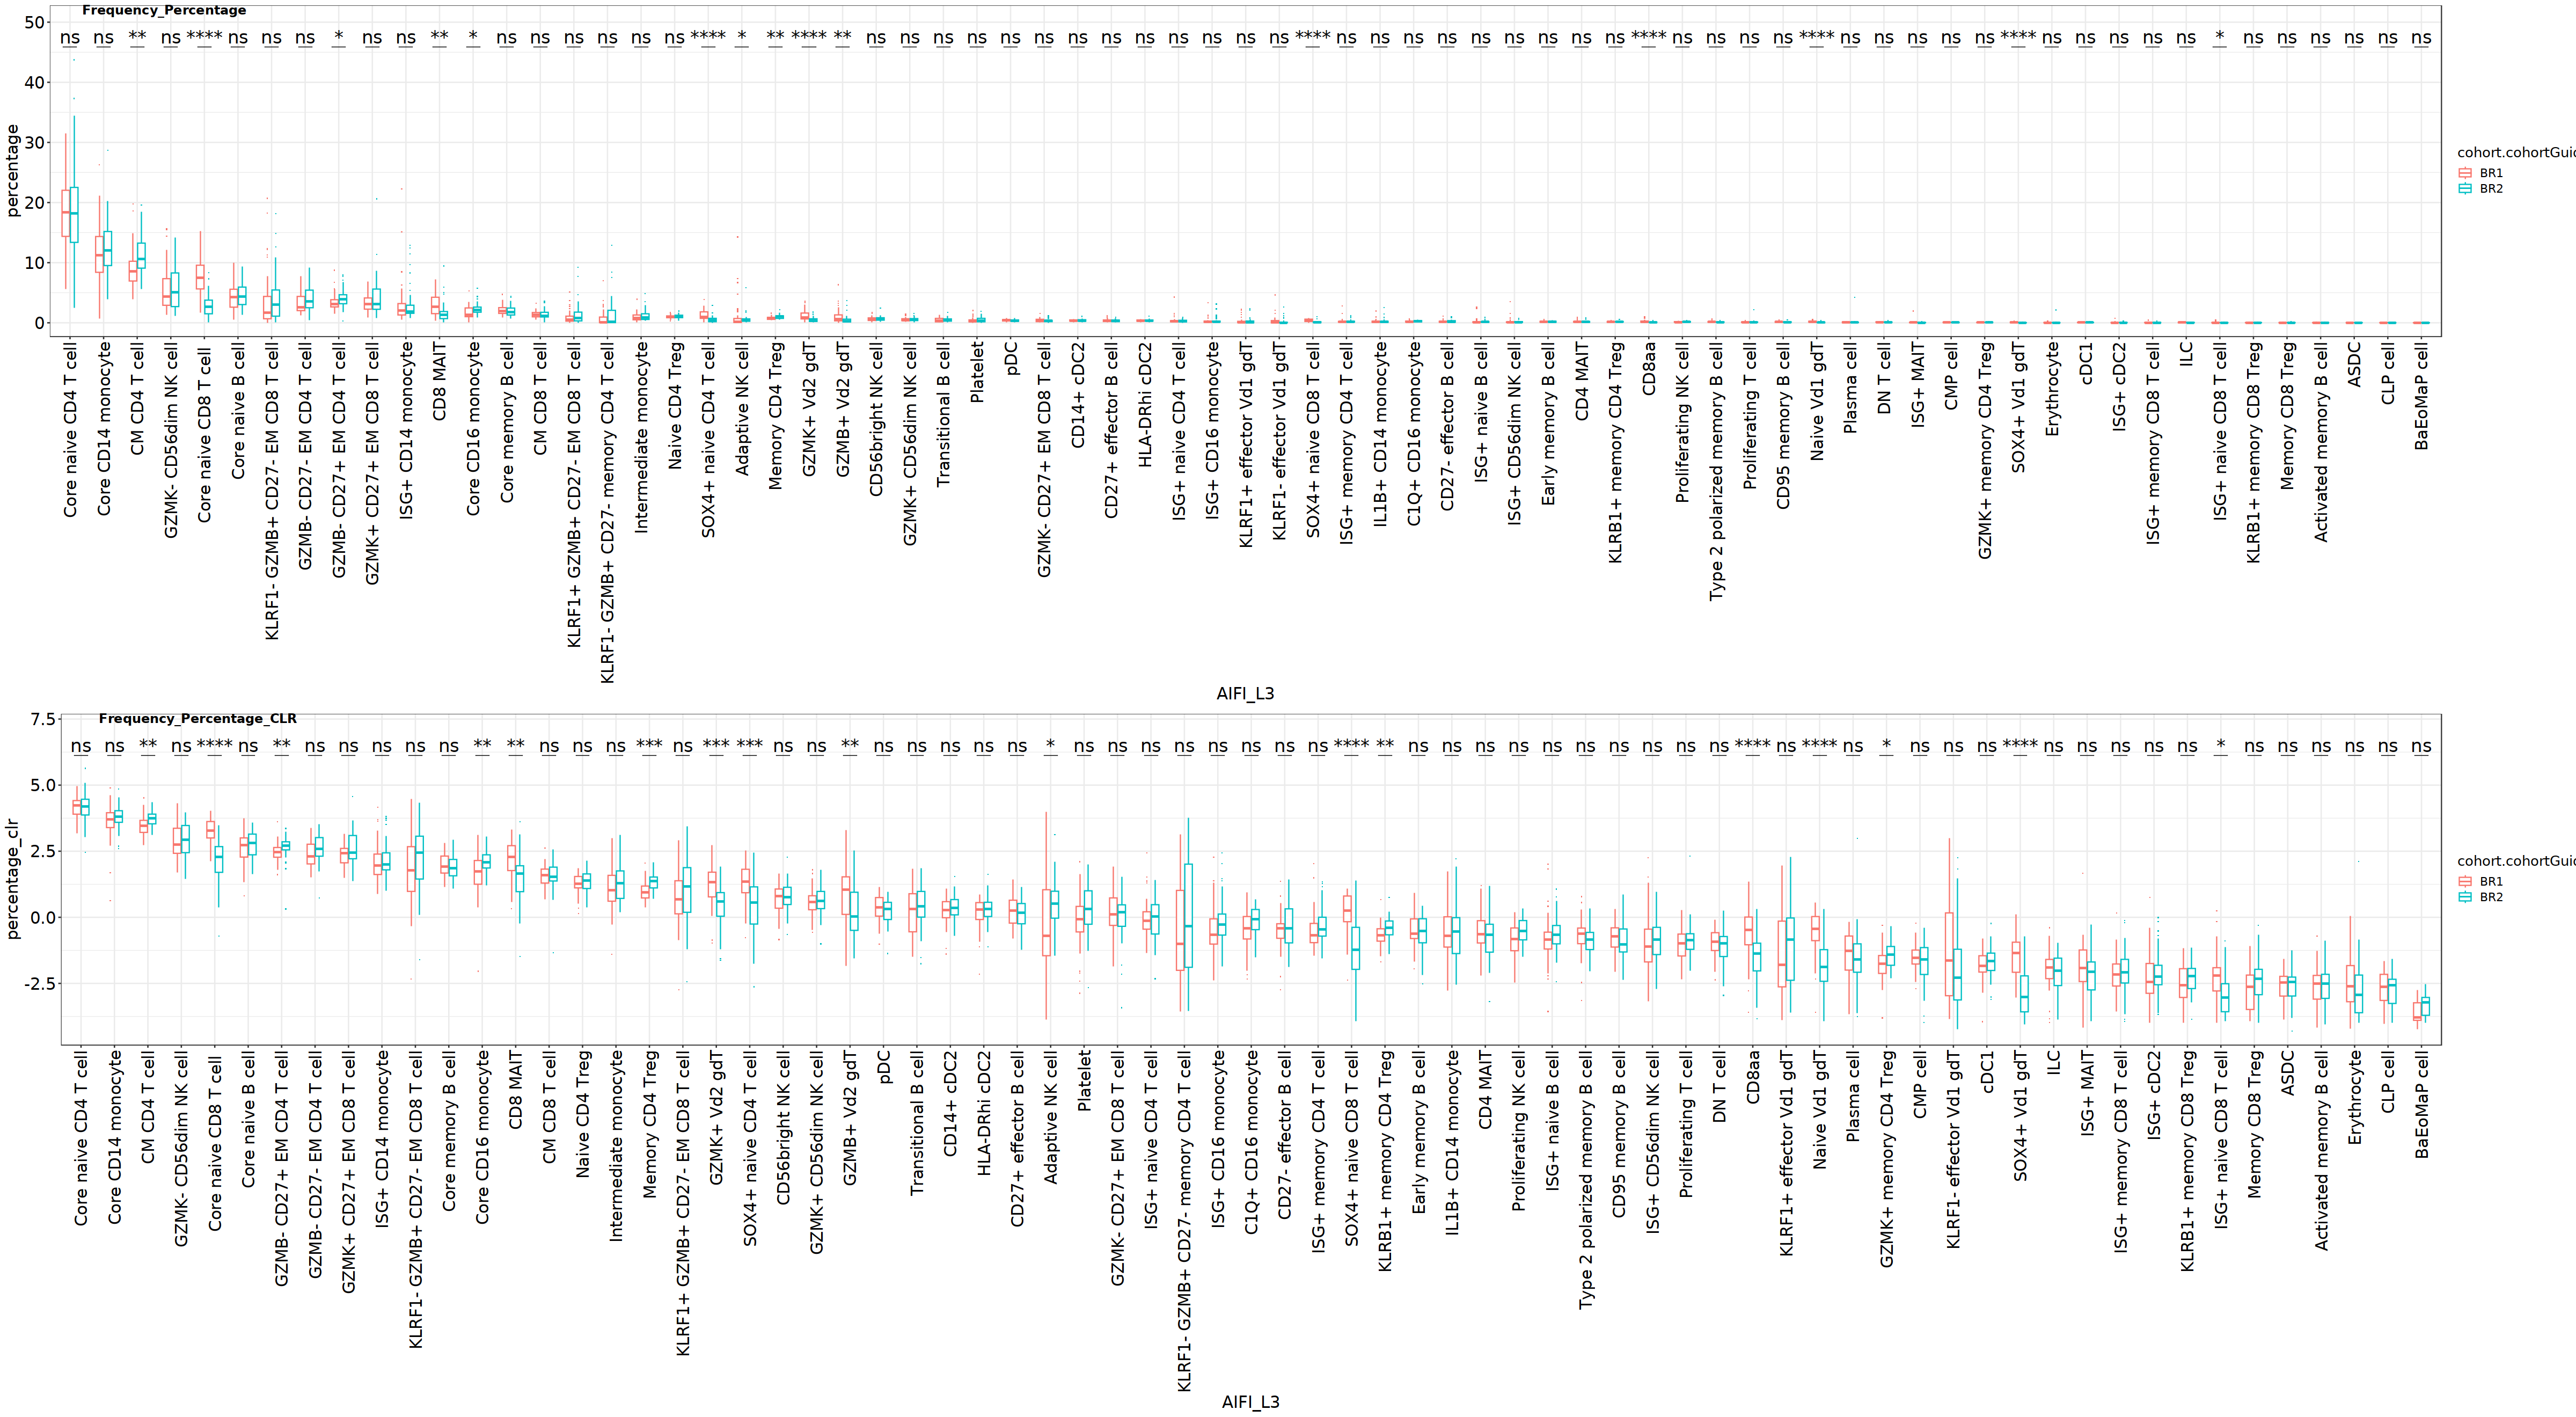

In [65]:
# Percentage comparing Age WITHOUT CMV seperation

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)


#Percentage CLR comparing Age WITHOUT CMV seperation
p5 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 22)
# Combine two plots vertically
combined_plot <- plot_grid(p4, p5, labels = c("Frequency_Percentage", "Frequency_Percentage_CLR"), ncol =1)

combined_plot


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


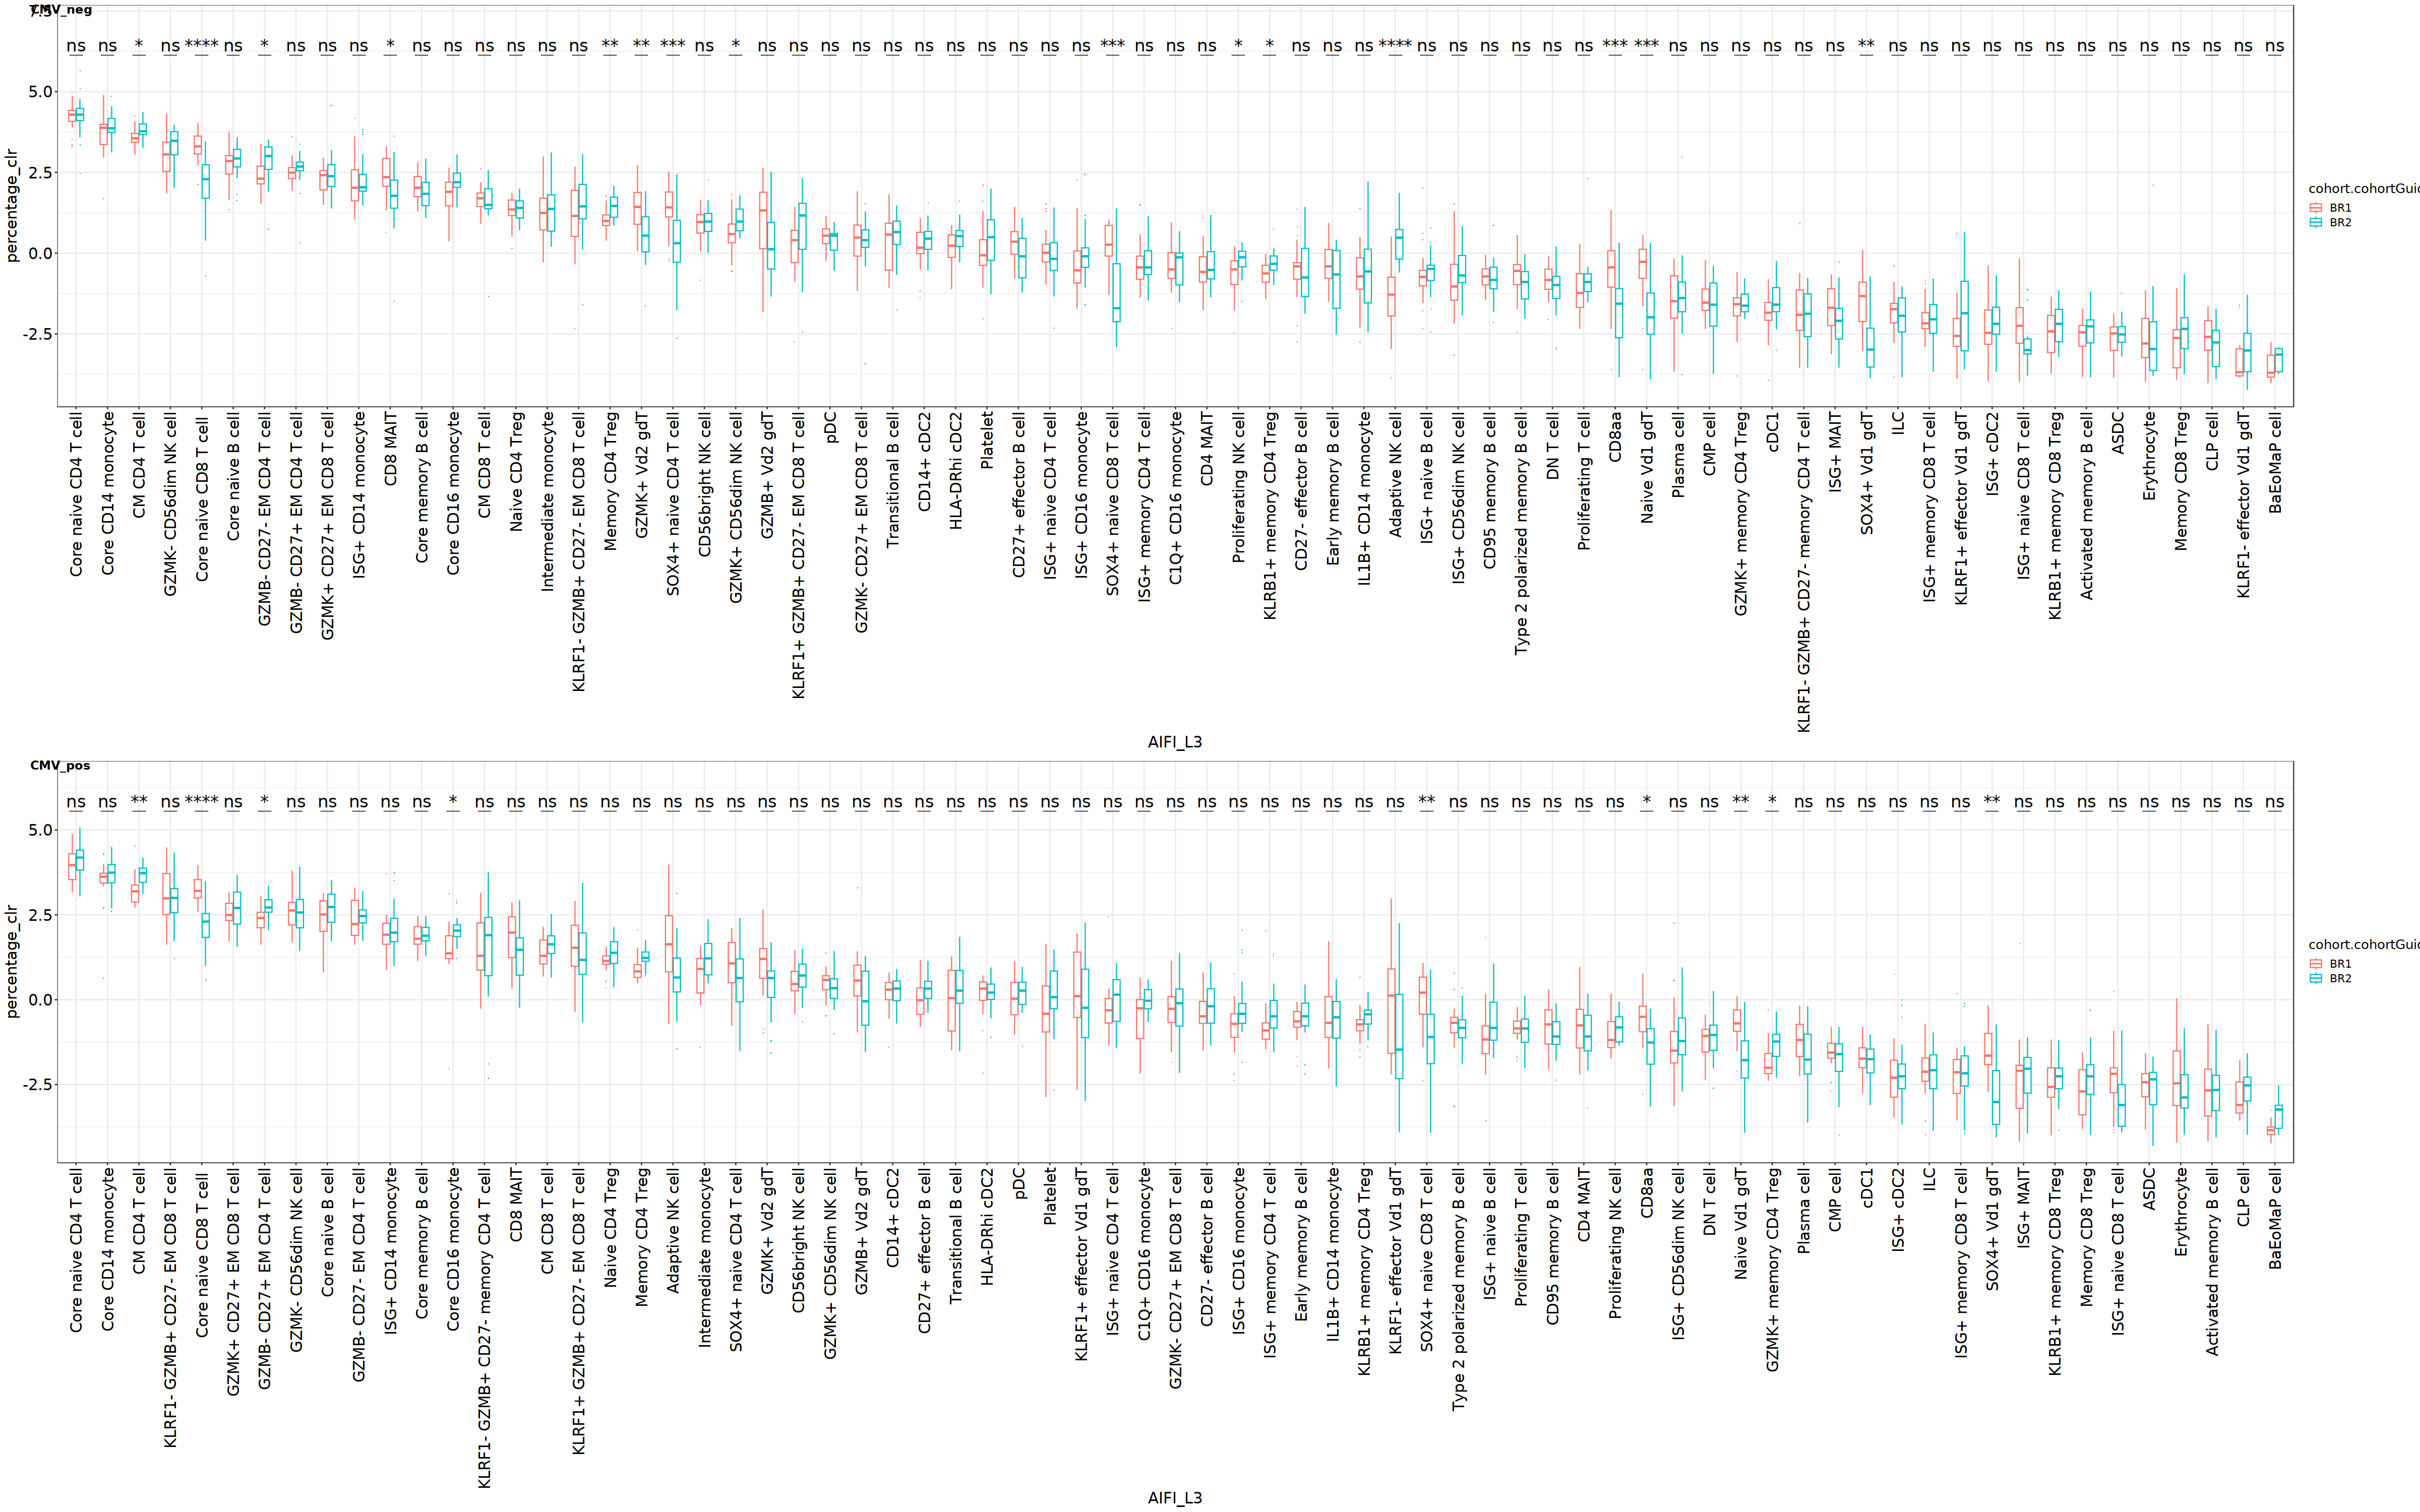

In [66]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

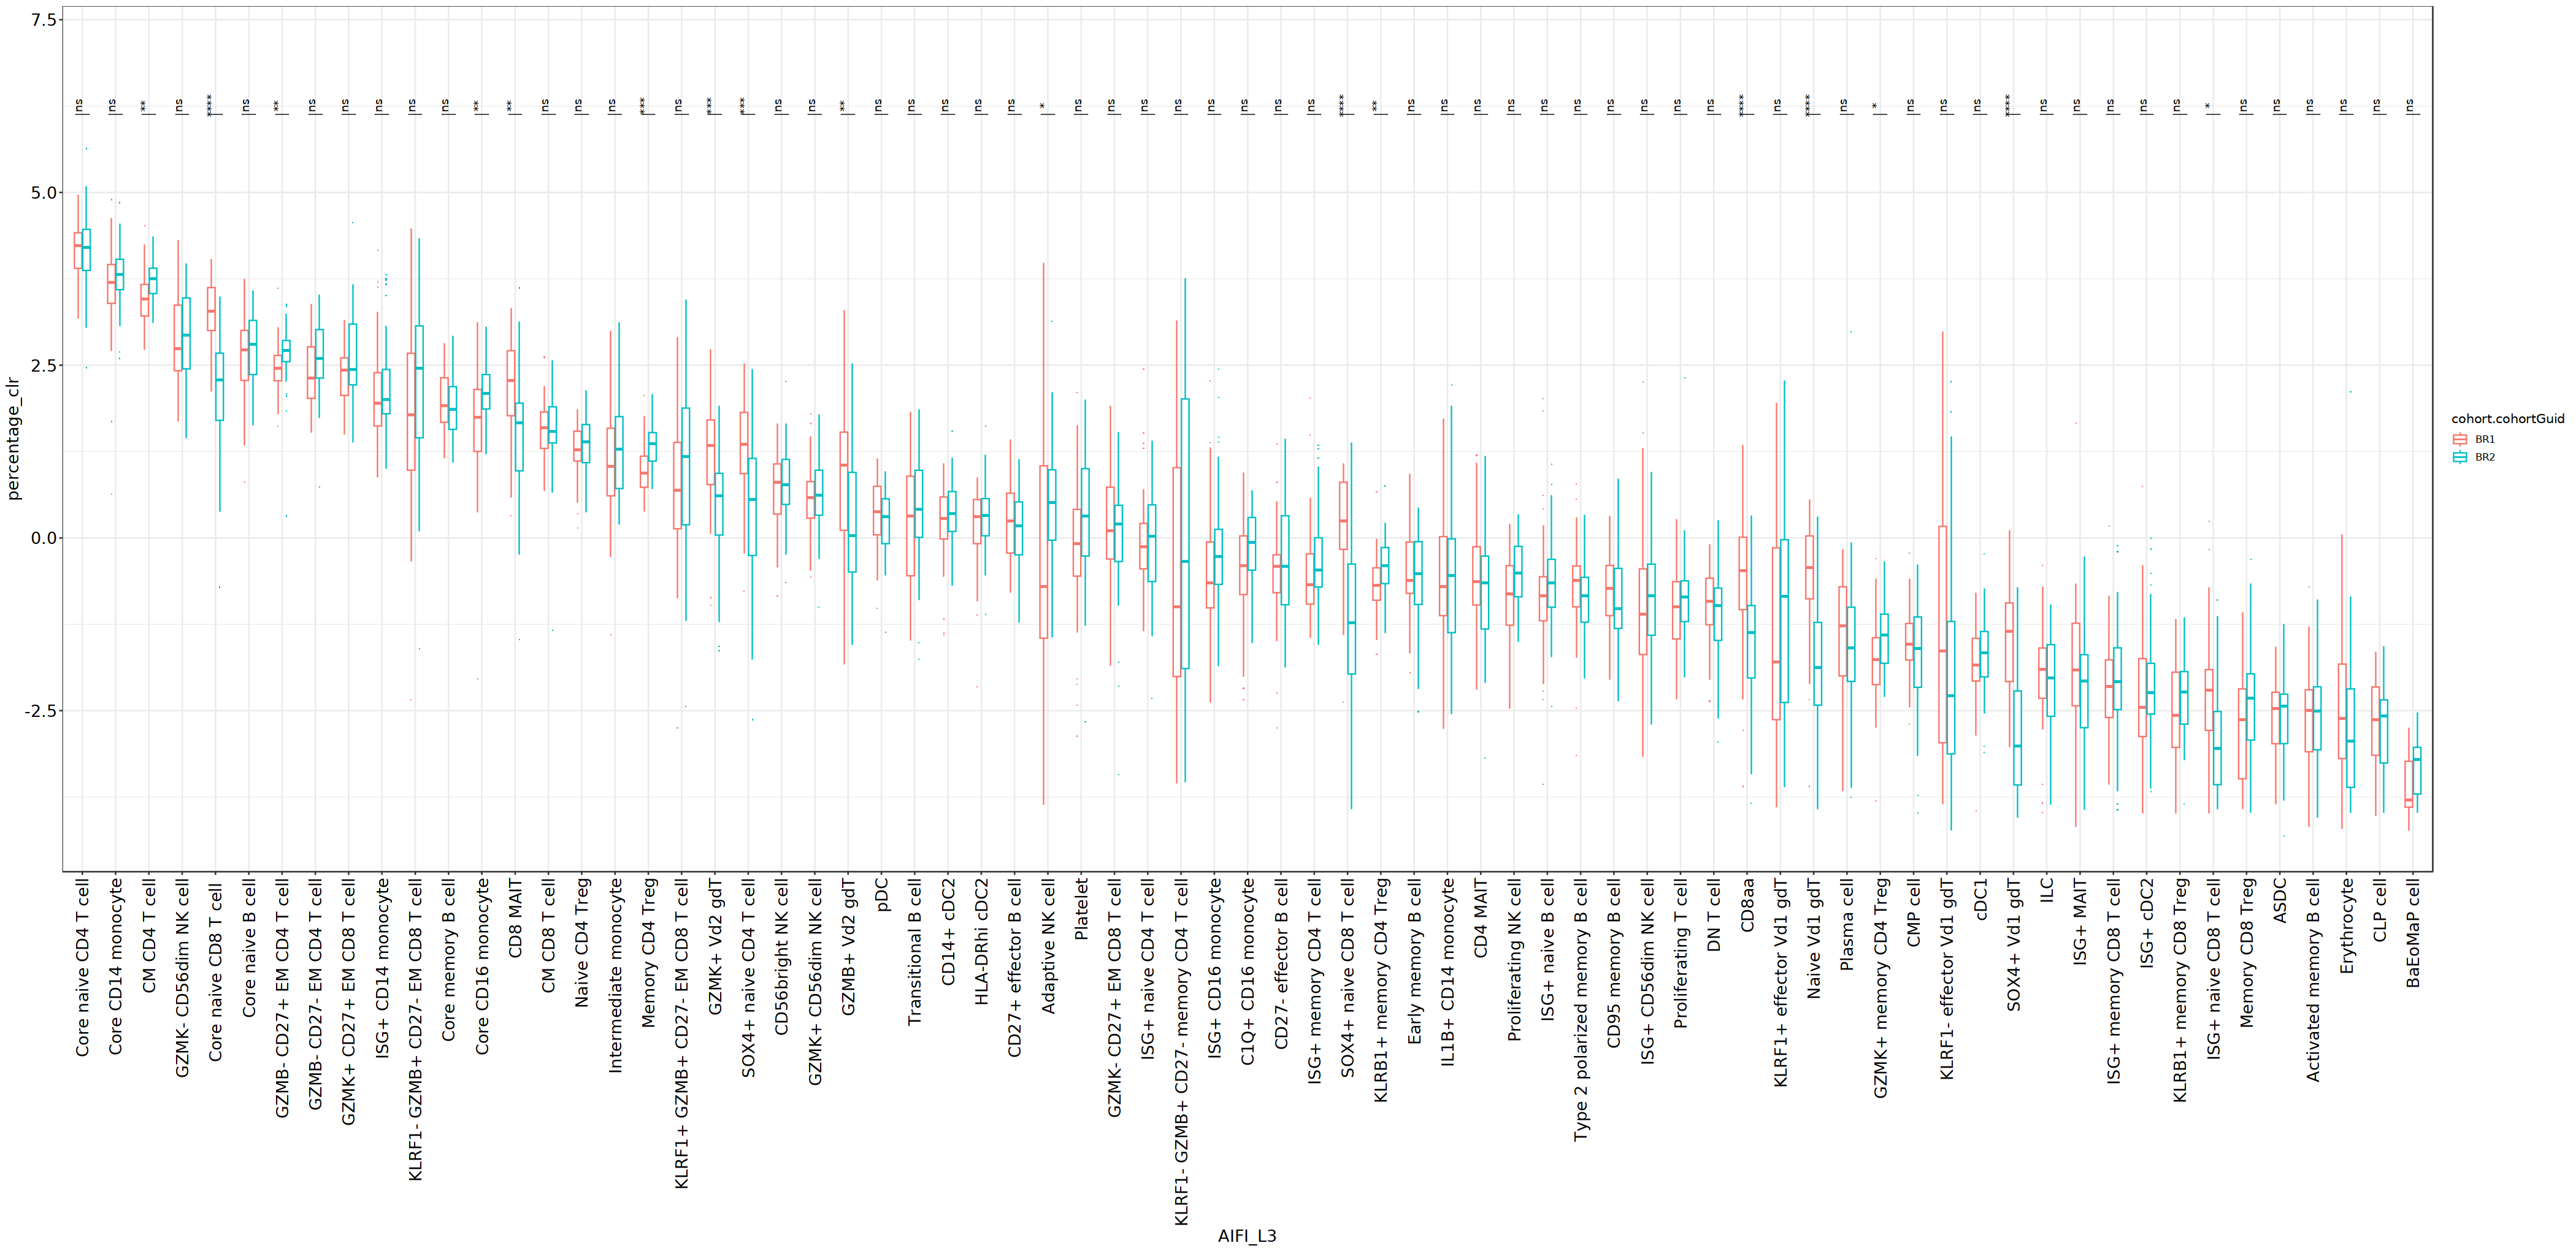

In [18]:
# Percentage- CLR comparing Age WITHOUT CMV seperation

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
#####Individual plot##########

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 100)

stat.test <- result %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid)


max_values<-result %>%
  group_by(AIFI_L3,CMV.IgG.Serology.Result.Interpretation) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result, aes(cohort.cohortGuid, percentage,color=cohort.cohortGuid)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~CMV.IgG.Serology.Result.Interpretation+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage-CLR comparsion by CMV (haven't executed)

options(repr.plot.width = 18, repr.plot.height = 12)

stat.test <- result %>% select(percentage_clr,celltypes,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(celltypes,CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid)

max_values<-result %>%
  group_by(celltypes,CMV.IgG.Serology.Result.Interpretation) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull()+1
stat.test$y.position<-max_values
ggplot(result , aes(cohort.cohortGuid, percentage_clr,color=cohort.cohortGuid)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+scale_color_d3()+
facet_wrap(~CMV.IgG.Serology.Result.Interpretation+celltypes,scale="free",ncol=7)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

In [ ]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 100)

stat.test <- result %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

# Comparsion within B cells(Percentage and Percentage CLR - AIFI Level 1 celltypes)¶

In [67]:
Bcell_df <- myeloid_df %>% filter(AIFI_L1 == 'B cell')

In [68]:
unique(Bcell_df$AIFI_L1)

[1] "B cell"

In [69]:
## Percentage of total

result_Bcell <- Bcell_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result_Bcell)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3                 subject.subjectGuid count percentage percentage_clr
1 Activated memory B cell BR1001              4     0.2263724  -2.423287     
2 Activated memory B cell BR1003              5     0.2967359  -2.198496     
3 Activated memory B cell BR1004              1     0.1157407  -3.250288     
4 Activated memory B cell BR1005              2     0.1912046  -2.504078     
5 Activated memory B cell BR1006              4     0.1989060  -2.254741     
6 Activated memory B cell BR1007              4     0.2877698  -2.440513

In [70]:
result_Bcell<-left_join(result_Bcell,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [ ]:
head(result_Bcell)

In [71]:
result_Bcell %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [ ]:
#############Individual Plots##################

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 20)

stat.test <- result_Bcell %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result_Bcell %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result_Bcell, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 20)

stat.test <- result_Bcell %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result_Bcell %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result_Bcell, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##############GLOBAL PLOTS##############################

In [ ]:
# Percentage comparing Age across CMV

#result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 14)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.adj.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


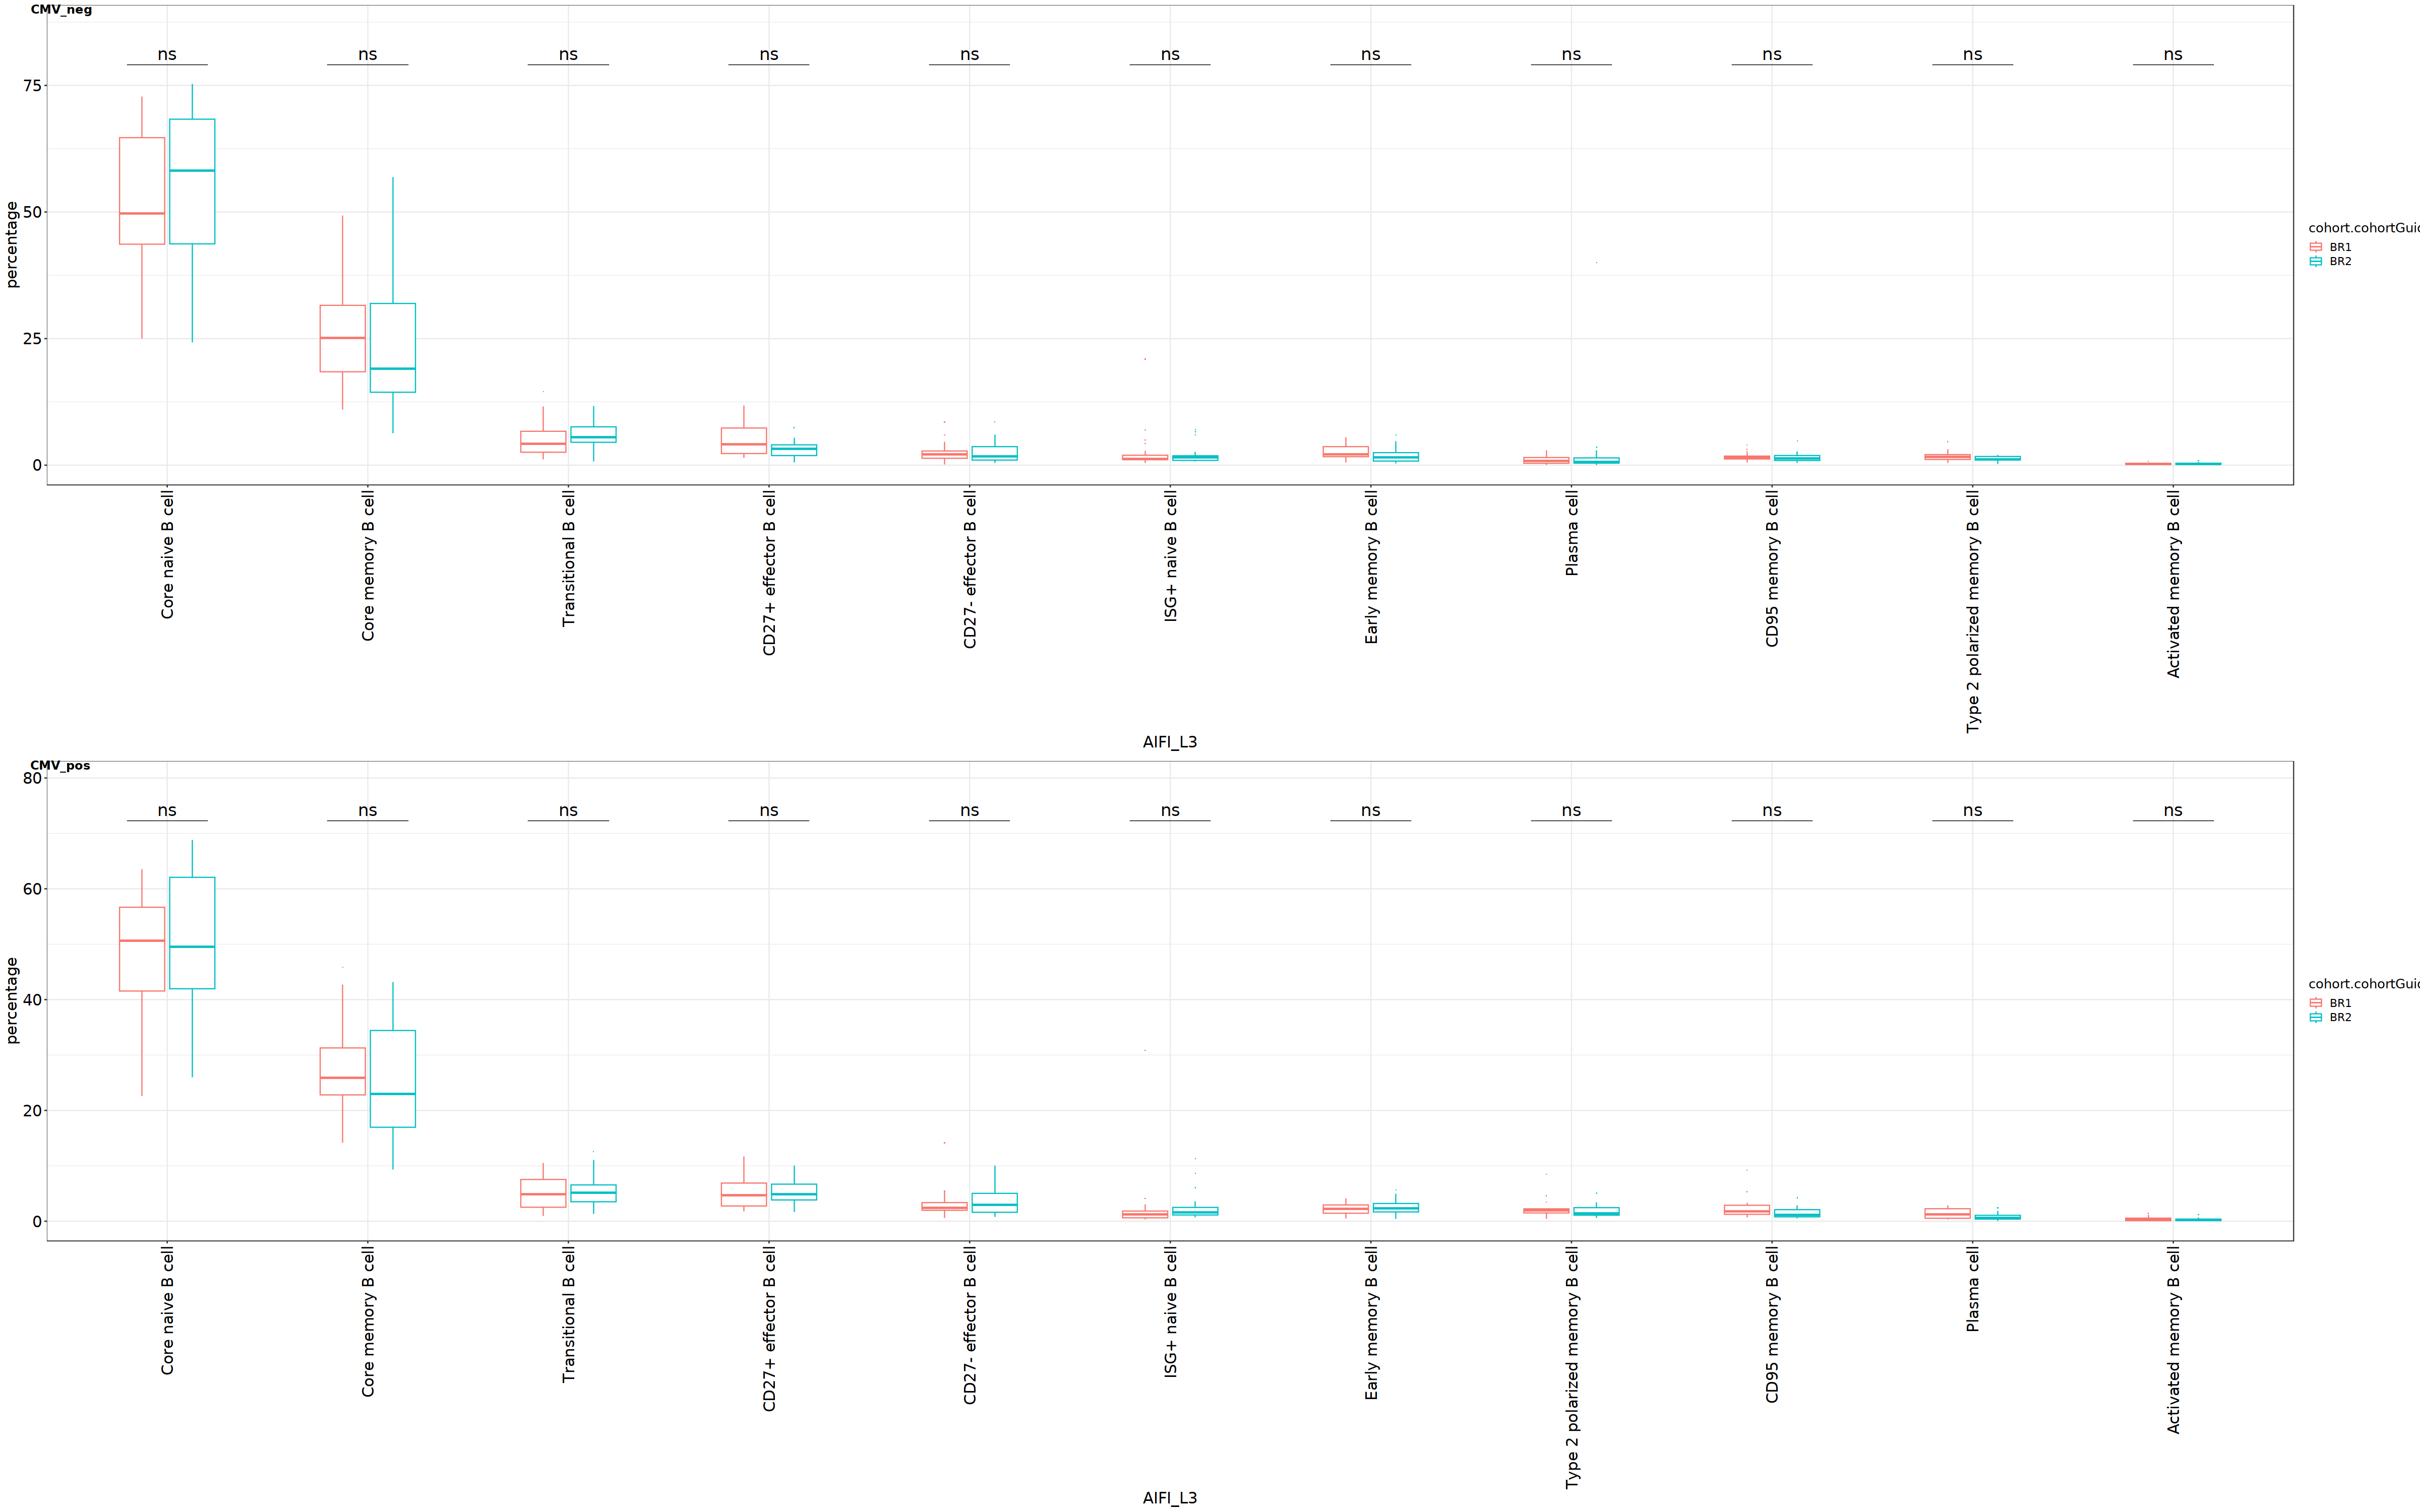

In [72]:
# Percentage comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################
#result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

In [ ]:
stat_test

In [ ]:
# Percentage- CLR comparing Age across CMV

#result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


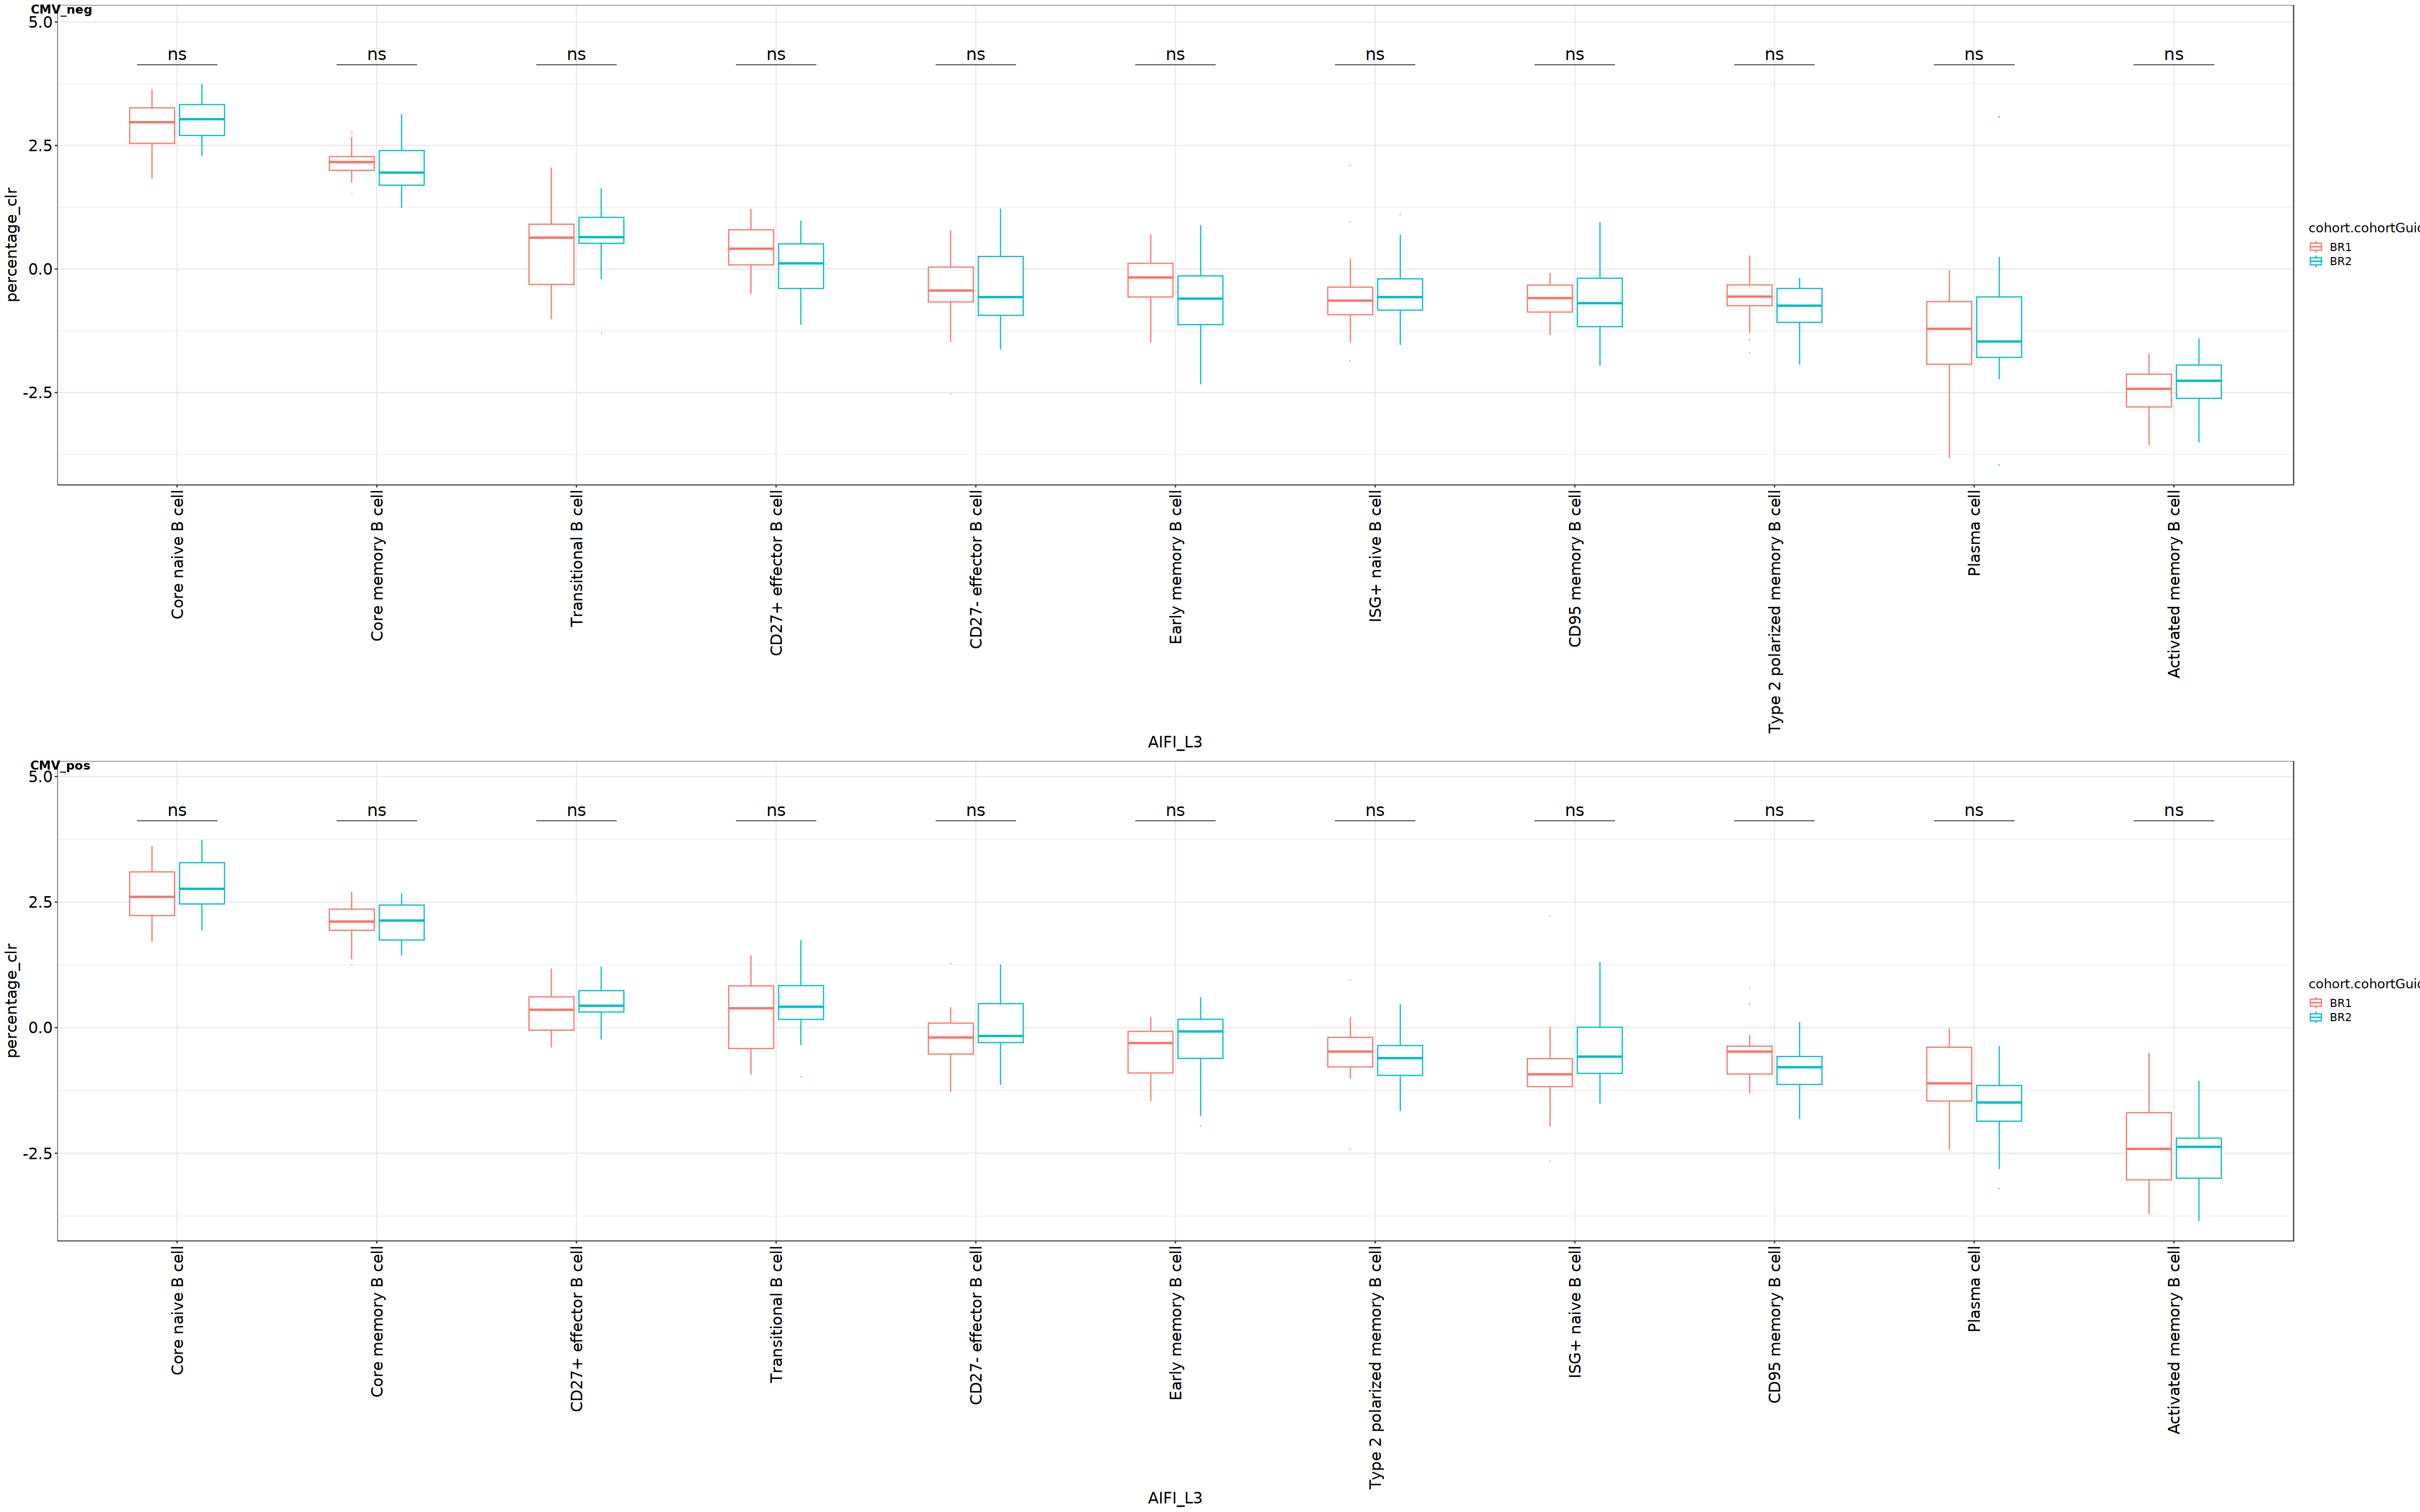

In [73]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################
#result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Bcell[result_Bcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

# Comparsion within T cell (Percentage and Percentage CLR - AIFI Level 1 celltypes)¶

In [74]:
Tcell_df <- myeloid_df %>% filter(AIFI_L1 == 'T cell')

In [75]:
unique(Tcell_df$AIFI_L1)

[1] "T cell"

In [76]:
## Percentage of total

result_Tcell <- Tcell_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result_Tcell)
head(Tcell_df)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3  subject.subjectGuid count percentage percentage_clr
1 CD4 MAIT BR1001              55    0.48941093 -0.2869015    
2 CD4 MAIT BR1002               8    0.06584362 -2.1593283    
3 CD4 MAIT BR1003              26    0.20722085 -1.1121389    
4 CD4 MAIT BR1004              42    0.32292788 -0.2297369    
5 CD4 MAIT BR1005              11    0.11689692 -1.3145878    
6 CD4 MAIT BR1006              23    0.23431133 -0.6821057

barcodes                        
cf71f47048b611ea8957bafe6d70929e cf71f47048b611ea8957bafe6d70929e
cf71fb7848b611ea8957bafe6d70929e cf71fb7848b611ea8957bafe6d70929e
cf7216a848b611ea8957bafe6d70929e cf7216a848b611ea8957bafe6d70929e
cf72178448b611ea8957bafe6d70929e cf72178448b611ea8957bafe6d70929e
cf7224c248b611ea8957bafe6d70929e cf7224c248b611ea8957bafe6d70929e
cf7226c048b611ea8957bafe6d70929e cf7226c048b611ea8957bafe6d70929e
                                 barcodes.1                       batch_id
cf71f47048b611ea8957bafe6d70929e cf71f47048b611ea8957bafe6d70929e B001    
cf71fb7848b611ea8957bafe6d70929e cf71fb7848b611ea8957bafe6d70929e B001    
cf7216a848b611ea8957bafe6d70929e cf7216a848b611ea8957bafe6d70929e B001    
cf72178448b611ea8957bafe6d70929e cf72178448b611ea8957bafe6d70929e B001    
cf7224c248b611ea8957bafe6d70929e cf7224c248b611ea8957bafe6d70929e B001    
cf7226c048b611ea8957bafe6d70929e cf7226c048b611ea8957bafe6d70929e B001    
                                 cell_name                    
cf71f47048b611ea8957bafe6d70929e weathered_pernicious_polliwog
cf71fb7848b611ea8957bafe6d70929e long_weakminded_roebuck      
cf7216a848b611ea8957bafe6d70929e bimetallic_returnable_pony   
cf72178448b611ea8957bafe6d70929e newsworthy_copacetic_halicore
cf7224c248b611ea8957bafe6d70929e chic_mahogany_caribou        
cf7226c048b611ea8957bafe6d70929e first_illegible_megaraptor   
                                 cell_uuid                        chip_id  
cf71f47048b611ea8957bafe6d70929e cf71f47048b611ea8957bafe6d70929e B001-P1C1
cf71fb7848b611ea8957bafe6d70929e cf71fb7848b611ea8957bafe6d70929e B001-P1C1
cf7216a848b611ea8957bafe6d70929e cf7216a848b611ea8957bafe6d70929e B001-P1C1
cf72178448b611ea8957bafe6d70929e cf72178448b611ea8957bafe6d70929e B001-P1C1
cf7224c248b611ea8957bafe6d70929e cf7224c248b611ea8957bafe6d70929e B001-P1C1
cf7226c048b611ea8957bafe6d70929e cf7226c048b611ea8957bafe6d70929e B001-P1C1
                                 hto_barcode     hto_category n_genes
cf71f47048b611ea8957bafe6d70929e TGATGGCCTATTGGG singlet      1081   
cf71fb7848b611ea8957bafe6d70929e TGATGGCCTATTGGG singlet      1118   
cf7216a848b611ea8957bafe6d70929e TGATGGCCTATTGGG singlet      1836   
cf72178448b611ea8957bafe6d70929e TGATGGCCTATTGGG singlet       928   
cf7224c248b611ea8957bafe6d70929e TGATGGCCTATTGGG singlet       951   
cf7226c048b611ea8957bafe6d70929e TGATGGCCTATTGGG singlet      1021   
                                 n_mito_umis ⋯ pct_counts_mito leiden
cf71f47048b611ea8957bafe6d70929e 115         ⋯ 4.032258        10    
cf71fb7848b611ea8957bafe6d70929e  77         ⋯ 2.071006         2    
cf7216a848b611ea8957bafe6d70929e 249         ⋯ 4.098091         2    
cf72178448b611ea8957bafe6d70929e  60         ⋯ 2.130682         1    
cf7224c248b611ea8957bafe6d70929e 122         ⋯ 5.640314         7    
cf7226c048b611ea8957bafe6d70929e 157         ⋯ 5.323839         4    
                                 leiden_resolution_1 leiden_resolution_1.5
cf71f47048b611ea8957bafe6d70929e 9                   11                   
cf71fb7848b611ea8957bafe6d70929e 7                    4                   
cf7216a848b611ea8957bafe6d70929e 6                    8                   
cf72178448b611ea8957bafe6d70929e 0                    1                   
cf7224c248b611ea8957bafe6d70929e 2                    6                   
cf7226c048b611ea8957bafe6d70929e 1                    4                   
                                 leiden_resolution_2 AIFI_L1 AIFI_L2          
cf71f47048b611ea8957bafe6d70929e 10                  T cell  MAIT             
cf71fb7848b611ea8957bafe6d70929e  3                  T cell  Memory CD4 T cell
cf7216a848b611ea8957bafe6d70929e  6                  T cell  Memory CD4 T cell
cf72178448b611ea8957bafe6d70929e  0                  T cell  Naive CD4 T cell 
cf7224c248b611ea8957bafe6d70929e  4                  T cell  Naive CD8 T cell 
cf7226c048b611ea8957bafe6d70929e  3                  T cell  Memory CD4 T cell
               

In [77]:
result_Tcell<-left_join(result_Tcell,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [78]:
head(result_Tcell)

AIFI_L3  subject.subjectGuid count percentage percentage_clr
1 CD4 MAIT BR1001              55    0.48941093 -0.2869015    
2 CD4 MAIT BR1002               8    0.06584362 -2.1593283    
3 CD4 MAIT BR1003              26    0.20722085 -1.1121389    
4 CD4 MAIT BR1004              42    0.32292788 -0.2297369    
5 CD4 MAIT BR1005              11    0.11689692 -1.3145878    
6 CD4 MAIT BR1006              23    0.23431133 -0.6821057    
  cohort.cohortGuid subject.biologicalSex
1 BR1               Female               
2 BR1               Male                 
3 BR1               Female               
4 BR1               Male                 
5 BR1               Female               
6 BR1               Male                 
  CMV.IgG.Serology.Result.Interpretation
1 Negative                              
2 Negative                              
3 Negative                              
4 Negative                              
5 Negative                              
6 Negative

In [79]:
result_Tcell %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 60)

stat.test <- result_Tcell %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result_Tcell %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result_Tcell, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 60)

stat.test <- result_Tcell %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result_Tcell %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result_Tcell, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##############GLOBAL PLOTS##############################

In [ ]:
# Percentage comparing Age across CMV

#result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test

In [ ]:
# Percentage- CLR comparing Age across CMV

result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


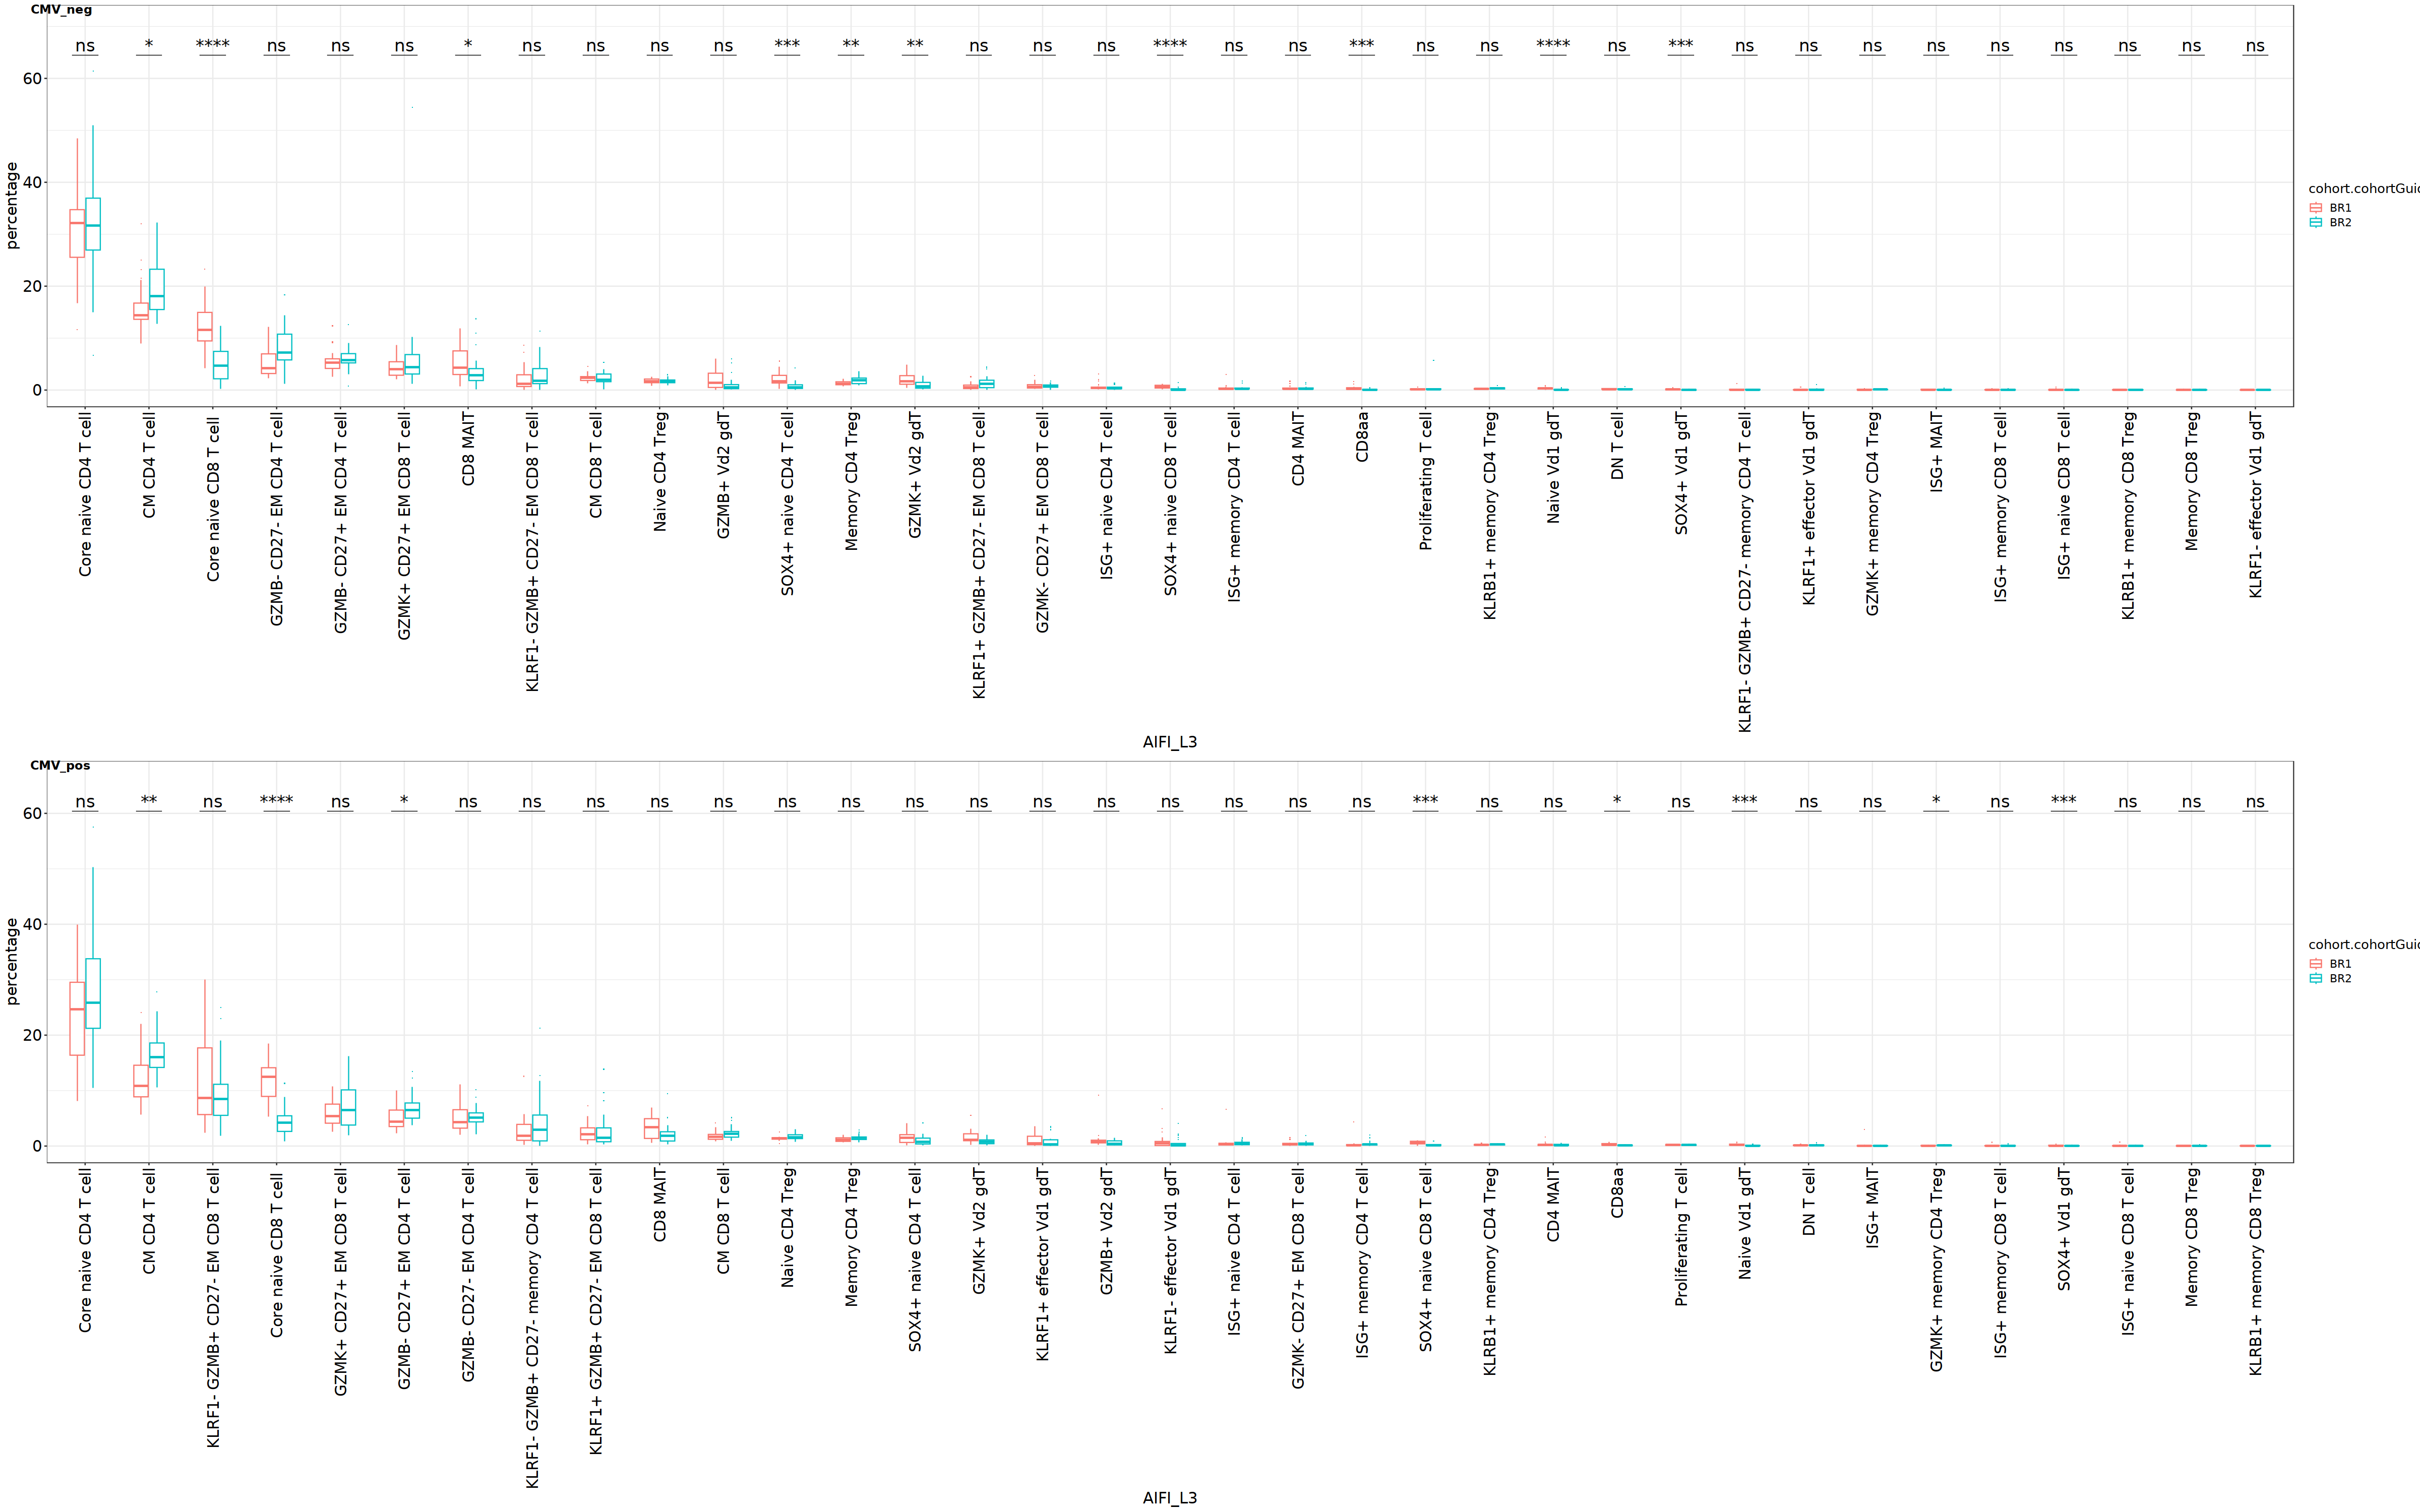

In [82]:
# Percentage-comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################
#result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


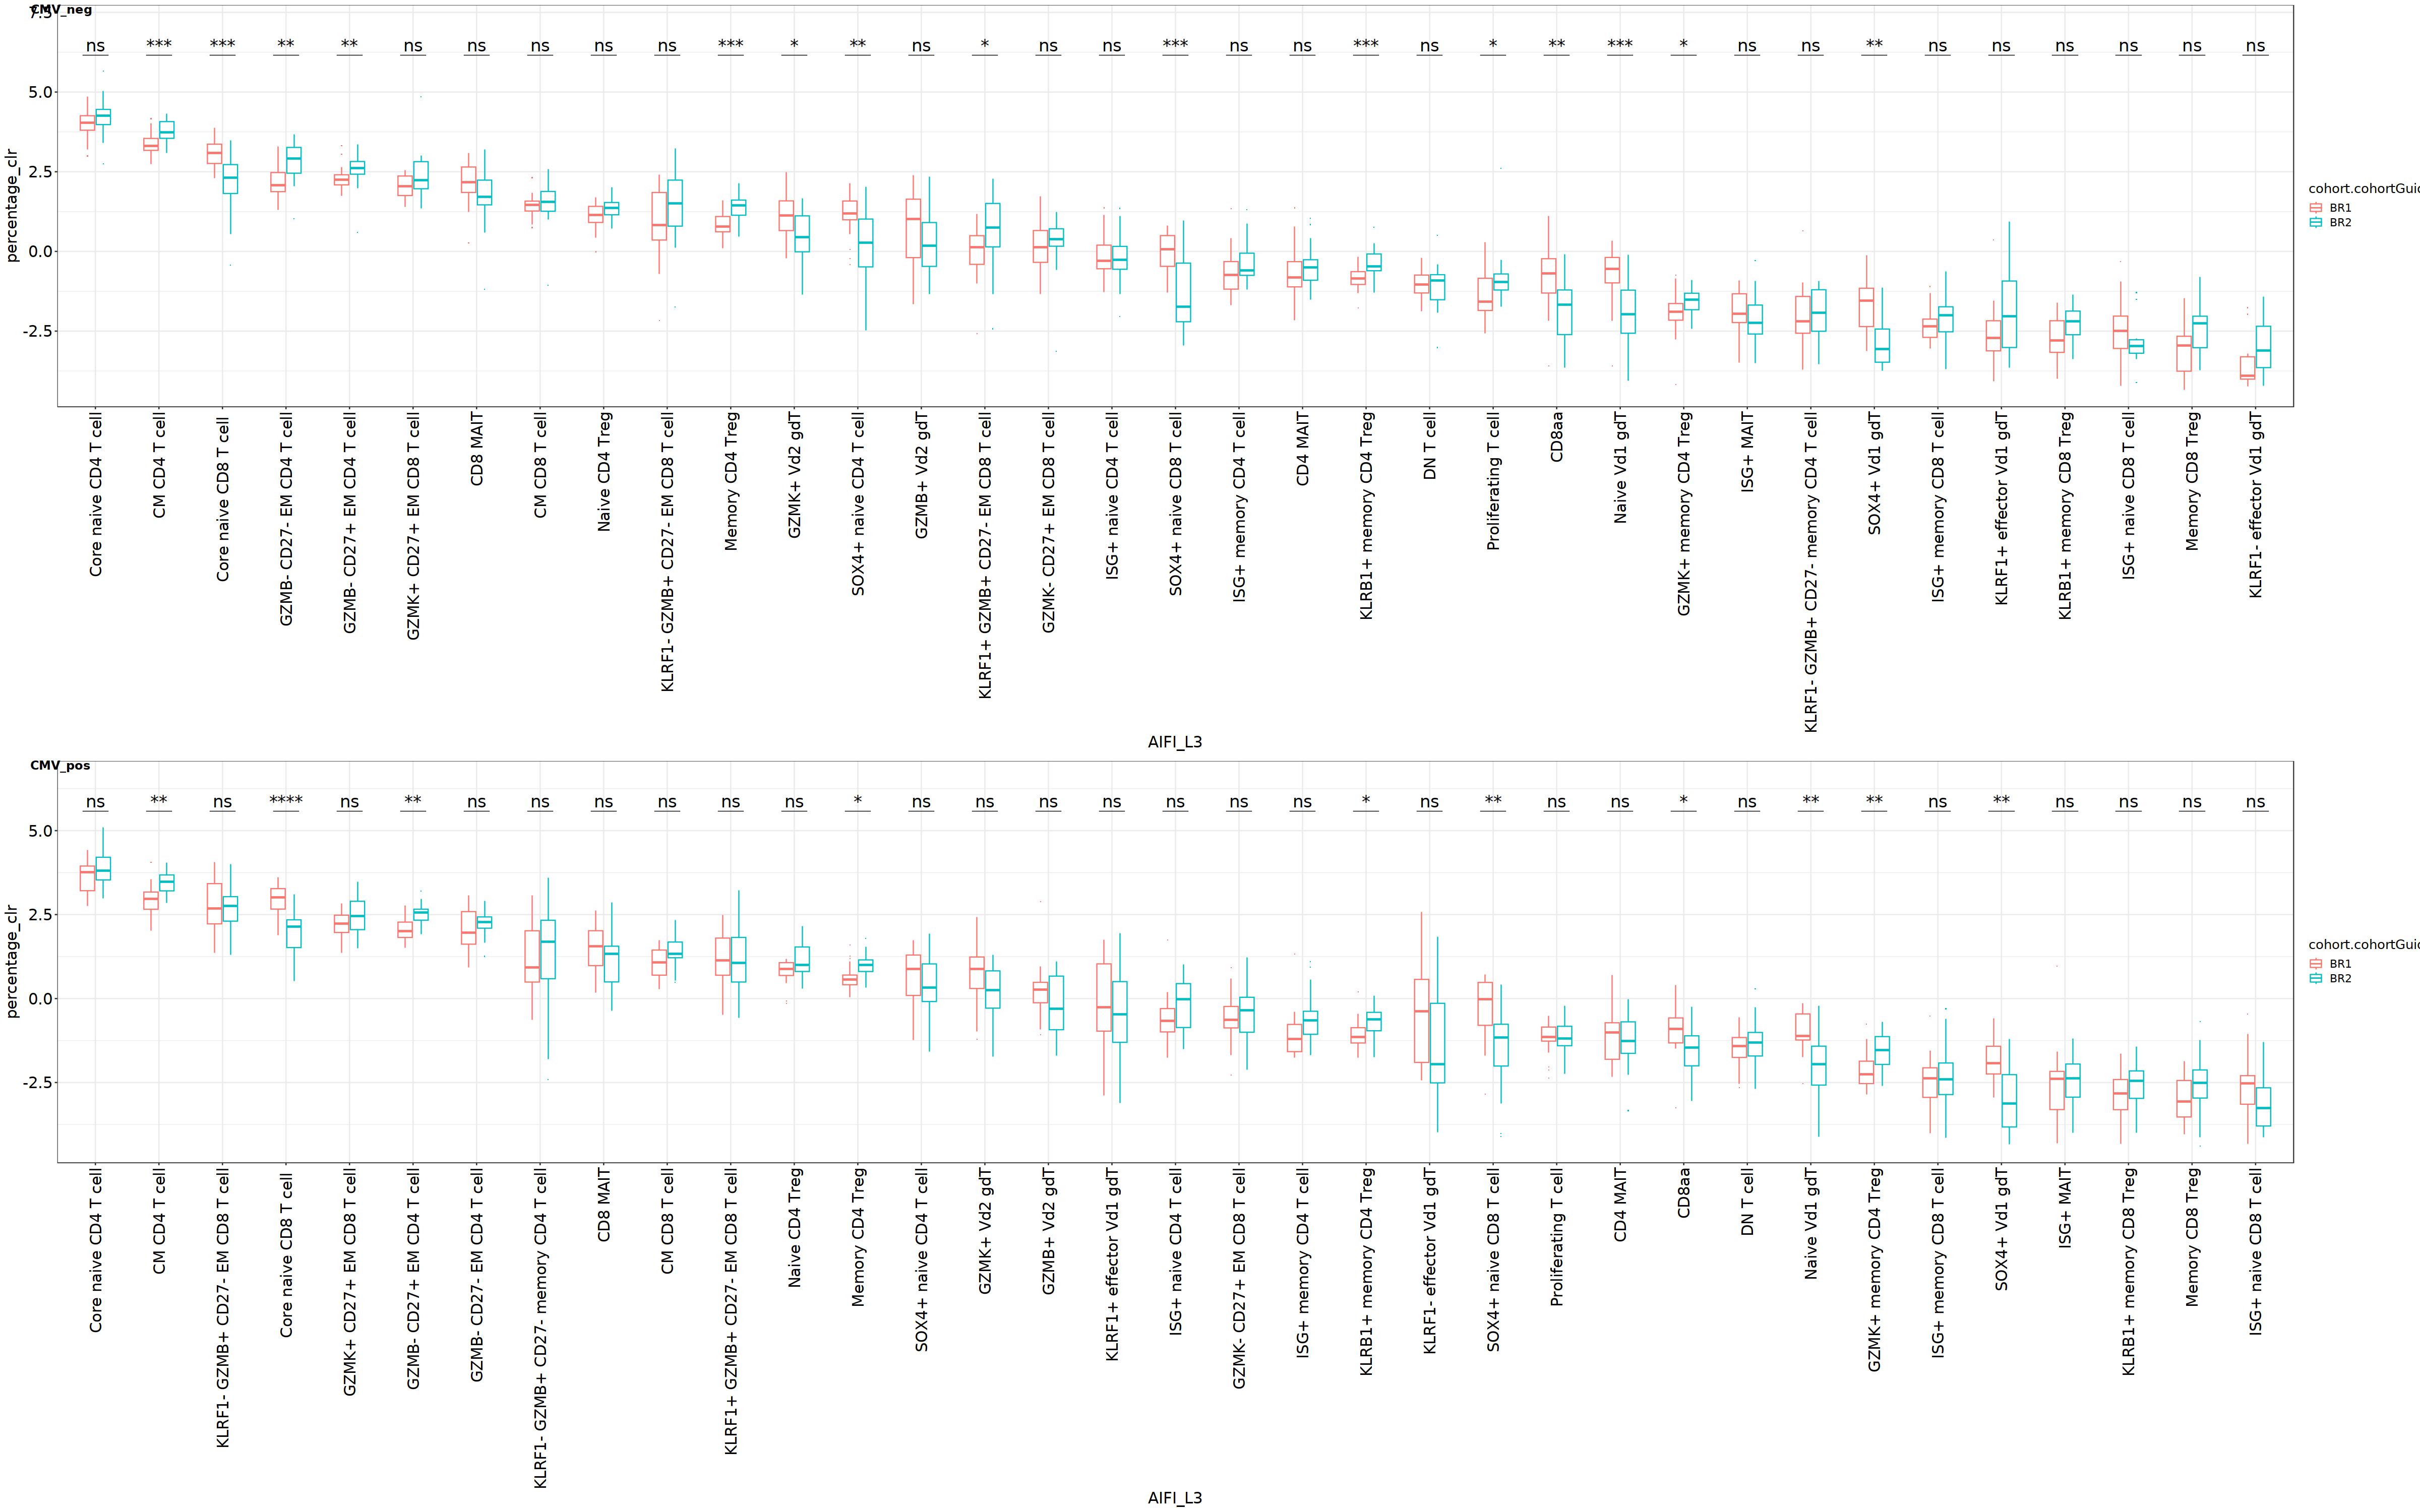

In [81]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################
#result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result_Tcell[result_Tcell$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

In [ ]:
stat_test

# Comparsion within Monocyte  (Percentage and Percentage CLR - AIFI Level 1 celltypes)

In [83]:
monocyte_df <- myeloid_df %>% filter(AIFI_L1 == 'Monocyte')

In [84]:
unique(monocyte_df$AIFI_L1)

[1] "Monocyte"

In [85]:
## Percentage of total

result_monocyte <- monocyte_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result_monocyte)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3            subject.subjectGuid count percentage percentage_clr
1 C1Q+ CD16 monocyte BR1001              117   2.9396985  -0.501638     
2 C1Q+ CD16 monocyte BR1002               20   0.5844535  -1.842195     
3 C1Q+ CD16 monocyte BR1003               41   1.1801957  -1.767540     
4 C1Q+ CD16 monocyte BR1004                4   0.2144772  -3.079874     
5 C1Q+ CD16 monocyte BR1005               25   0.3788453  -2.029338     
6 C1Q+ CD16 monocyte BR1006               45   1.2142472  -1.339048

In [86]:
result_monocyte<-left_join(result_monocyte,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [87]:
head(result_monocyte)

AIFI_L3            subject.subjectGuid count percentage percentage_clr
1 C1Q+ CD16 monocyte BR1001              117   2.9396985  -0.501638     
2 C1Q+ CD16 monocyte BR1002               20   0.5844535  -1.842195     
3 C1Q+ CD16 monocyte BR1003               41   1.1801957  -1.767540     
4 C1Q+ CD16 monocyte BR1004                4   0.2144772  -3.079874     
5 C1Q+ CD16 monocyte BR1005               25   0.3788453  -2.029338     
6 C1Q+ CD16 monocyte BR1006               45   1.2142472  -1.339048     
  cohort.cohortGuid subject.biologicalSex
1 BR1               Female               
2 BR1               Male                 
3 BR1               Female               
4 BR1               Male                 
5 BR1               Female               
6 BR1               Male                 
  CMV.IgG.Serology.Result.Interpretation
1 Negative                              
2 Negative                              
3 Negative                              
4 Negative                              
5 Negative                              
6 Negative

In [88]:
result_monocyte %>% filter(subject.subjectGuid == "BR1006") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 15)

stat.test <- result_monocyte %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result_monocyte %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result_monocyte, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 15)

stat.test <- result_monocyte %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result_monocyte %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(result_monocyte, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##############GLOBAL PLOTS##############################

In [ ]:
# Percentage comparing Age across CMV

result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 0, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test

In [ ]:
# Percentage- CLR comparing Age across CMV

result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


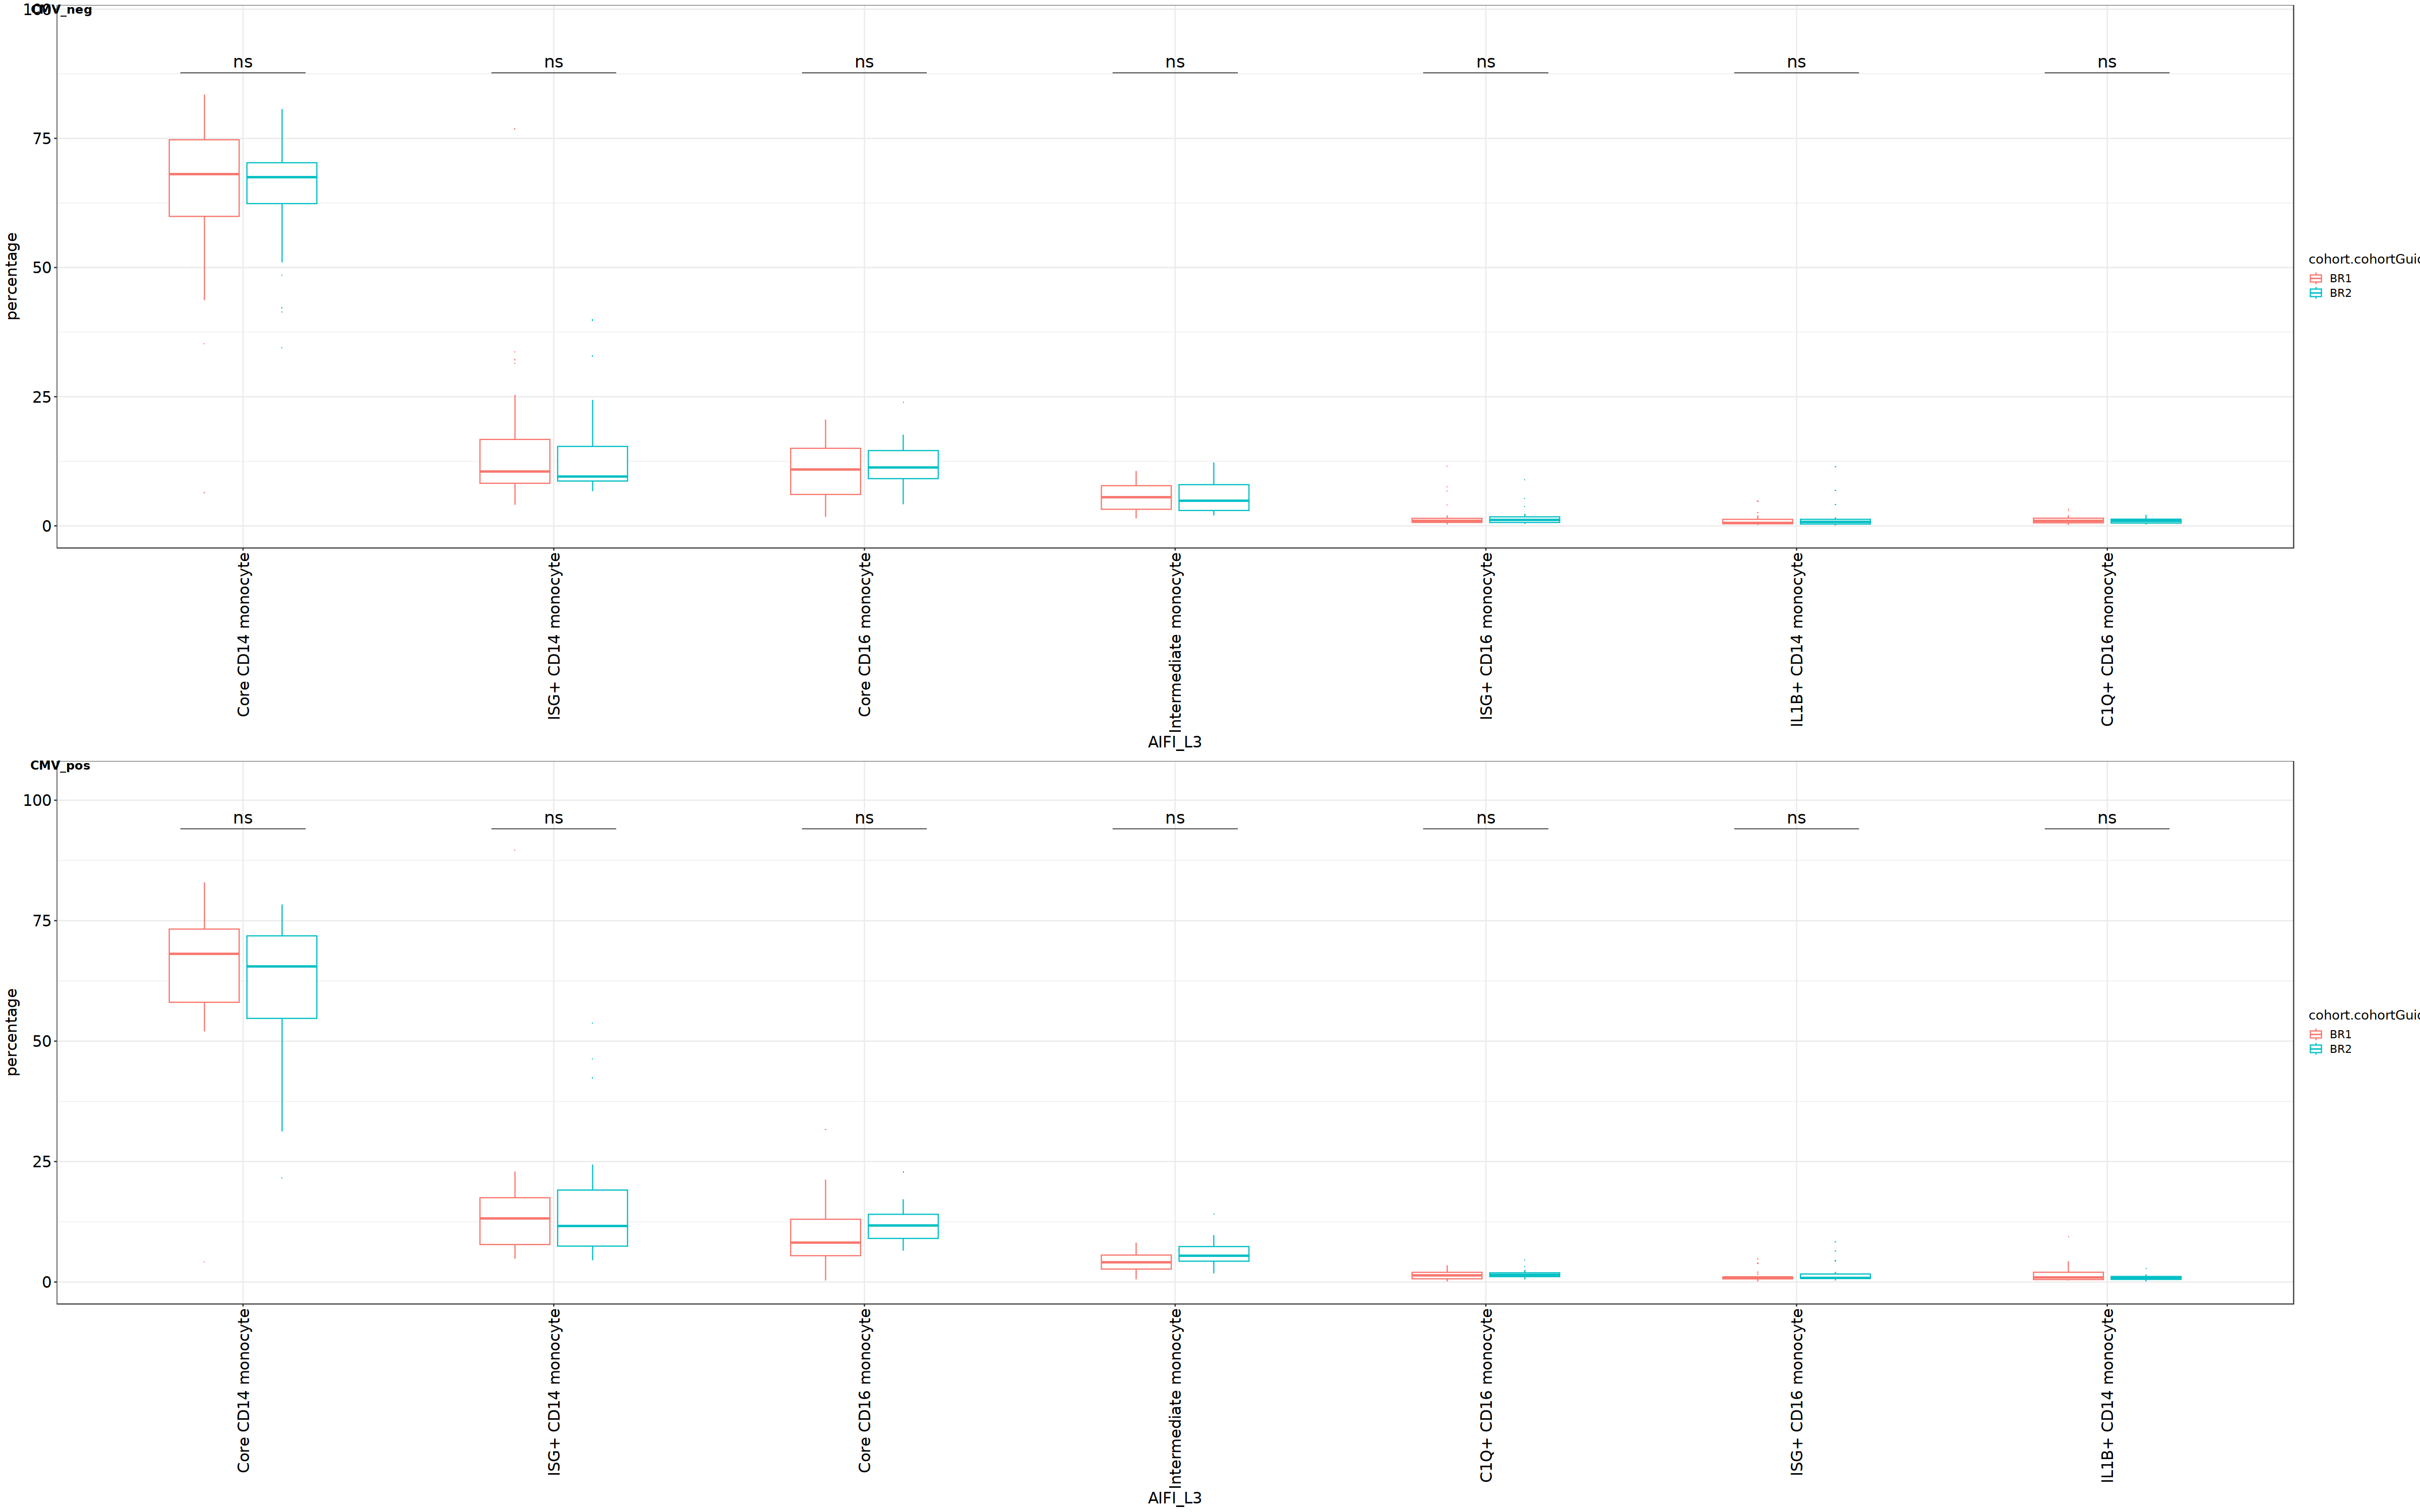

In [89]:
# Percentage-comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]


stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


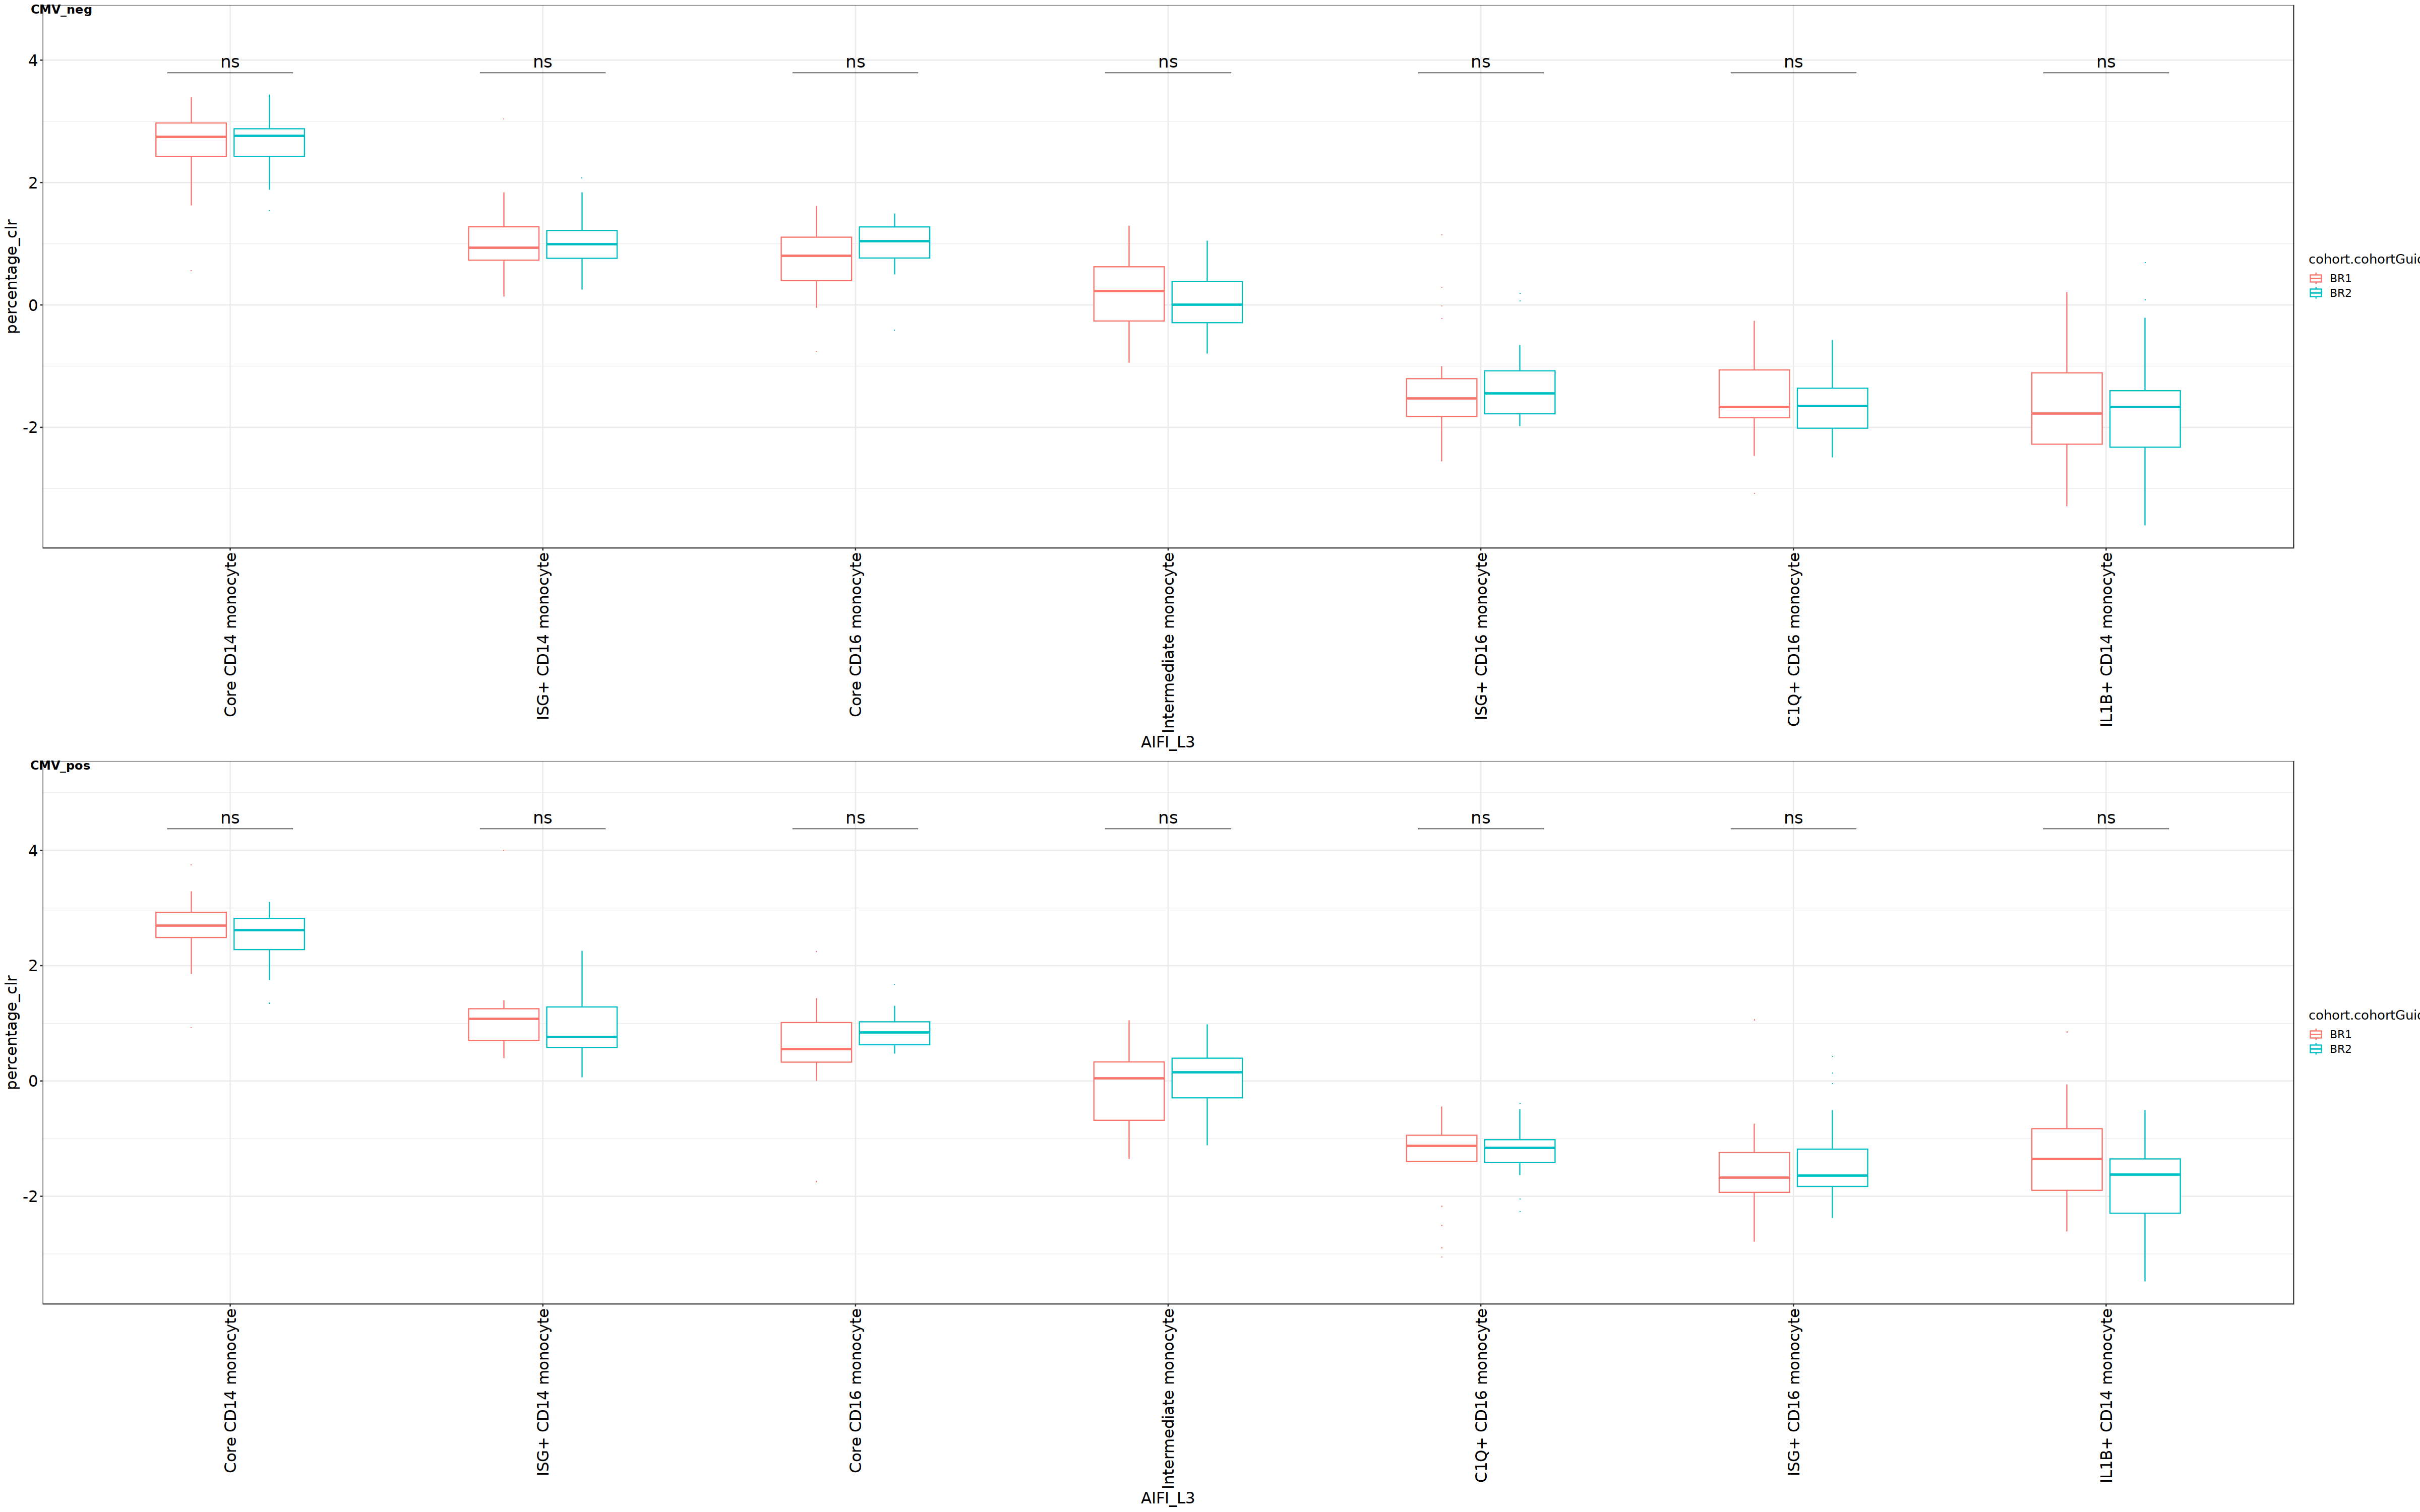

In [90]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- result_monocyte[result_monocyte$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

In [ ]:
stat_test

# Comparsion within DC (Percentage and Percentage CLR - AIFI Level 1 celltypes)

In [115]:
DC_df <- myeloid_df %>% filter(AIFI_L1 == 'DC')

In [116]:
unique(DC_df$AIFI_L1)

[1] "DC"

In [117]:
## Percentage of total

DC_df <- DC_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(DC_df)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3 subject.subjectGuid count percentage percentage_clr
1 ASDC    BR1001              6     2.352941   -1.245945     
2 ASDC    BR1002              5     1.373626   -1.468424     
3 ASDC    BR1003              4     1.716738   -1.765055     
4 ASDC    BR1004              3     1.321586   -1.798546     
5 ASDC    BR1005              5     1.915709   -1.164980     
6 ASDC    BR1006              4     1.562500   -1.552766

In [118]:

# global_l3_results = data.table::data.table(rbind(DC_df, NK_df, result_Bcell,
#       result_Tcell, result_monocyte,
#     Progenitor_df))

### Find the p-value for all l3
### correct the p-value using BH
### join the results to the global table
### plot the pre-calculated results 

# ggplot(global_l3_results,
#        aes(x=reorder(AIFI_L3,  -percentage_clr, mean),
#            y=percentage_clr,
#            fill=cohort.cohortGuid)) +geom_boxplot(scale='width')+geom_pwc(
#     aes(group = cohort.cohortGuid),
#     tip.length = 0, p.adjust.method = "BH",
#     method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
#   ) +
# theme_minimal()+
# theme(text=element_text(size=12),
#       axis.text.x=element_text(angle=90))

In [119]:
DC_df<-left_join(DC_df,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [120]:
head(DC_df)

AIFI_L3 subject.subjectGuid count percentage percentage_clr cohort.cohortGuid
1 ASDC    BR1001              6     2.352941   -1.245945      BR1              
2 ASDC    BR1002              5     1.373626   -1.468424      BR1              
3 ASDC    BR1003              4     1.716738   -1.765055      BR1              
4 ASDC    BR1004              3     1.321586   -1.798546      BR1              
5 ASDC    BR1005              5     1.915709   -1.164980      BR1              
6 ASDC    BR1006              4     1.562500   -1.552766      BR1              
  subject.biologicalSex CMV.IgG.Serology.Result.Interpretation
1 Female                Negative                              
2 Male                  Negative                              
3 Female                Negative                              
4 Male                  Negative                              
5 Female                Negative                              
6 Male                  Negative

In [121]:
DC_df %>% filter(subject.subjectGuid == "BR1007") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 15)

stat.test <- DC_df %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-DC_df %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(DC_df, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 15)

stat.test <- DC_df %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-DC_df %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull() + 1


stat.test$y.position<-max_values


my_plot <- ggplot(DC_df, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##############GLOBAL PLOTS##############################

In [ ]:
# Percentage comparing Age across CMV

result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  #select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


wdf <- result_cohort %>%
       group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
       do(p = wilcox.test(percentage ~ cohort.cohortGuid, data = .)$p.value) %>%
       mutate(p = unlist(p)) %>%
       as.data.frame() %>%
       mutate(adjp = p.adjust(p, method = "BH")) %>%
       arrange(p)



# Create the plot
options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 0, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test
wdf

In [ ]:
# Percentage- CLR comparing Age across CMV

#result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 0, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


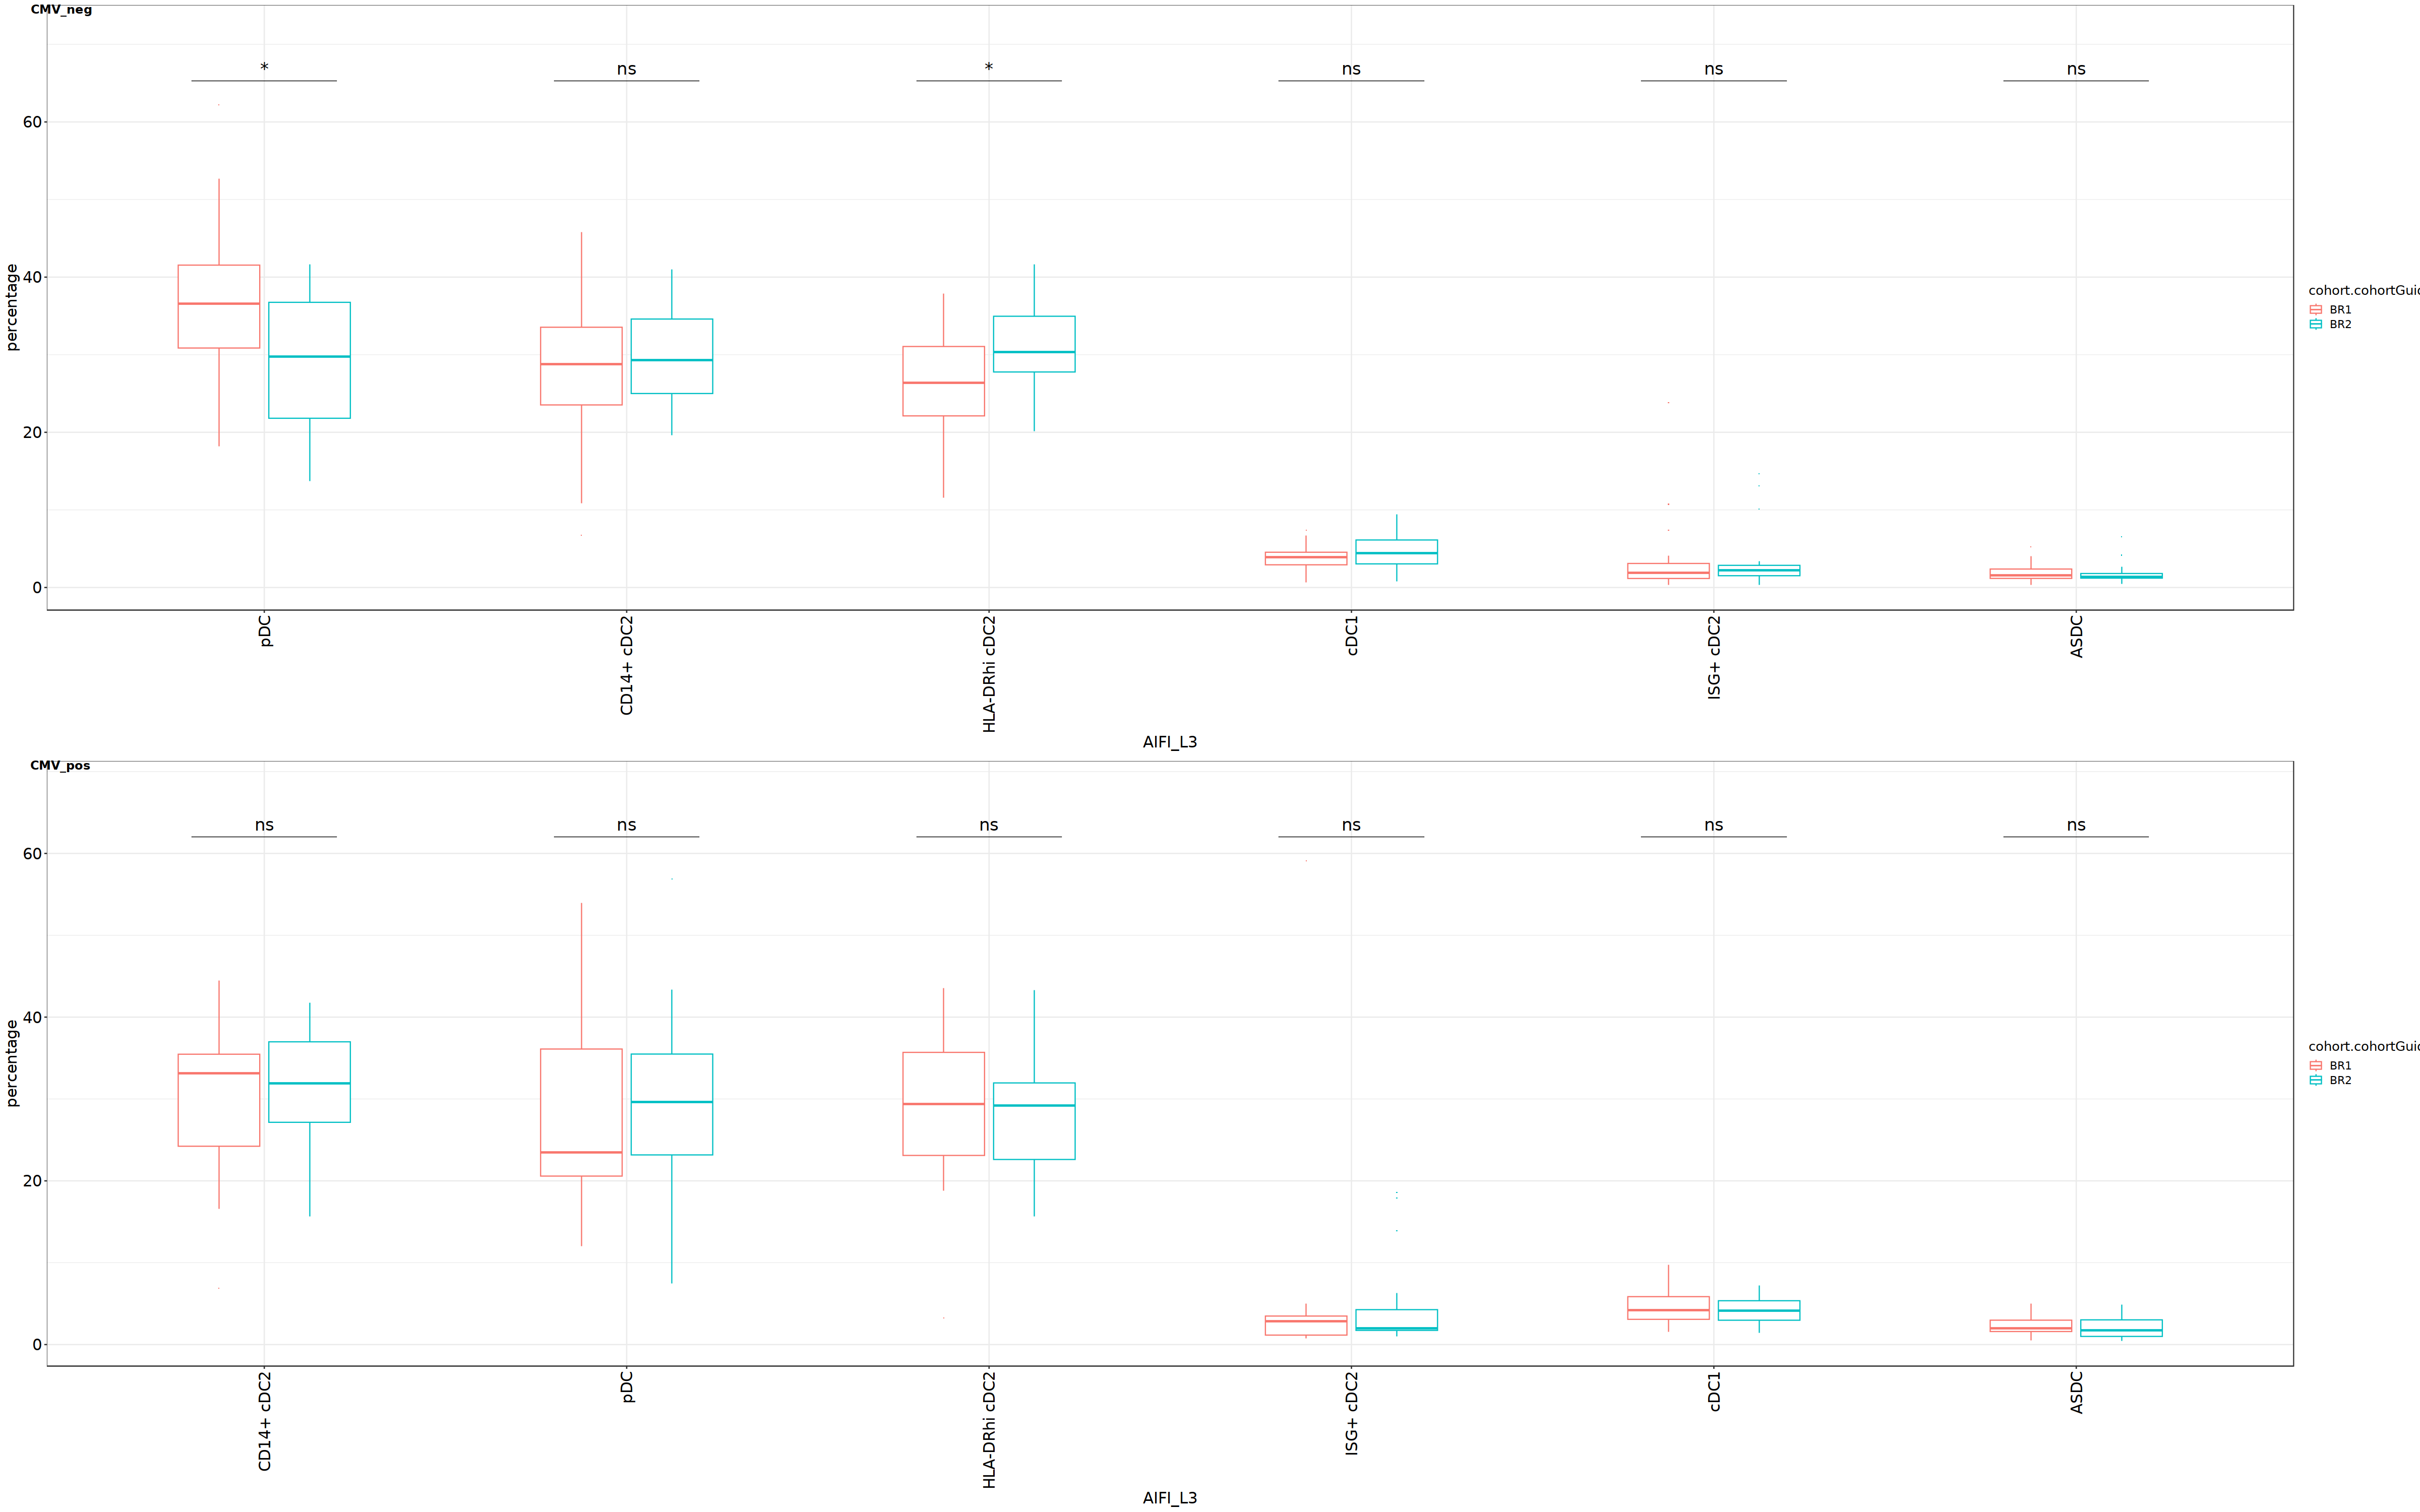

In [122]:
# Percentage-comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]


stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


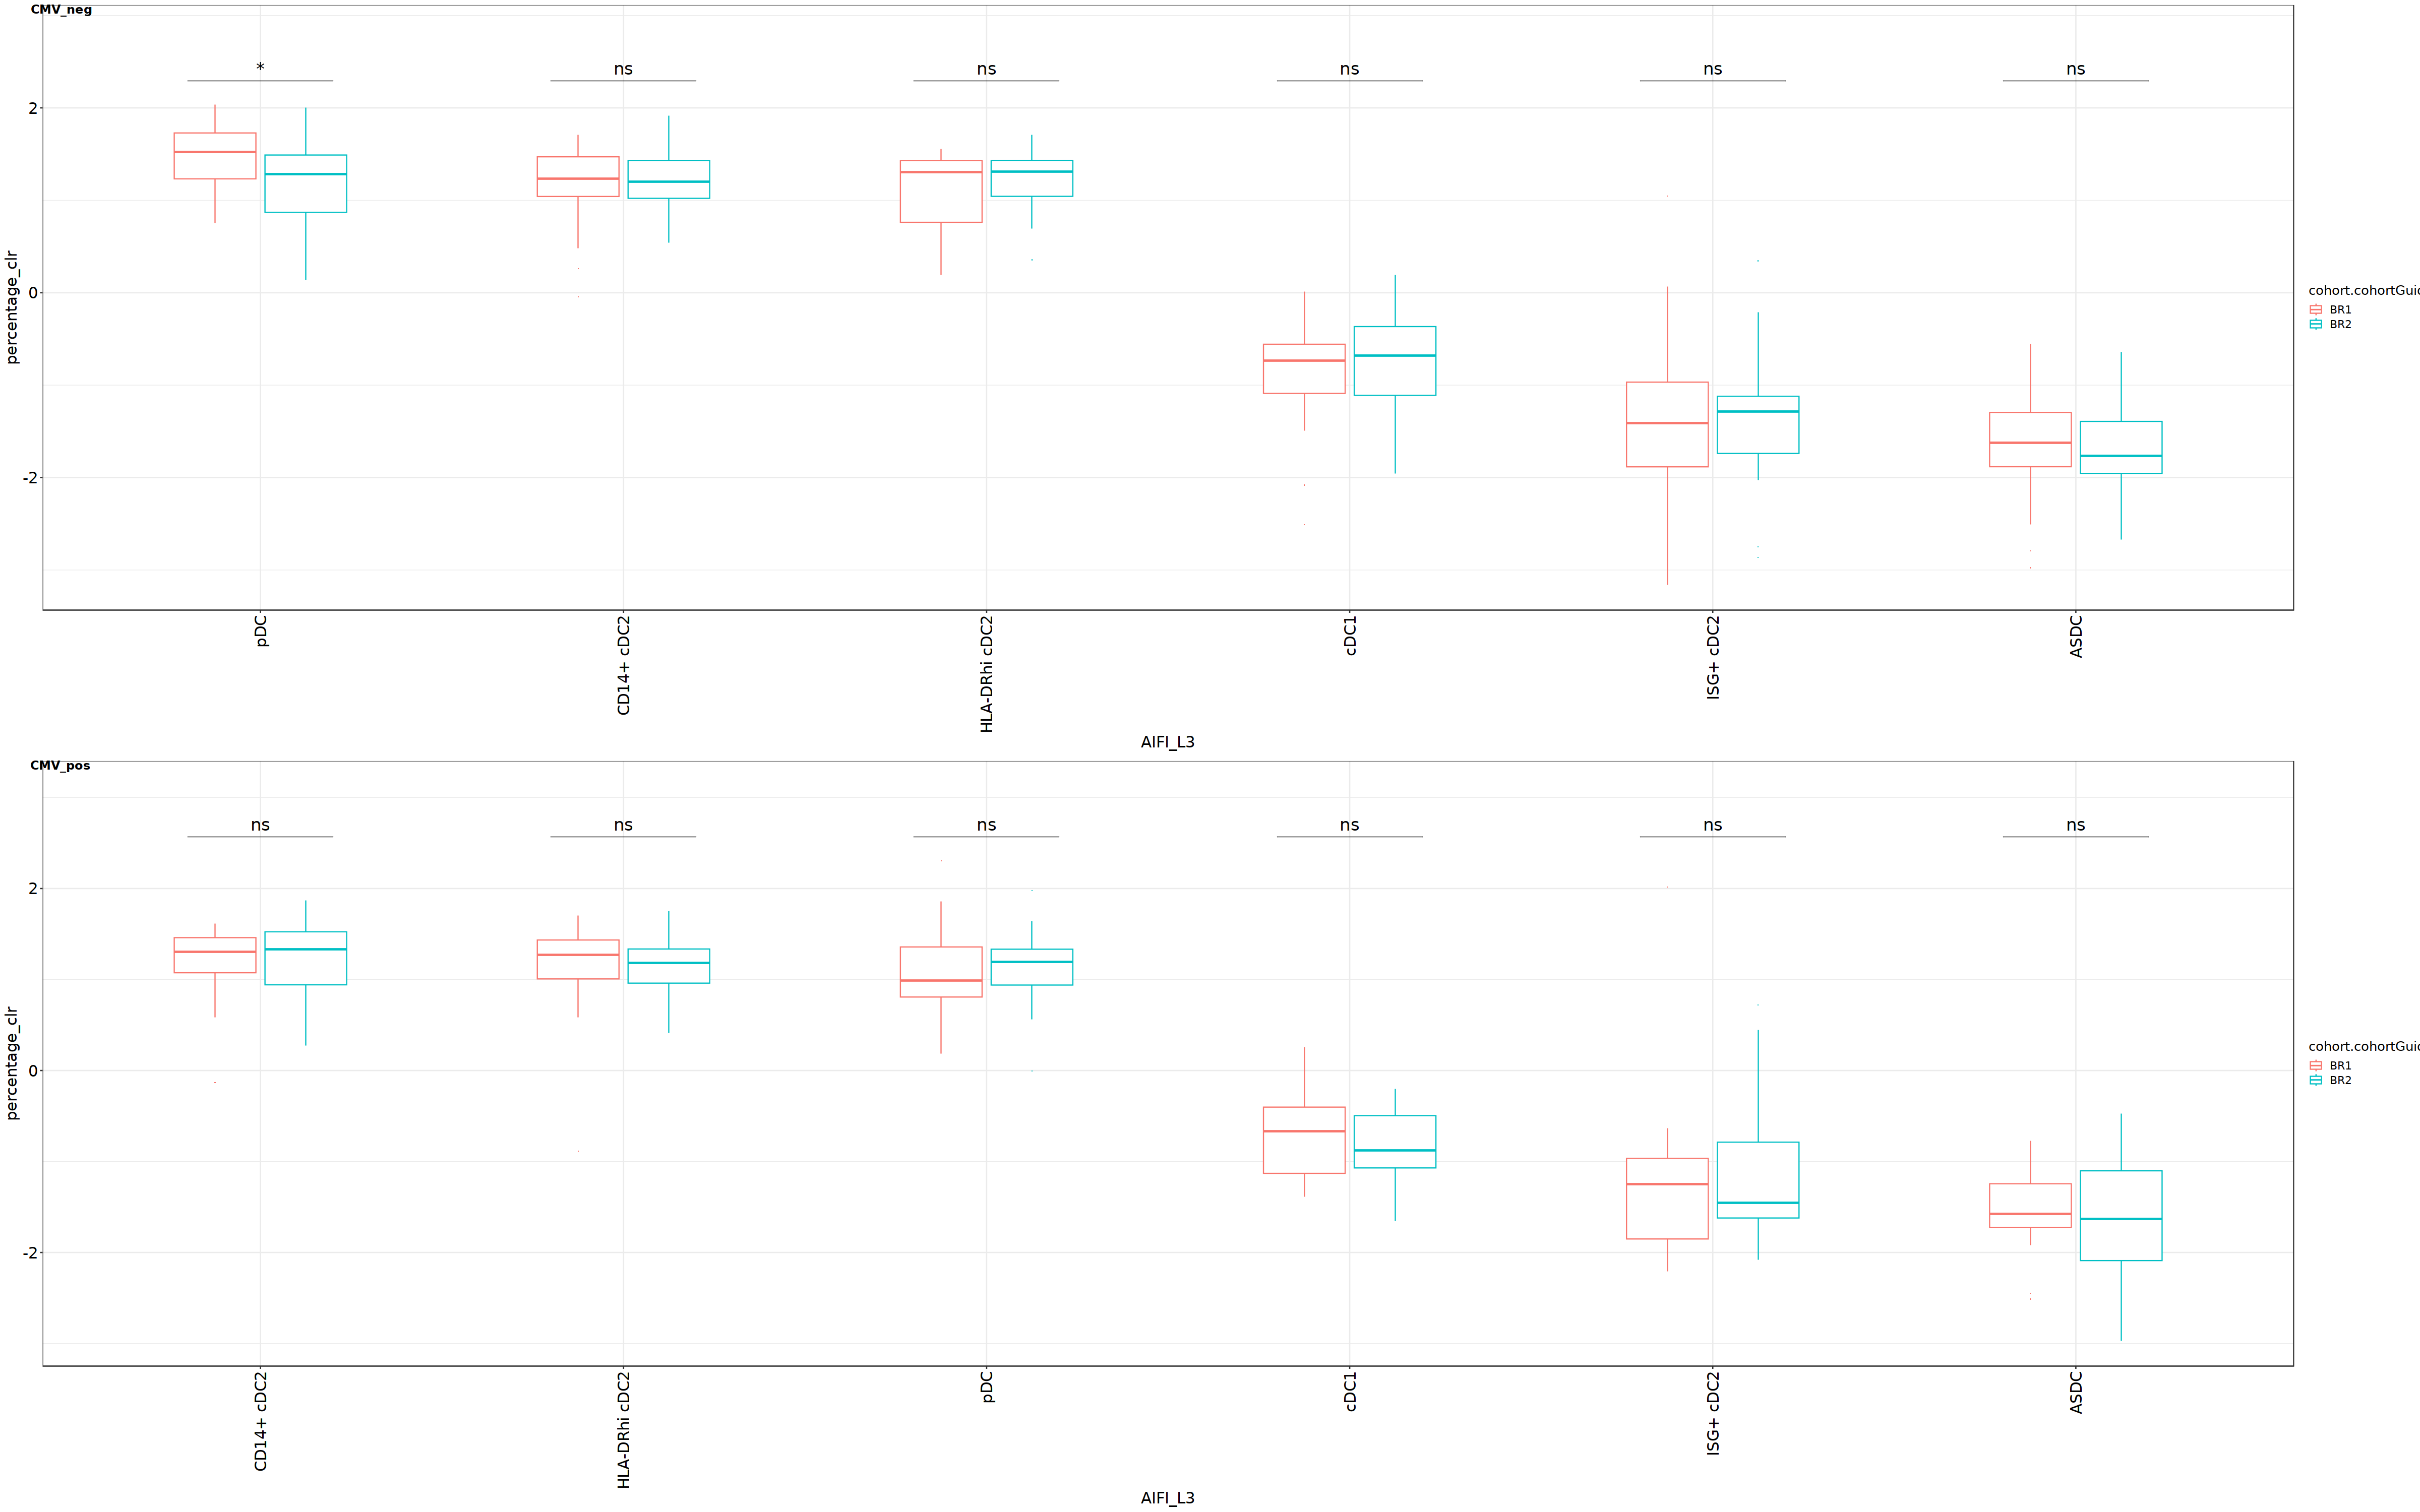

In [123]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- DC_df[DC_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

# Comparsion within NK cell (Percentage and Percentage CLR - AIFI Level 1 celltypes)

In [98]:
NK_df <- myeloid_df %>% filter(AIFI_L1 == 'NK cell')

In [99]:
unique(NK_df$AIFI_L1)

[1] "NK cell"

In [100]:
## Percentage of total

NK_df <- NK_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(NK_df)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3          subject.subjectGuid count percentage percentage_clr
1 Adaptive NK cell BR1001              93    7.6417420  -0.08892257   
2 Adaptive NK cell BR1002              50    2.4271845  -0.45897524   
3 Adaptive NK cell BR1003              17    1.5582035  -1.57457787   
4 Adaptive NK cell BR1004              12    0.8264463  -1.73975624   
5 Adaptive NK cell BR1005               5    1.3513514  -1.56677168   
6 Adaptive NK cell BR1006              32    2.1011162  -0.92182610

In [101]:
NK_df<-left_join(NK_df,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [102]:
head(NK_df)

AIFI_L3          subject.subjectGuid count percentage percentage_clr
1 Adaptive NK cell BR1001              93    7.6417420  -0.08892257   
2 Adaptive NK cell BR1002              50    2.4271845  -0.45897524   
3 Adaptive NK cell BR1003              17    1.5582035  -1.57457787   
4 Adaptive NK cell BR1004              12    0.8264463  -1.73975624   
5 Adaptive NK cell BR1005               5    1.3513514  -1.56677168   
6 Adaptive NK cell BR1006              32    2.1011162  -0.92182610   
  cohort.cohortGuid subject.biologicalSex
1 BR1               Female               
2 BR1               Male                 
3 BR1               Female               
4 BR1               Male                 
5 BR1               Female               
6 BR1               Male                 
  CMV.IgG.Serology.Result.Interpretation
1 Negative                              
2 Negative                              
3 Negative                              
4 Negative                              
5 Negative                              
6 Negative

In [103]:
NK_df %>% filter(subject.subjectGuid == "BR1003") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

Adding missing grouping variables: `AIFI_L3`, `cohort.cohortGuid`


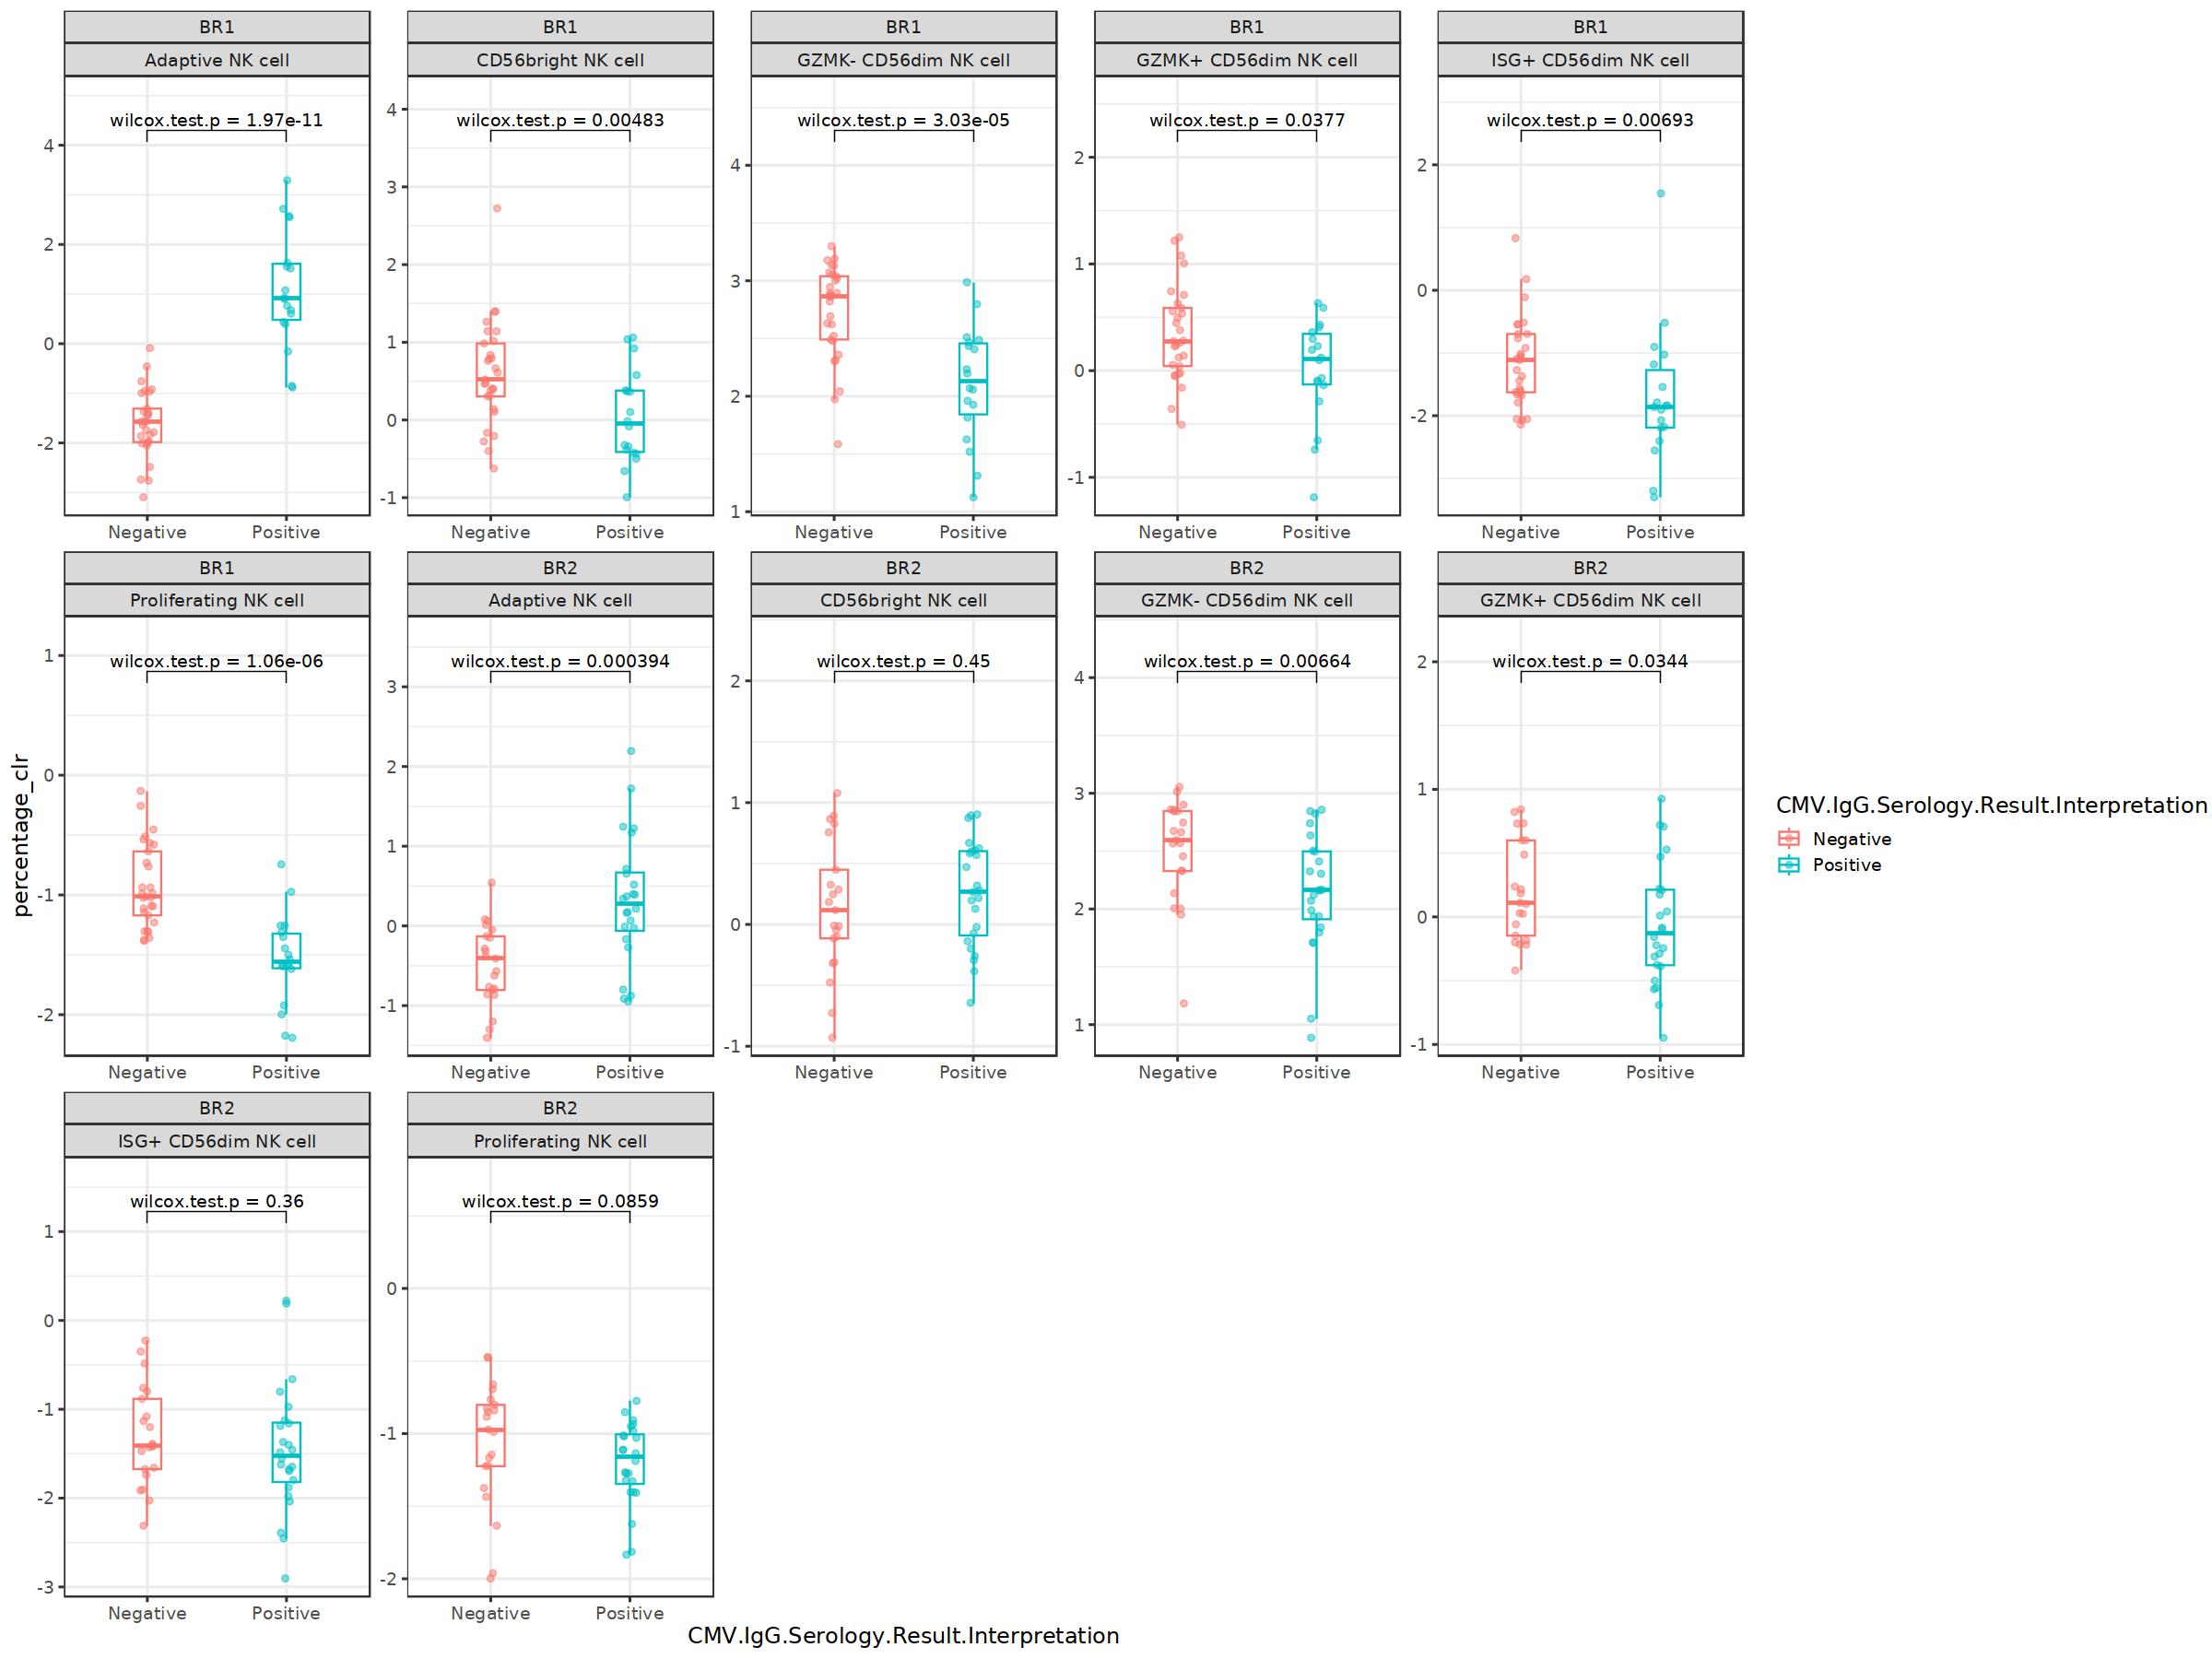

In [104]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 15)

stat.test <- NK_df %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-NK_df %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull() + 1


stat.test$y.position<-max_values


my_plot <- ggplot(NK_df, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 15)

stat.test <- NK_df %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)



max_values<-NK_df %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(NK_df, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))



my_plot

In [ ]:
##############GLOBAL PLOTS##############################

In [ ]:
# Percentage comparing Age across CMV

result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 0, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test

In [ ]:
# Percentage- CLR comparing Age across CMV

result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 0, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


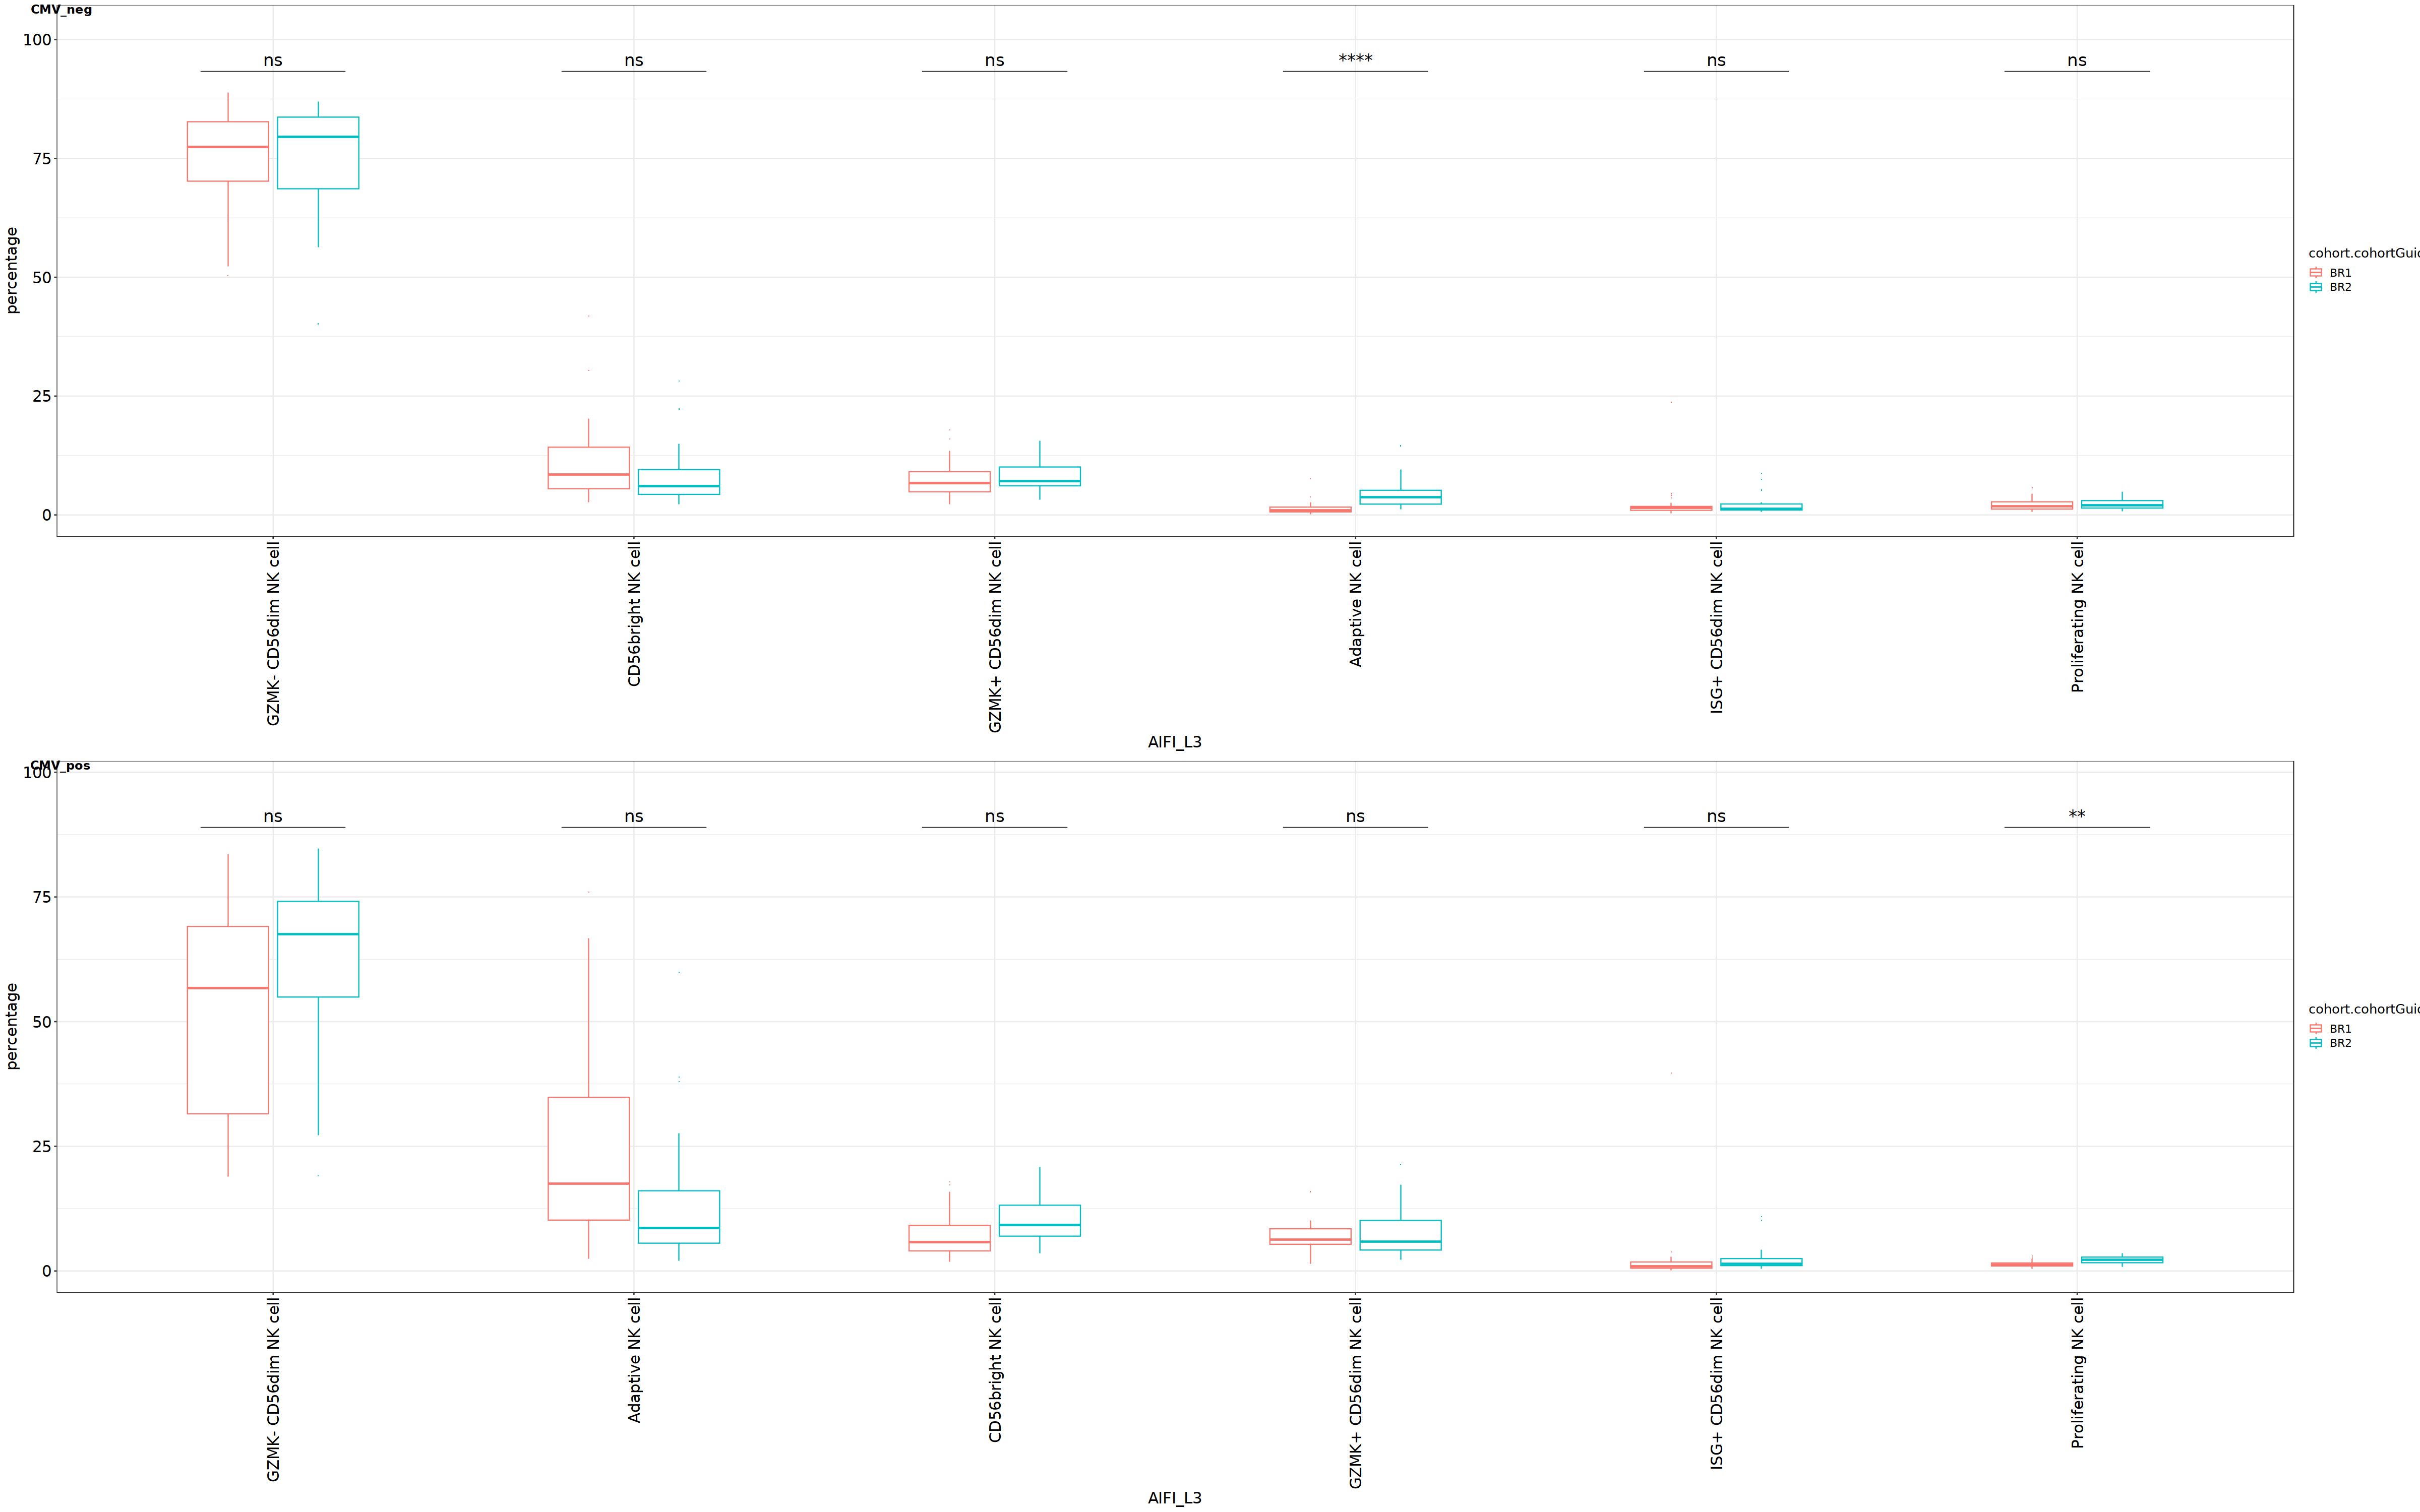

In [105]:
# Percentage-comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]


stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


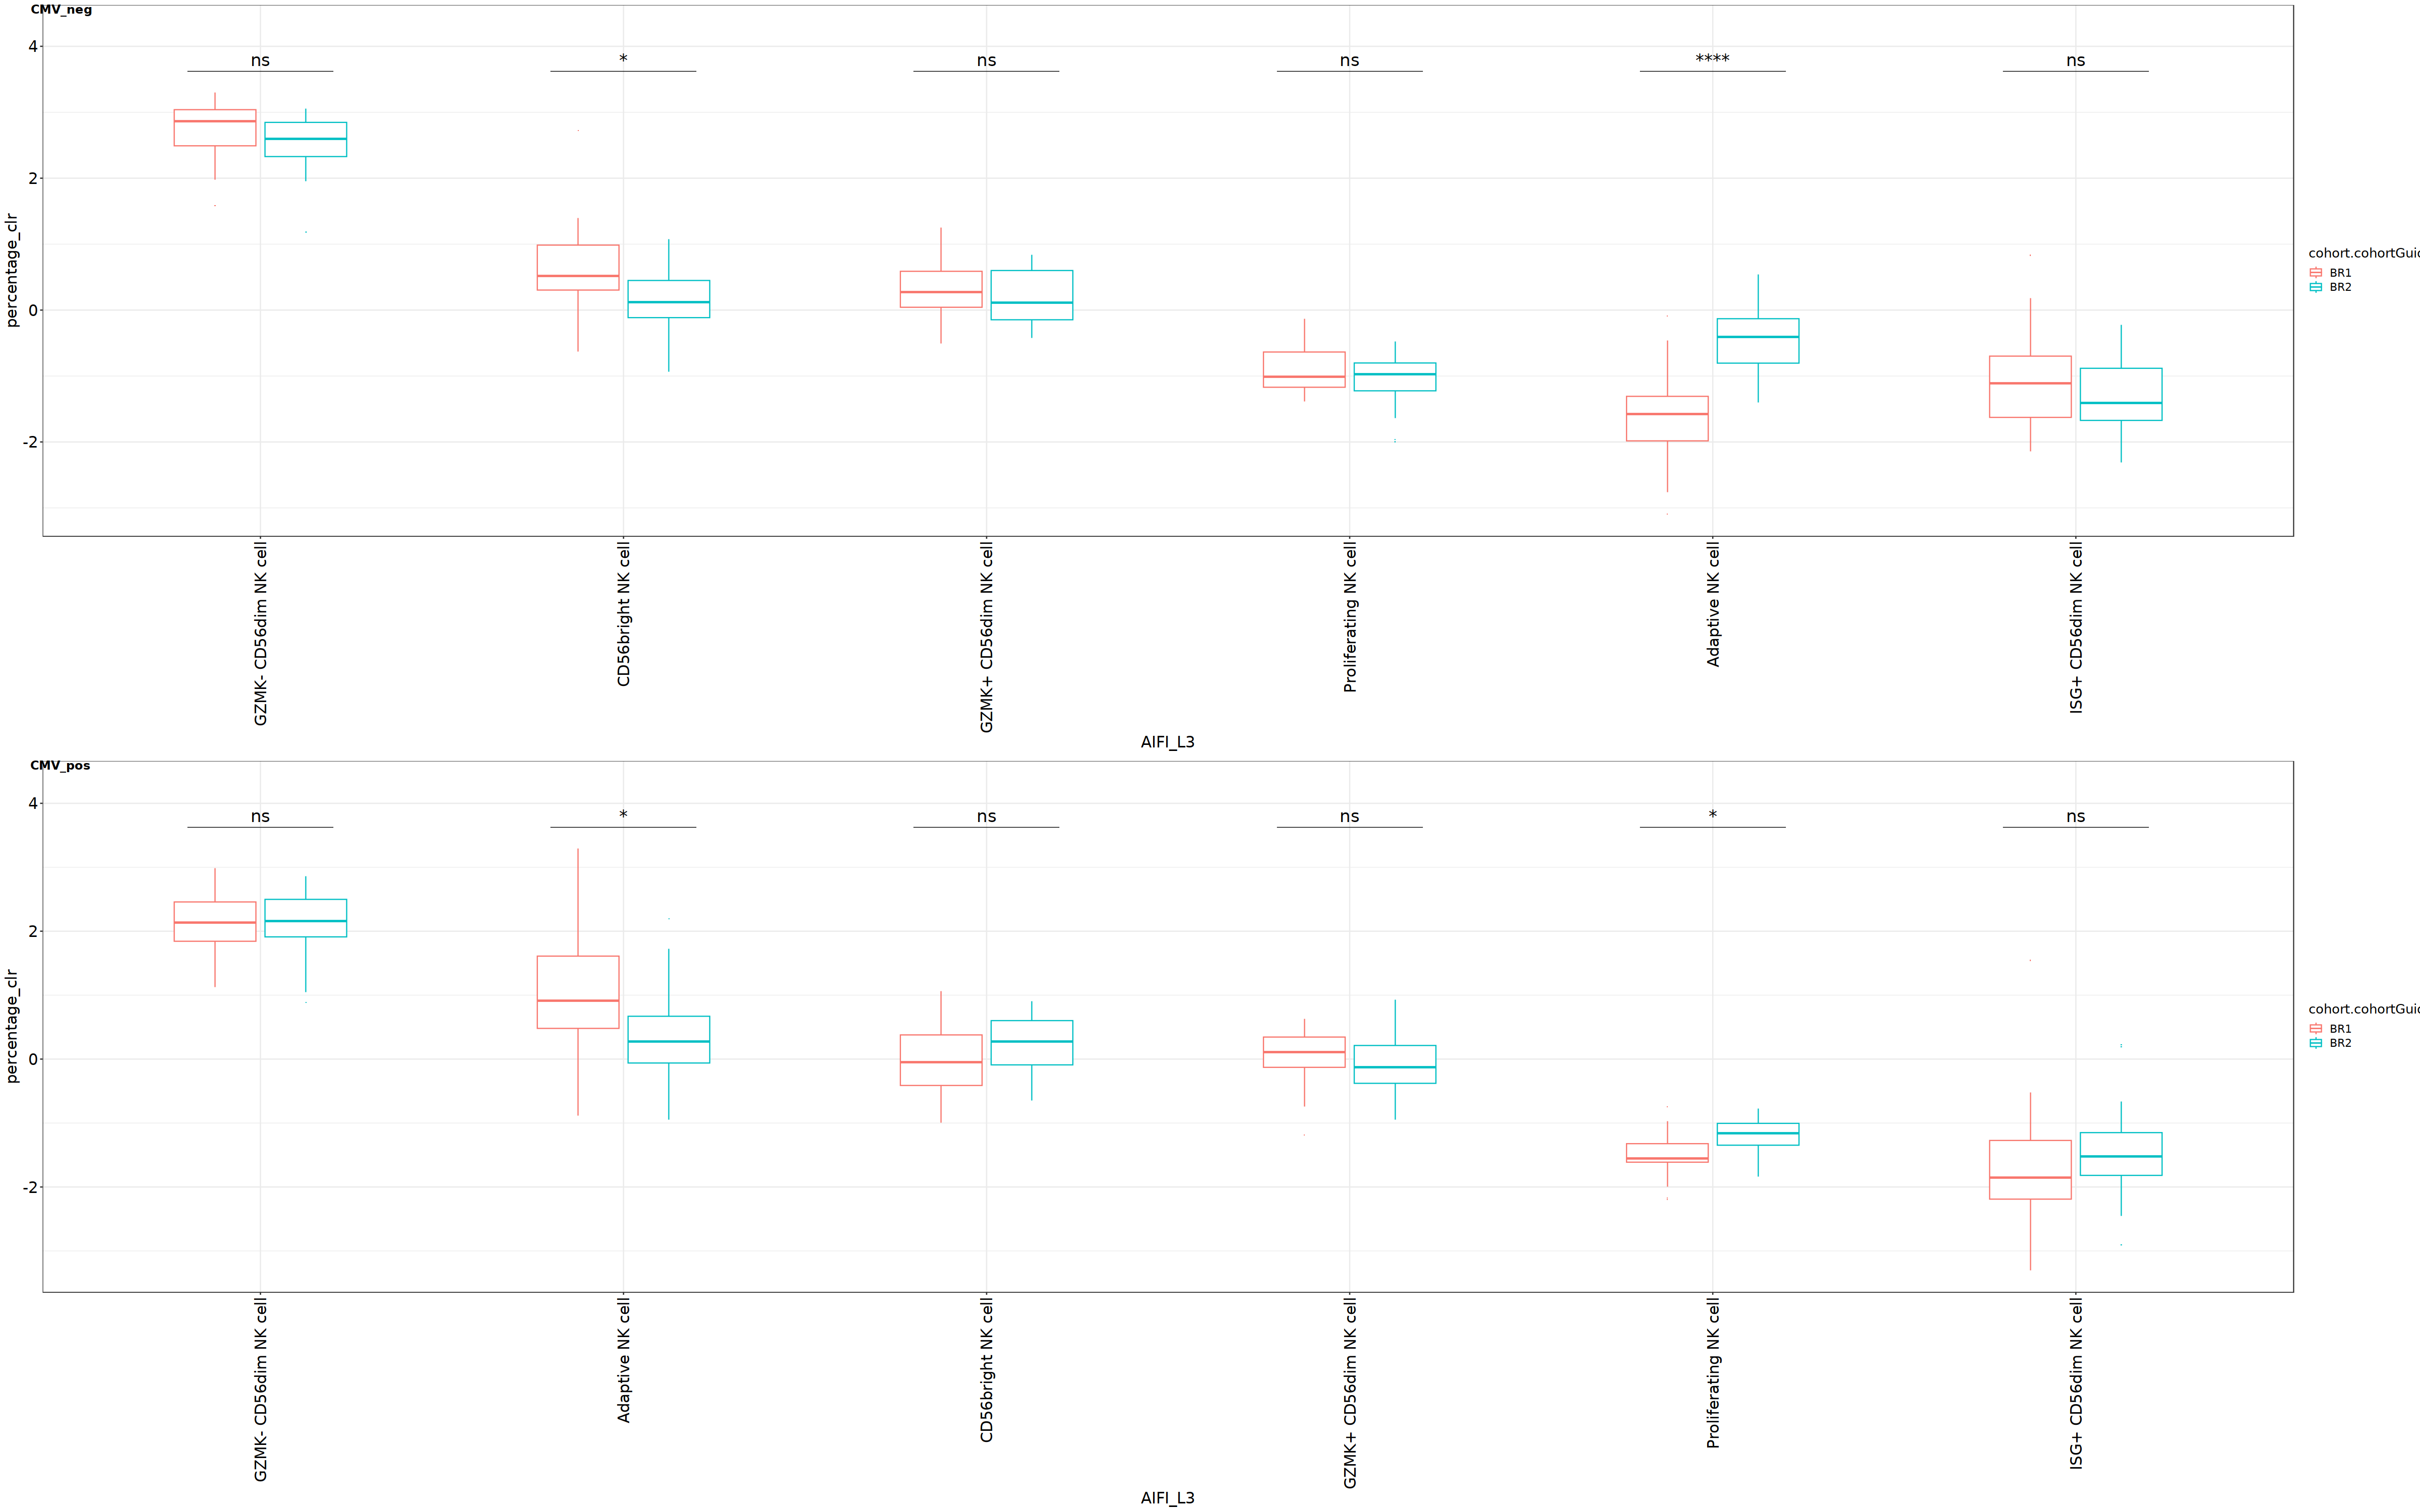

In [106]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- NK_df[NK_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

# Comparsion within Progenitor cell (Percentage and Percentage CLR - AIFI Level 1 celltypes)

In [107]:
Progenitor_df <- myeloid_df %>% filter(AIFI_L1 == 'Progenitor cell')

In [108]:
unique(Progenitor_df$AIFI_L1)

[1] "Progenitor cell"

In [109]:
## Percentage of total

Progenitor_df <- Progenitor_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(Progenitor_df)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3      subject.subjectGuid count percentage percentage_clr
1 BaEoMaP cell BR1001              1      9.090909  -0.7324082    
2 BaEoMaP cell BR1002              2     11.764706  -0.8796858    
3 BaEoMaP cell BR1005              2      5.555556  -1.2458899    
4 BaEoMaP cell BR1006              1      6.666667  -1.1655025    
5 BaEoMaP cell BR1008              1     14.285714  -0.5364793    
6 BaEoMaP cell BR1009              1      5.263158  -1.4479351

In [110]:
Progenitor_df<-left_join(Progenitor_df,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [111]:
head(Progenitor_df)

AIFI_L3      subject.subjectGuid count percentage percentage_clr
1 BaEoMaP cell BR1001              1      9.090909  -0.7324082    
2 BaEoMaP cell BR1002              2     11.764706  -0.8796858    
3 BaEoMaP cell BR1005              2      5.555556  -1.2458899    
4 BaEoMaP cell BR1006              1      6.666667  -1.1655025    
5 BaEoMaP cell BR1008              1     14.285714  -0.5364793    
6 BaEoMaP cell BR1009              1      5.263158  -1.4479351    
  cohort.cohortGuid subject.biologicalSex
1 BR1               Female               
2 BR1               Male                 
3 BR1               Female               
4 BR1               Male                 
5 BR1               Female               
6 BR1               Female               
  CMV.IgG.Serology.Result.Interpretation
1 Negative                              
2 Negative                              
3 Negative                              
4 Negative                              
5 Positive                              
6 Negative

In [112]:
Progenitor_df %>% filter(subject.subjectGuid == "BR1004") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 9)

stat.test <- Progenitor_df %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-Progenitor_df %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()


stat.test$y.position<-max_values


my_plot <- ggplot(Progenitor_df, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##percentage-CLR comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 10)

stat.test <- Progenitor_df %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-Progenitor_df %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull() + 1


stat.test$y.position<-max_values


my_plot <- ggplot(Progenitor_df, aes(CMV.IgG.Serology.Result.Interpretation, percentage_clr,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot

In [ ]:
##############GLOBAL PLOTS##############################

In [ ]:
# Percentage comparing Age across CMV

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


In [ ]:
stat_test

In [ ]:
# Percentage- CLR comparing Age across CMV

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
options(repr.plot.width = 35, repr.plot.height = 17)
p4 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="p= {p.adj} {p.signif}", angle = 90, hide.ns = FALSE  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 16, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 16, color = "black"),
        axis.title.x = element_text(size = 16, color = "black"),
        axis.title.y = element_text(size = 16, color = "black"))

# Display the plot
print(p4)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


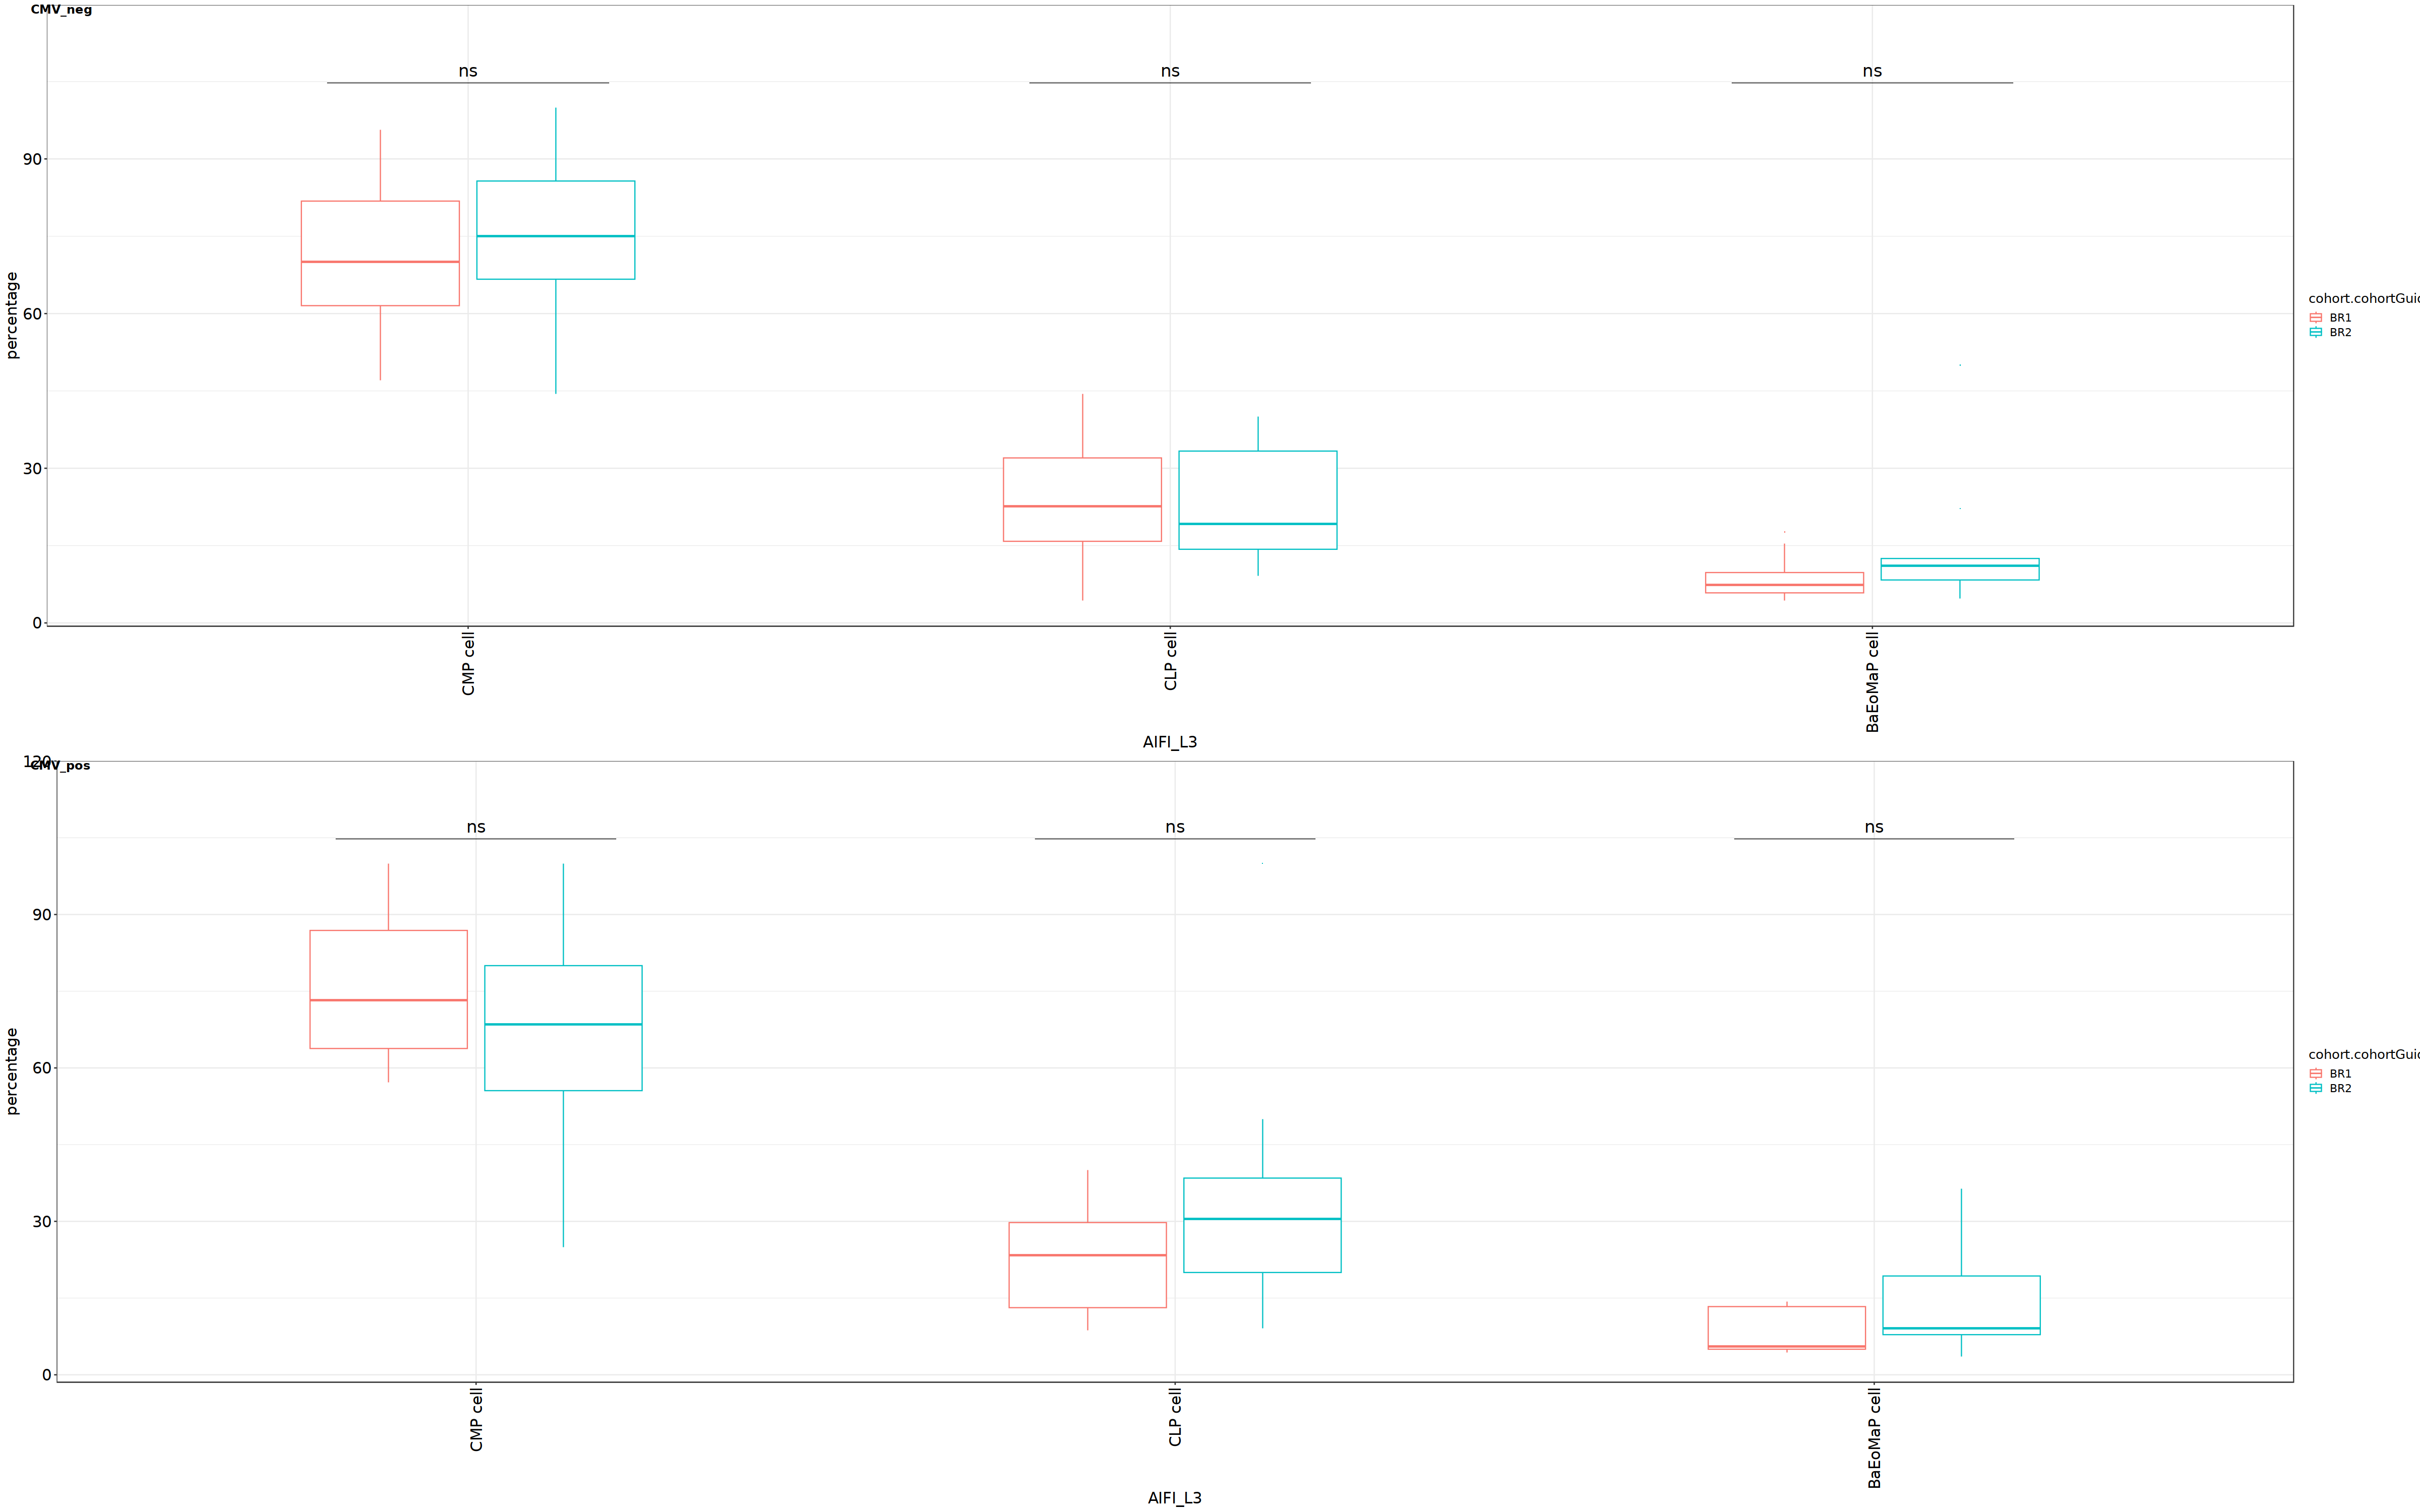

In [113]:
# Percentage-comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- Progenitor_df[Progenitor_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]


stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- Progenitor_df[Progenitor_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


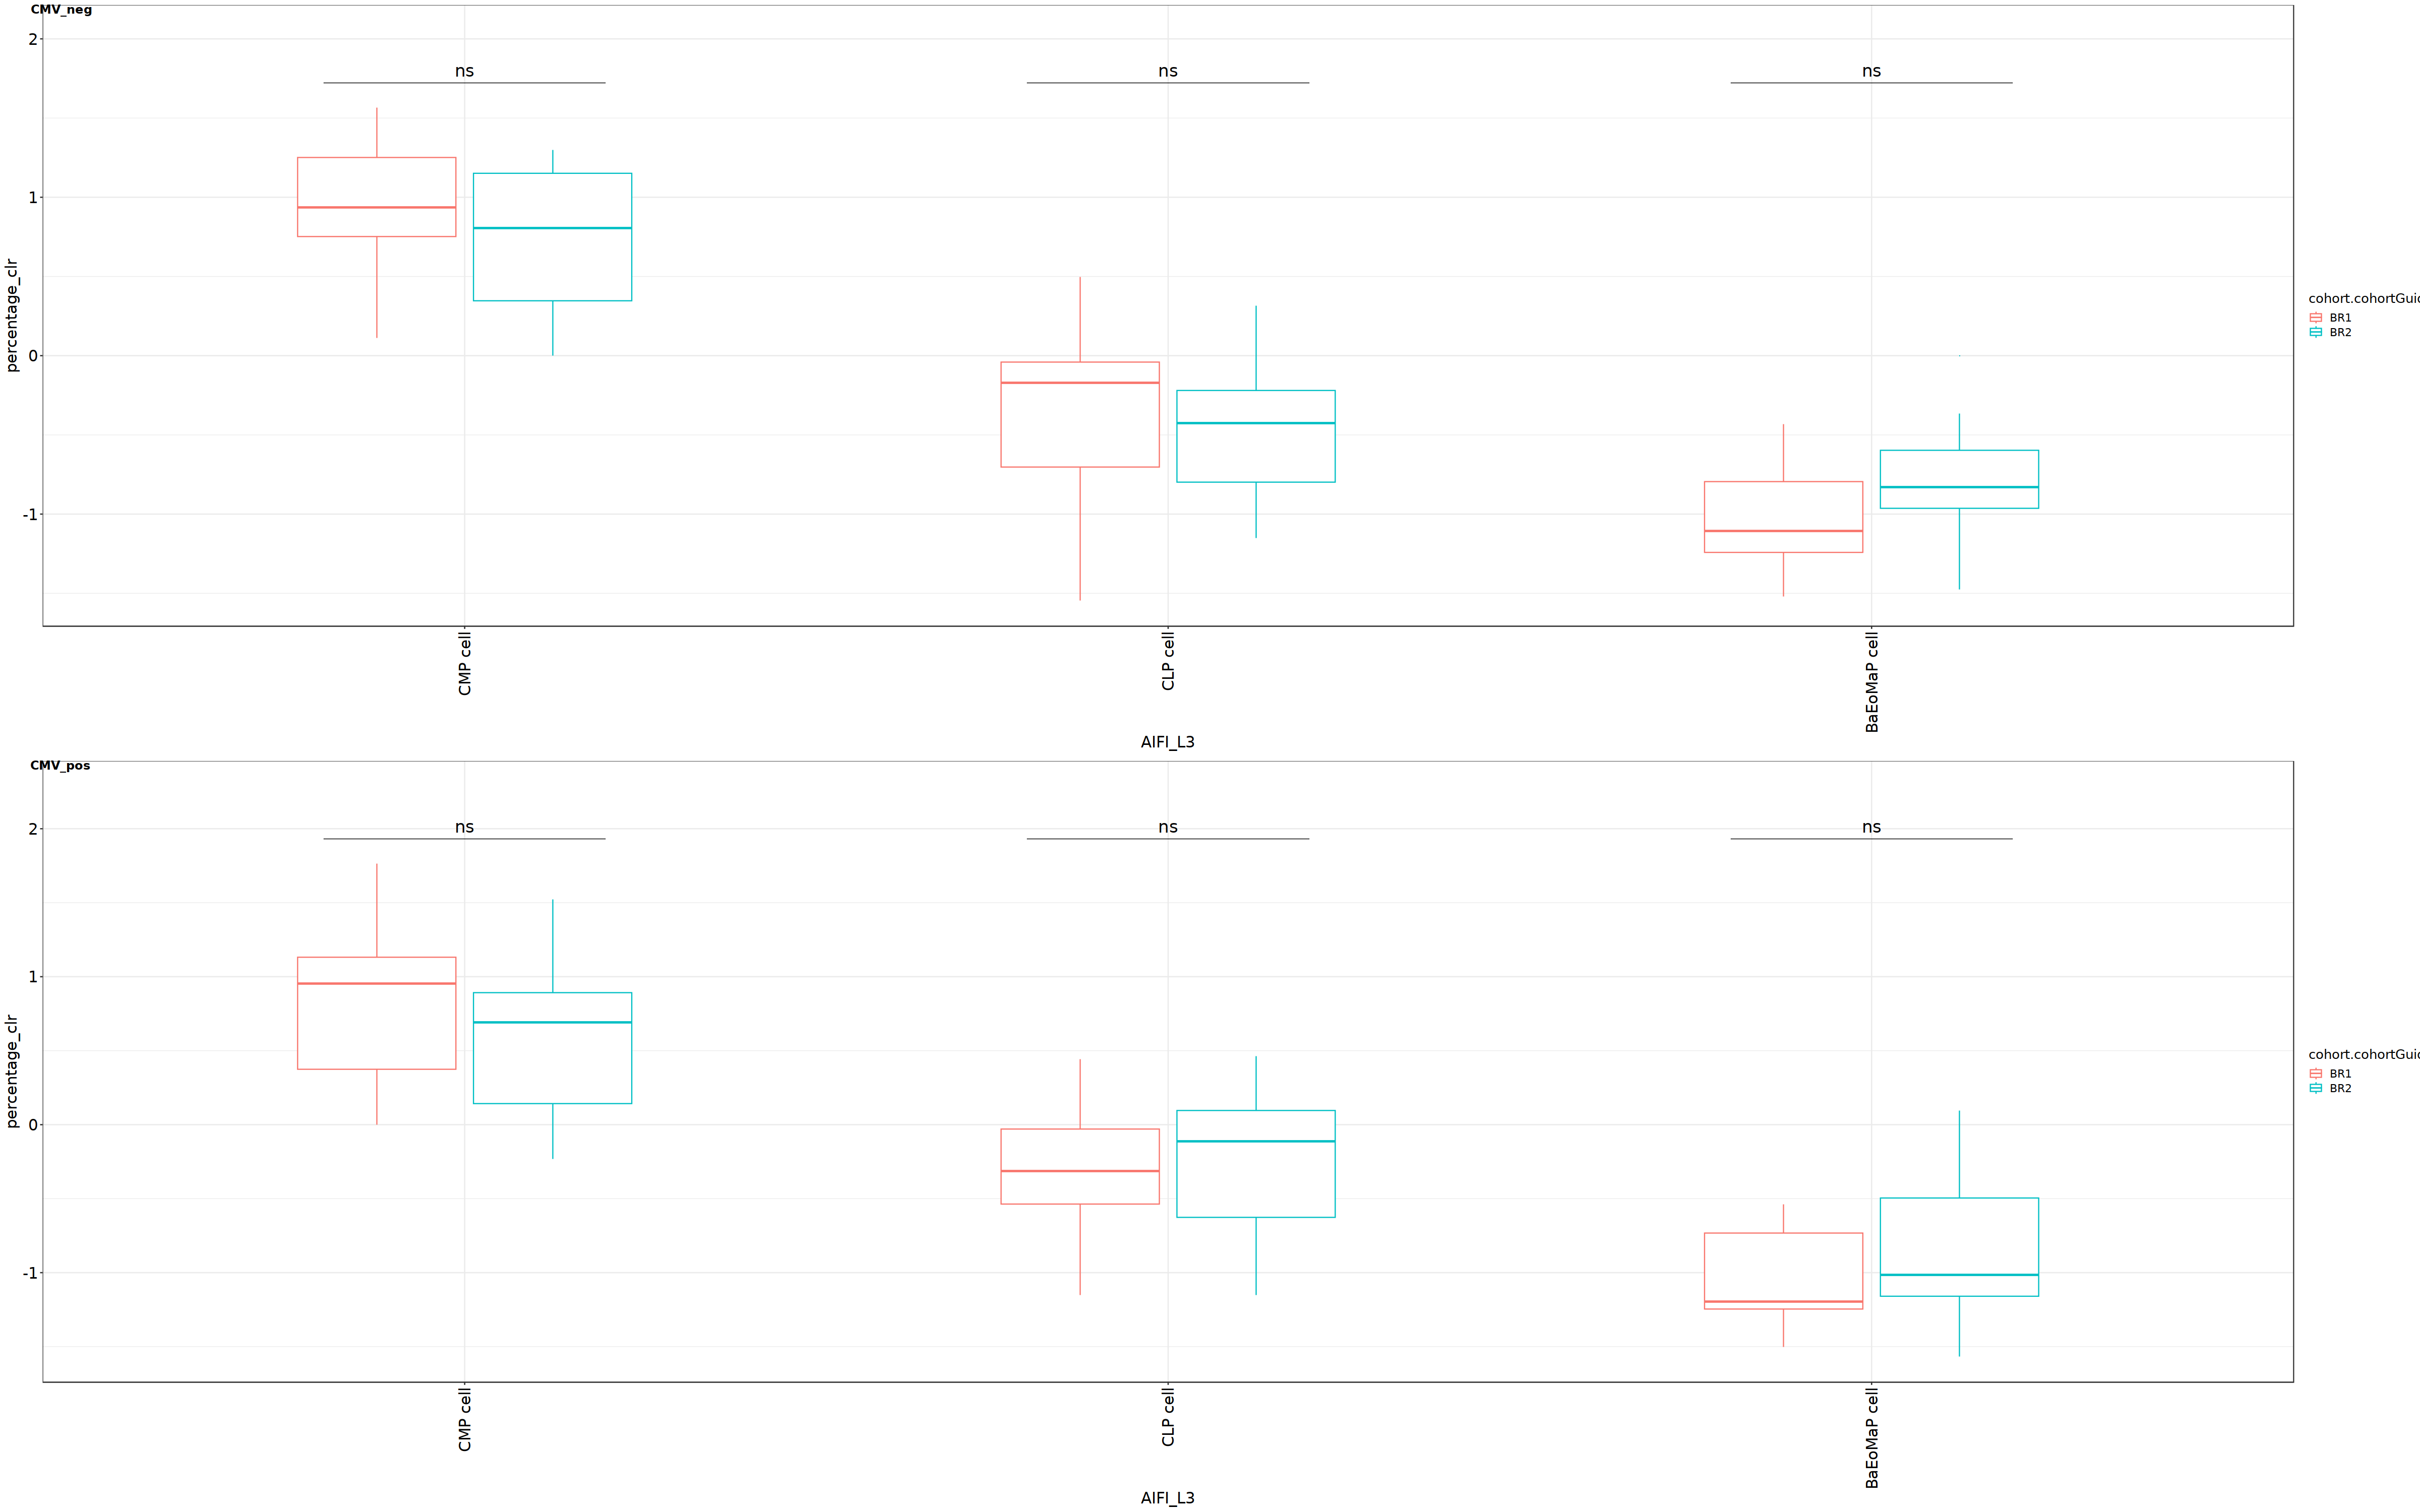

In [114]:
# Percentage- CLR comparing Age across CMV


####################. Negative CMV ####################
result_cohort <- Progenitor_df[Progenitor_df$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size=7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

####################. Positive CMV ####################

result_cohort <- Progenitor_df[Progenitor_df$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ cohort.cohortGuid) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


## Create the plot
#options(repr.plot.width = 35, repr.plot.height = 17)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, color = cohort.cohortGuid)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = cohort.cohortGuid),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)

#Combine Plot
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1)

combined_plot

In [ ]:
###ROUGH WORK

In [ ]:
p4 <- ggplot(NK_df, aes(x = AIFI_L3, y = percentage_clr, color = CMV.IgG.Serology.Result.Interpretation)) + 
  geom_boxplot(width = .5, outlier.shape = '.') + 
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 60)) + 
  theme_bw(base_size = 12) +
  theme(axis.text = element_text(size = 15), axis.title = element_text(size = 14)) +
  stat_compare_means(aes(group = CMV.IgG.Serology.Result.Interpretation), method = "wilcox.test", label = "p") 

p4

In [ ]:
p4 <- ggplot(NK_df, aes(x = AIFI_L3, y = percentage_clr, color = CMV.IgG.Serology.Result.Interpretation)) + 
  geom_boxplot(width = .5, outlier.shape = '.') + 
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 60)) + 
  theme_bw(base_size = 12) +
  theme(axis.text = element_text(size = 15), axis.title = element_text(size = 14)) +
  stat_compare_means(aes(group = CMV.IgG.Serology.Result.Interpretation), method = "wilcox.test", label = "p") 

p4

In [ ]:
p4 <- ggplot(NK_df, aes(x = AIFI_L3, y = percentage_clr, color = CMV.IgG.Serology.Result.Interpretation)) + 
  geom_boxplot(width = .5, outlier.shape = '.') + 
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 60)) + 
  theme_bw(base_size = 12) +
  theme(axis.text = element_text(size = 15), axis.title = element_text(size = 14)) +
  stat_compare_means(aes(group = cohort.cohortGuid), method = "wilcox.test", label = "p") +
  facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y")  # Use facet_grid for separate plots

# Display the plot
print(p4)


In [ ]:
install.packages("ggpubr")
library(ggpubr)


In [ ]:
####SAMIR's WORK###################

library(tidyverse)
library(coin)

options(repr.plot.width = 20, repr.plot.height = 15)

# Assuming percentage_clr is a valid variable in NK_df
# p4 <- ggplot(NK_df, aes(x = AIFI_L3, y = percentage_clr, color = CMV.IgG.Serology.Result.Interpretation)) + 
#   geom_boxplot(width = .5, outlier.shape = NA) + 
#   theme_bw(base_size = 14) +
#   theme(axis.text = element_text(size = 15), axis.title = element_text(size = 14)) +
#   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
#   facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
#   stat_pvalue_manual(stat.test, label = "wilcox.test.p = {p}")

# p4
#stat.test
stat.test$AdjP = round(p.adjust(stat.test$p, 'BH'),3)

stat.test %>% head()
tmp = left_join(NK_df, stat.test)
#ggplot(NK_df
head(tmp)

NK_df$PercentageCLR = NK_df$`.y`
ggplot(tmp, aes(x=AIFI_L3,
                y=PercentageCLR,
                fill=CMV.IgG.Serology.Result.Interpretation,
                label=AdjP))+geom_boxplot()+
        geom_text(mapping = aes(x=AIFI_L3,
                                y=max(PercentageCLR)+0.4))

In [ ]:
result <- all_df_subset %>%
  dplyr::group_by(celltypes, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

In [ ]:
result<-left_join(result,unique(all_df_subset[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))
result<-result %>% filter(!celltypes=="gdT")

In [ ]:
#percentage
options(repr.plot.width = 18, repr.plot.height = 12)
stat.test <- result %>% select(percentage,celltypes,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(celltypes) %>%
  wilcox_test(percentage ~ cohort.cohortGuid)

max_values<-result %>%
  group_by(celltypes) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()+1
stat.test$y.position<-max_values
ggplot(result , aes(cohort.cohortGuid, percentage,color=cohort.cohortGuid)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+scale_color_d3()+
facet_wrap(~celltypes,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

In [ ]:
#result %>% filter(subject.subjectGuid == "BR1001") %>% 
    #  pull() %>% 
     # sum()

In [ ]:
result <- myeloid_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) 

head(result)
sum(result$count)

In [ ]:
result<- result %>%
  dplyr::group_by(subject.subjectGuid) %>%
  dplyr::mutate(percentage = (count / sum(count)) * 100)
  

sum(result$count)
head(result)

In [ ]:
subset_df <- myeloid_df[, c('AIFI_L1', 'AIFI_L3','subject.subjectGuid' )]

In [ ]:
head(subset_df)

In [ ]:
result_subset <- subset_df %>%
  dplyr::group_by(AIFI_L1, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) 

head(result_subset)
sum((result_subset$count))

In [ ]:
result_subset <- subset_df %>%
  dplyr::group_by(AIFI_L1, AIFI_L3,  subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) 

head(result_subset)
sum((result_subset$count))

In [ ]:
#######TALLY METHOD

In [ ]:
tally_df <- tally(group_by(subset_df, AIFI_L1, AIFI_L3, subject.subjectGuid ))

In [ ]:
sum(tally_df$n)

In [ ]:
# Calculate the total number of cells
total_cells <- sum(tally_df$n)

# Calculate the percentage relative to the total number of cells
tally_df <- tally_df %>%
  mutate(percentage = (n / total_cells) * 100)

print(tally_df)
sum(tally_df$n)

In [ ]:
tally_df <- tally_df %>%
  group_by(AIFI_L1, AIFI_L3) %>%
  mutate(percentage = (n / sum(n)) * 100) %>%
  ungroup()

print(tally_df)

In [ ]:
tally_df_B_cell <- tally_df %>% filter(AIFI_L1 == 'B cell')

In [ ]:
tally_df_B_cell
sum(tally_df_B_cell$n)

In [ ]:
tally_df_B_cell <- tally_df_B_cell %>%
  group_by(AIFI_L1, AIFI_L3) %>%
  mutate(percentage = (n / sum(n)) * 100) %>%
  ungroup()

print(tally_df_B_cell)

In [ ]:
result_2 <- myeloid_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count_AIFI_L3 = n()) 

head(result_2)

In [ ]:
merged_df <- left_join(result, result_2, by = "subject.subjectGuid", all = TRUE)

In [ ]:
head(merged_df)


In [ ]:
result<-left_join(result_2,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [ ]:
#kable(table(myeloid_df$AIFI_L1))
kable(table(myeloid_df$AIFI_L3))
#kable(table(subset_df$AIFI_L1))

In [ ]:
sum(table(myeloid_df$AIFI_L1))


In [ ]:
library("knitr")

In [ ]:
#debugging
result <- myeloid_df %>%
  dplyr::group_by(AIFI_L1, subject.subjectGuid) %>%               
  dplyr::summarise(AIFI_L1_count = n()) 
  #dplyr::mutate(percentage = (count / sum(count)) * 100)

#sum(result$count)
head(result)

In [ ]:
#for total PBMC
result <- myeloid_df %>%
  dplyr::group_by(AIFI_L3) %>%                        # Group by cell type
  dplyr::summarise(count = n()) %>%                  # Count occurrences for each cell type
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::ungroup() %>%
  dplyr::mutate(percentage_clr = clr_transform(percentage)) # Apply CLR transformation

head(result)

In [ ]:
#of parent cell type (AIFI_L1)
result_cell_types_within_parent <- myeloid_df %>%
  dplyr::group_by(AIFI_L1, AIFI_L3) %>%               # Group by parent cell type and cell type
  dplyr::summarise(count = n()) %>%                  # Count occurrences for each cell type within its parent
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(AIFI_L1) %>%                       
  dplyr::mutate(percentage_clr = clr_transform(percentage)) %>% # Apply CLR transformation
  dplyr::ungroup()


In [ ]:
####Loop code to consider the parent types 

In [ ]:
result

In [ ]:
result<-left_join(result,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [ ]:
head(result)
unique(result$cohort.cohortGuid)

In [ ]:
results <- myeloid_df %>%
     dplyr::group_by(AIFI_L1, AIFI_L3, subject.subjectGuid ) %>% 
    dplyr::count(AIFI_L1 )
    
head(results)

In [ ]:
rownames(stat.test)

In [ ]:
########Stat test (Wilcoxon) and Boxplot

In [ ]:
stat.test <- result %>% select(percentage_clr,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation)



In [ ]:
head(stat.test)

In [ ]:
ggsave("/home/jupyter/Myeloid_cells/Plots/AIFI_L3_CMVcompare_allCohorts_percentage_clr.png", plot = my_plot, width = 15, height = 49, units = "in", dpi = 300)

In [ ]:
##percentage comparsion by CMV 

options(repr.plot.width = 20, repr.plot.height = 100)

stat.test <- result %>% select(percentage,AIFI_L3,CMV.IgG.Serology.Result.Interpretation,cohort.cohortGuid)%>%
    unique(.)%>% 
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  wilcox_test(percentage ~ CMV.IgG.Serology.Result.Interpretation)


max_values<-result %>%
  group_by(AIFI_L3,cohort.cohortGuid) %>%
  slice(which.max(percentage))%>% select(percentage) %>% pull()+1


stat.test$y.position<-max_values


my_plot <- ggplot(result, aes(CMV.IgG.Serology.Result.Interpretation, percentage,color=CMV.IgG.Serology.Result.Interpretation)) + 
    geom_boxplot(width = .2, outlier.shape = NA) + 
    geom_jitter(width = .05, alpha = .5)+
    theme_bw(base_size=14)+
facet_wrap(~cohort.cohortGuid+AIFI_L3,scale="free",ncol=5)+ stat_pvalue_manual(stat.test,label = "wilcox.test.p = {p}")+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))

my_plot